Use average of 10 last iterations as decision for best model, fixed best iter indicator

In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.insert(0,"/analysis/fabiane/phd/nitorch/")
sys.path.insert(0,"/analysis/fabiane/phd/patch_individual_filters/")

In [4]:
import os
import glob
import h5py
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.nn.modules.module import Module

# sklearn functions
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split, KFold, GroupShuffleSplit

# load functions from nitorch
from nitorch.data import load_nifti
from nitorch.transforms import  ToTensor, SagittalTranslate, SagittalFlip, \
                                AxialTranslate, normalization_factors, Normalize, \
                                IntensityRescale
from nitorch.callbacks import EarlyStopping, ModelCheckpoint
from nitorch.trainer import Trainer
from nitorch.initialization import weights_init
from nitorch.metrics import balanced_accuracy, sensitivity, specificity, auc_score
from nitorch.utils import count_parameters

/home/fabiane/anaconda2/envs/mort1/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
import random
from models_ukb import ModelAPIF, ModelBPIF
from hyperparameter_options import params_pif as hyperparams

In [6]:
torch.__version__

'1.0.0'

In [7]:
# use multiple GPUs
gpu = 1
multi_gpus = [1, 2]
zero_one_normalize = False
dtype = np.float64

In [8]:
# load mask
mask = None

In [9]:
table = "/ritter/share/projects/UKbiobank/Eitel_ICD/tables/participants_transMRI_T1-ICD10_G_binary-under.csv"

In [10]:
# load dataset and show first 5 rows
df = pd.read_csv(table)
df.head()

Unnamed: 0     PTID                                          file_path  \
0           0  1100042  /analysis/ritter/data/UKbiobank/UKBiobank_BIDS...   
1           1  1100675  /analysis/ritter/data/UKbiobank/UKBiobank_BIDS...   
2           2  1180478  /analysis/ritter/data/UKbiobank/UKBiobank_BIDS...   
3           3  1112124  /analysis/ritter/data/UKbiobank/UKBiobank_BIDS...   
4           4  1148079  /analysis/ritter/data/UKbiobank/UKBiobank_BIDS...   

                                                  T2  \
0  /analysis/ritter/data/UKbiobank/UKBiobank_BIDS...   
1  /analysis/ritter/data/UKbiobank/UKBiobank_BIDS...   
2  /analysis/ritter/data/UKbiobank/UKBiobank_BIDS...   
3  /analysis/ritter/data/UKbiobank/UKBiobank_BIDS...   
4  /analysis/ritter/data/UKbiobank/UKBiobank_BIDS...   

   Encoded anonymised participant ID  \
0                            1100042   
1                            1100675   
2                            1180478   
3                            1112124   
4                            1148079   

  T1 structural brain images - NIFTI Index: 2.0  \
0                                     20252_2_0   
1                                     20252_2_0   
2                                     20252_2_0   
3                                     20252_2_0   
4                                     20252_2_0   

  T2 FLAIR structural brain images - NIFTI Index: 2.0  \
0                                          20253_2_0    
1                                          20253_2_0    
2                                          20253_2_0    
3                                          20253_2_0    
4                                          20253_2_0    

  Functional brain images - task - NIFTI Index: 2.0     Sex ICD10_F_cat  \
0                                         20249_2_0  Female          []   
1                                         20249_2_0  Female          []   
2                                         20249_2_0  Female          []   
3                                         20249_2_0    Male          []   
4                                         20249_2_0  Female          []   

          ...          Illness2Years2  MoodSwings_diff Sensitivity_diff  \
0         ...                   0None              0YY              0YY   
1         ...                   0None              1NN            9else   
2         ...                   0None              0YY              0YY   
3         ...                   0None            9else              0YY   
4         ...                   3SitY              3NY              0YY   

  Nervous_diff Worrier_diff TenseHighlyStung_diff  Loneliness_diff  \
0          1NN          0YY                   1NN              1NN   
1          1NN          0YY                 9else              1NN   
2          1NN          2YN                   0YY              1NN   
3          0YY          0YY                 9else              1NN   
4          3NY          0YY                   3NY              1NN   

   RiskTaking_diff  Happiness_diff  FamilyRelation_diff  
0              1NN             9Na                  9Na  
1            9else             9Na                  9Na  
2              0YY             9Na                  9Na  
3              1NN             9Na                  9Na  
4              1NN             9Na                  9Na  

[5 rows x 156 columns]

In [11]:
# shuffle the dataset
df = df.sample(frac=0.2, random_state=23)
df.head()

Unnamed: 0     PTID                                          file_path  \
791          791  1109592  /analysis/ritter/data/UKbiobank/UKBiobank_BIDS...   
1705        1705  1197086  /analysis/ritter/data/UKbiobank/UKBiobank_BIDS...   
167          167  1092621  /analysis/ritter/data/UKbiobank/UKBiobank_BIDS...   
331          331  1037619  /analysis/ritter/data/UKbiobank/UKBiobank_BIDS...   
651          651  1161652  /analysis/ritter/data/UKbiobank/UKBiobank_BIDS...   

                                                     T2  \
791   /analysis/ritter/data/UKbiobank/UKBiobank_BIDS...   
1705  /analysis/ritter/data/UKbiobank/UKBiobank_BIDS...   
167   /analysis/ritter/data/UKbiobank/UKBiobank_BIDS...   
331   /analysis/ritter/data/UKbiobank/UKBiobank_BIDS...   
651   /analysis/ritter/data/UKbiobank/UKBiobank_BIDS...   

      Encoded anonymised participant ID  \
791                             1109592   
1705                            1197086   
167                             1092621   
331                             1037619   
651                             1161652   

     T1 structural brain images - NIFTI Index: 2.0  \
791                                      20252_2_0   
1705                                     20252_2_0   
167                                      20252_2_0   
331                                      20252_2_0   
651                                      20252_2_0   

     T2 FLAIR structural brain images - NIFTI Index: 2.0  \
791                                           20253_2_0    
1705                                          20253_2_0    
167                                           20253_2_0    
331                                           20253_2_0    
651                                           20253_2_0    

     Functional brain images - task - NIFTI Index: 2.0     Sex ICD10_F_cat  \
791                                          20249_2_0  Female          []   
1705                                         20249_2_0    Male          []   
167                                          20249_2_0  Female          []   
331                                          20249_2_0    Male          []   
651                                          20249_2_0    Male          []   

             ...          Illness2Years2  MoodSwings_diff Sensitivity_diff  \
791          ...                   0None              1NN              3NY   
1705         ...                   0None              0YY              0YY   
167          ...             4SitR,5DocR              2YN              1NN   
331          ...                   0None              2YN              0YY   
651          ...                   0None              3NY              3NY   

     Nervous_diff Worrier_diff TenseHighlyStung_diff  Loneliness_diff  \
791           1NN          0YY                   1NN              1NN   
1705        9else          2YN                   3NY              0YY   
167           1NN          1NN                   1NN              3NY   
331           3NY          3NY                   1NN              1NN   
651           1NN          0YY                   1NN              3NY   

      RiskTaking_diff  Happiness_diff  FamilyRelation_diff  
791               3NY           MH.VH                VH.VH  
1705              1NN             9Na                  9Na  
167               1NN             9Na                  9Na  
331               0YY             9Na                  9Na  
651               2YN             9Na                  9Na  

[5 rows x 156 columns]

In [12]:
class UKBGDataset(Dataset):
    def __init__(self, dataframe, transform=None, mask=None, z_factor=None):
        self.df = dataframe
        self.transform = transform
        self.mask = mask
        self.z_factor = z_factor
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        if isinstance(idx, torch.FloatTensor):
            idx = idx.item()
        idx = int(idx)
        
        path = self.df.iloc[idx]['file_path']
        path = path.replace("/analysis/ritter", "/ritter/share")
        image = load_nifti(path, mask=self.mask, z_factor=self.z_factor)
        
        # normalize by max
        image /= np.max(image)
        
        label = self.df.iloc[idx]['Sex']
        label = torch.FloatTensor([int(label == "Male")])
        
        if self.transform:
            image = self.transform(image)
        
        sample = {
            "image" : image,
            "label" : label
         }
        return sample

In [13]:
augmentations = [SagittalFlip()]

# Define the classifier

In [14]:
def pick_model(name):
    if name == "ModelA":
        net = ModelA()
    elif name == "ModelB":
        net = ModelB()
    elif name == "ModelAPIF":
        net = ModelAPIF()
    elif name == "ModelBPIF":
        net = ModelBPIF()
    return net

def update_outer_scores(outer_fold_best, report, retain_metric, selected_hyperparams, inner_fold_idx):
    outer_fold_best["final_acc"] = report["val_metrics"][retain_metric][-1]
    outer_fold_best["best_acc"] = np.max(report["val_metrics"][retain_metric][ignore_epochs:])
    outer_fold_best["final_iter"] = len(report["val_metrics"][retain_metric])
    outer_fold_best["best_iter"] = outer_fold_best["final_iter"] - np.argmax(np.flip(np.copy(report["val_metrics"][retain_metric])))
    outer_fold_best["params"] = selected_hyperparams
    outer_fold_best["inner_fold_idx"] = inner_fold_idx
    return outer_fold_best

# Training

In [15]:
def run(
    net,
    data,
    shape,
    callbacks=[],
    augmentations=[],
    masked=False,
    metrics=[],
    k_folds=None,
    b=None,
    num_epochs=35,
    retain_metric=None
):      
   
    fold_metric = []
    best_metric = []
    all_outer_bests = []
    models = []
    fold = 0
    initial_prepend = None
    
    random_states = np.arange(20, 30) # will be used again to split in testing phase
    
    for outer_fold, r in enumerate(random_states):
        print("###### Starting outer fold {}".format(outer_fold))
        # load new random data split each outer fold
        # separate new test set
        no_test_df = data.sample(frac=0.8, random_state=r) # split according 
         # split train/validation
        train_df = no_test_df.sample(frac=0.8, random_state=32) # can be the same r at each inner fold
        val_df = no_test_df[~no_test_df["PTID"].isin(train_df["PTID"])]
        
        if zero_one_normalize:
            intensity = IntensityRescale()
            ukb_data_train = UKBGDataset(train_df, transform=transforms.Compose(augmentations + [intensity, ToTensor()]), mask=mask)
            ukb_data_val = UKBGDataset(val_df, transform=transforms.Compose([intensity, ToTensor()]), mask=mask)
        else:
            ukb_data_train = UKBGDataset(train_df, transform=transforms.Compose(augmentations + [ToTensor()]), mask=mask)
            ukb_data_val = UKBGDataset(val_df, transform=transforms.Compose([ToTensor()]), mask=mask)
        
        print(len(ukb_data_train))
        print(len(ukb_data_val))
        
        print("Shuffled the data..")
        
        outer_fold_best = {
            "final_acc" : 0,
            "best_acc" : 0,
            "final_iter" : 0,
            "best_iter" : 0,
            "params" : {},
            "inner_fold_idx" : 0
        }
        
        for inner_fold in range(5):
            print("###### Starting inner fold {}".format(inner_fold))
            # sample randomly from the hyperparameter options each inner fold
            b = random.choice(hyperparams["batch_size"])
            patience = random.choice(hyperparams["patience"]["small"])
            lr = random.choice(hyperparams["lr"])
            
            # force each model architecture to occur twice
            if inner_fold < 2:
                model_name = "ModelAPIF"
            elif inner_fold < 4:
                model_name = "ModelBPIF"
            else:
                # only choose model randomly in the last run
                model_name = random.choice(hyperparams["model"])

            selected_hyperparams = {
                "model" : model_name,
                "batch_size" : b,
                "patience" : patience,
                "lr" : lr
                }
            print(selected_hyperparams)
            
            # load model
            if multi_gpus is None:
                net = pick_model(model_name).cuda(gpu)
            else:
                net = torch.nn.DataParallel(pick_model(model_name), device_ids=multi_gpus).cuda(gpu)
            
            print("Trainable model parameters: {}".format(count_parameters(net)))
        
            callbacks = [EarlyStopping(patience=patience, ignore_before=ignore_epochs, retain_metric="loss", mode='min'),
                         ModelCheckpoint(path=output_dir,
                                         prepend="outer_{}_inner_{}".format(outer_fold, inner_fold),
                                         store_best=True,
                                         ignore_before=ignore_epochs,
                                         retain_metric=retain_metric)]
        
            # add current fold number to model checkpoint path
            if callbacks is not None:
                for idx, callback in enumerate(callbacks):
                    if isinstance(callback, ModelCheckpoint):
                        if initial_prepend is None:
                            initial_prepend = callbacks[idx].prepend
                        callbacks[idx].prepend = initial_prepend + "cv_fold_{}_".format(fold)
                        initial_prepend = None
            fold += 1

            # set optimizer
            wd = 1e-4
            criterion = nn.BCEWithLogitsLoss().cuda(gpu)
            optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)

            train_loader = DataLoader(
                ukb_data_train, batch_size=b, shuffle=True, num_workers=4
            )

            val_loader = DataLoader(
                ukb_data_val, batch_size=2, shuffle=True, num_workers=2
            )

            trainer = Trainer(
                net,
                criterion,
                optimizer,
                metrics=metrics,
                callbacks=callbacks,
                device=gpu
            )
            # train model and store results
            net, report = trainer.train_model(
                train_loader,
                val_loader,
                num_epochs=num_epochs,
                show_train_steps=10,
                show_validation_epochs=1,
            )
            # append validation score of the retain metric
            if isinstance(retain_metric, str):
                # use the average of the last 10 epochs
                best_val = np.mean(report["val_metrics"][retain_metric][-10:])
                fold_metric.append(report["val_metrics"][retain_metric][-1])
                best_metric.append(best_val)
                # replace best model for this outer_fold in case of improvement
                #if report["val_metrics"][retain_metric][-1] > outer_fold_best["final_acc"]:
                if report["val_metrics"][retain_metric][-1] > outer_fold_best["final_acc"]:
                    update_outer_scores(outer_fold_best, report, retain_metric, selected_hyperparams, inner_fold)
            else:
                # use the average of the last 10 epochs
                best_val = np.mean(report["val_metrics"][retain_metric.__name__][-10:])
                fold_metric.append(report["val_metrics"][retain_metric.__name__][-1])
                best_metric.append(best_val)
                # replace best model for this outer_fold in case of improvement
                #if report["val_metrics"][retain_metric.__name__][-1] > outer_fold_best["final_acc"]:
                if best_val > outer_fold_best["final_acc"]:
                    update_outer_scores(outer_fold_best, report, retain_metric.__name__, selected_hyperparams, inner_fold)

            models.append(net)        
            print("Finished inner fold.")

            # visualize result
            trainer.visualize_training(report, metrics)
            trainer.evaluate_model(val_loader, gpu)
        print("Finished outer fold.")
        print(outer_fold_best)
        all_outer_bests.append(outer_fold_best)

    print("################################")
    print("################################")
    print("All accuracies: {}".format(fold_metric))
    print("Best accuracies mean: {} All :{}".format(np.mean(best_metric), best_metric))
    print(all_outer_bests)
    return fold_metric, models

In [16]:
num_epochs = 200
min_iters = 3
ignore_epochs = 15
normalize = False
retain_metric = balanced_accuracy
metrics = [accuracy_score, balanced_accuracy]

In [17]:
r = 0

In [18]:
output_dir = "/ritter/share/projects/Methods/Eitel_local_filter/experiments_submission/models/UKB/20_percent/10xrandom_splits/experiment_r2/"

###### Starting outer fold 0
238
59
Shuffled the data..
###### Starting inner fold 0
{'model': 'ModelAPIF', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 1348665
[0,    10] loss: 0.68690
Time elapsed: 0h:0m:25s
train accuracy_score: 54.20 %
train balanced_accuracy: 48.67 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.701178
[1,    10] loss: 0.68979
Time elapsed: 0h:1m:4s
train accuracy_score: 55.88 %
train balanced_accuracy: 49.63 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.714129
[2,    10] loss: 0.67676
Time elapsed: 0h:1m:43s
train accuracy_score: 56.30 %
train balanced_accuracy: 50.00 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.698618
[3,    10] loss: 0.69809
Time elapsed: 0h:2m:22s
train accuracy_score: 51.26 %
train balanced_accuracy: 47.68 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.713865
[4,    10] loss: 0.70809
Time elapsed: 0h:3m:0s
t

[42,    10] loss: 0.65467
Time elapsed: 0h:30m:21s
train accuracy_score: 63.45 %
train balanced_accuracy: 60.22 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.737548
[43,    10] loss: 0.65869
Time elapsed: 0h:31m:13s
train accuracy_score: 61.76 %
train balanced_accuracy: 59.91 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.799265
[44,    10] loss: 0.64793
Time elapsed: 0h:32m:7s
train accuracy_score: 65.97 %
train balanced_accuracy: 63.32 %
val accuracy_score: 50.85 %
val balanced_accuracy: 54.69 %
Val loss: 0.690773
[45,    10] loss: 0.60256
Time elapsed: 0h:33m:0s
train accuracy_score: 67.65 %
train balanced_accuracy: 66.10 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.878436
[46,    10] loss: 0.67790
Time elapsed: 0h:33m:53s
train accuracy_score: 60.92 %
train balanced_accuracy: 58.63 %
val accuracy_score: 64.41 %
val balanced_accuracy: 62.85 %
Val loss: 0.639983
[47,    10] loss: 0.65858
Time elapsed: 0h

[85,    10] loss: 0.23466
Time elapsed: 0h:59m:33s
train accuracy_score: 89.92 %
train balanced_accuracy: 89.54 %
val accuracy_score: 76.27 %
val balanced_accuracy: 77.26 %
Val loss: 0.490582
[86,    10] loss: 0.16364
Time elapsed: 1h:0m:11s
train accuracy_score: 94.12 %
train balanced_accuracy: 94.02 %
val accuracy_score: 79.66 %
val balanced_accuracy: 79.22 %
Val loss: 0.416066
[87,    10] loss: 0.22088
Time elapsed: 1h:0m:50s
train accuracy_score: 91.60 %
train balanced_accuracy: 91.46 %
val accuracy_score: 81.36 %
val balanced_accuracy: 81.08 %
Val loss: 0.400370
[88,    10] loss: 0.18455
Time elapsed: 1h:1m:29s
train accuracy_score: 92.86 %
train balanced_accuracy: 93.01 %
val accuracy_score: 76.27 %
val balanced_accuracy: 77.84 %
Val loss: 0.560678
[89,    10] loss: 0.16659
Time elapsed: 1h:2m:7s
train accuracy_score: 92.44 %
train balanced_accuracy: 91.88 %
val accuracy_score: 83.05 %
val balanced_accuracy: 82.35 %
Val loss: 0.438634
[90,    10] loss: 0.35885
Time elapsed: 1h:2m

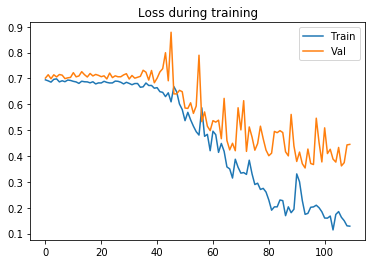

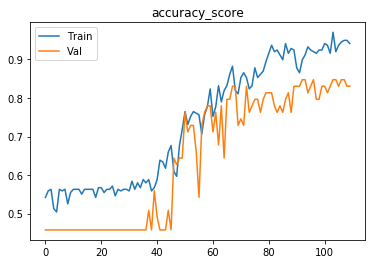

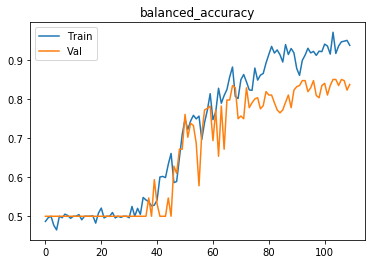

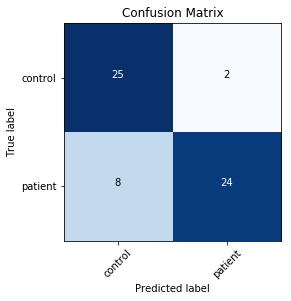

###### Starting inner fold 1
{'model': 'ModelAPIF', 'batch_size': 6, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 1348665
[0,    10] loss: 0.67770
[0,    20] loss: 0.69916
[0,    30] loss: 0.70854
Time elapsed: 0h:0m:24s
train accuracy_score: 55.88 %
train balanced_accuracy: 49.73 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.694906
[1,    10] loss: 0.69194
[1,    20] loss: 0.68588
[1,    30] loss: 0.67485
Time elapsed: 0h:1m:2s
train accuracy_score: 55.04 %
train balanced_accuracy: 50.82 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.715355
[2,    10] loss: 0.67752
[2,    20] loss: 0.69052
[2,    30] loss: 0.70276
Time elapsed: 0h:1m:39s
train accuracy_score: 52.94 %
train balanced_accuracy: 48.31 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.697378
[3,    10] loss: 0.69277
[3,    20] loss: 0.68385
[3,    30] loss: 0.69734
Time elapsed: 0h:2m:16s
train accuracy_score: 56.30 %
train balanced_ac

Time elapsed: 0h:20m:54s
train accuracy_score: 64.29 %
train balanced_accuracy: 63.01 %
val accuracy_score: 49.15 %
val balanced_accuracy: 53.12 %
Val loss: 0.714303
[34,    10] loss: 0.49439
[34,    20] loss: 0.51034
[34,    30] loss: 0.59848
Time elapsed: 0h:21m:33s
train accuracy_score: 76.47 %
train balanced_accuracy: 75.12 %
val accuracy_score: 76.27 %
val balanced_accuracy: 78.12 %
Val loss: 0.548918
[35,    10] loss: 0.49112
[35,    20] loss: 0.66217
[35,    30] loss: 0.46991
Time elapsed: 0h:22m:10s
train accuracy_score: 74.37 %
train balanced_accuracy: 73.58 %
val accuracy_score: 57.63 %
val balanced_accuracy: 60.94 %
Val loss: 0.611921
[36,    10] loss: 0.46685
[36,    20] loss: 0.52081
[36,    30] loss: 0.46225
Time elapsed: 0h:22m:48s
train accuracy_score: 75.21 %
train balanced_accuracy: 74.00 %
val accuracy_score: 83.05 %
val balanced_accuracy: 84.09 %
Val loss: 0.473548
[37,    10] loss: 0.37851
[37,    20] loss: 0.40842
[37,    30] loss: 0.37012
Time elapsed: 0h:23m:25s

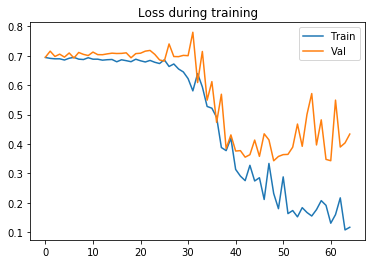

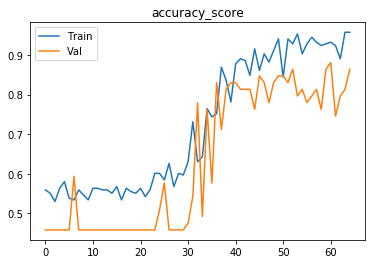

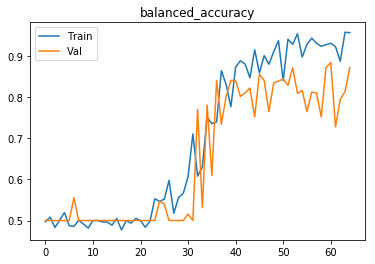

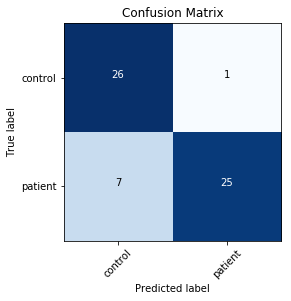

###### Starting inner fold 2
{'model': 'ModelBPIF', 'batch_size': 12, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 301895
[0,    10] loss: 0.69325
Time elapsed: 0h:0m:25s
train accuracy_score: 56.30 %
train balanced_accuracy: 50.00 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.701191
[1,    10] loss: 0.68759
Time elapsed: 0h:1m:4s
train accuracy_score: 56.30 %
train balanced_accuracy: 50.00 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.710832
[2,    10] loss: 0.69031
Time elapsed: 0h:1m:42s
train accuracy_score: 56.30 %
train balanced_accuracy: 50.00 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.707993
[3,    10] loss: 0.68847
Time elapsed: 0h:2m:21s
train accuracy_score: 56.30 %
train balanced_accuracy: 50.00 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.703757
[4,    10] loss: 0.68430
Time elapsed: 0h:2m:59s
train accuracy_score: 56.30 %
train balanced_accuracy: 50.

val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.709385
[43,    10] loss: 0.67653
Time elapsed: 0h:27m:57s
train accuracy_score: 56.30 %
train balanced_accuracy: 50.00 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.715602
[44,    10] loss: 0.68254
Time elapsed: 0h:28m:35s
train accuracy_score: 56.30 %
train balanced_accuracy: 50.00 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.709636
[45,    10] loss: 0.66794
Time elapsed: 0h:29m:13s
train accuracy_score: 56.30 %
train balanced_accuracy: 50.00 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.711499
[46,    10] loss: 0.68069
Time elapsed: 0h:29m:51s
train accuracy_score: 56.30 %
train balanced_accuracy: 50.00 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.712485
[47,    10] loss: 0.66998
Time elapsed: 0h:30m:30s
train accuracy_score: 56.30 %
train balanced_accuracy: 50.00 %
val accuracy_score: 45.76 %
val balanced

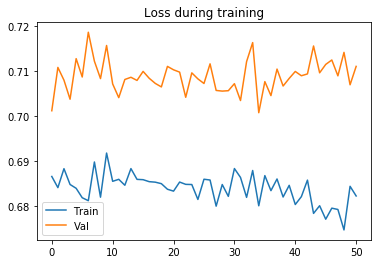

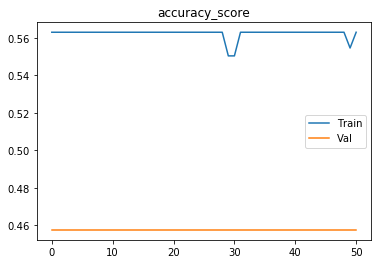

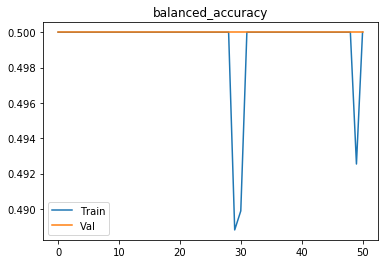

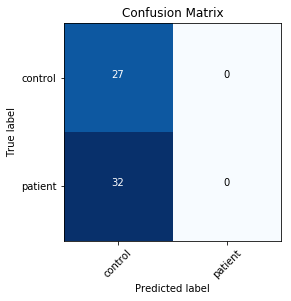

###### Starting inner fold 3
{'model': 'ModelBPIF', 'batch_size': 6, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 301895
[0,    10] loss: 0.69451
[0,    20] loss: 0.69767
[0,    30] loss: 0.69176
Time elapsed: 0h:0m:24s
train accuracy_score: 50.84 %
train balanced_accuracy: 51.39 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.700162
[1,    10] loss: 0.70242
[1,    20] loss: 0.67909
[1,    30] loss: 0.66898
Time elapsed: 0h:1m:1s
train accuracy_score: 56.30 %
train balanced_accuracy: 50.00 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.711717
[2,    10] loss: 0.66043
[2,    20] loss: 0.71680
[2,    30] loss: 0.67934
Time elapsed: 0h:1m:39s
train accuracy_score: 56.30 %
train balanced_accuracy: 50.00 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.700973
[3,    10] loss: 0.69493
[3,    20] loss: 0.69637
[3,    30] loss: 0.69117
Time elapsed: 0h:2m:16s
train accuracy_score: 56.30 %
train balanced_accu

Time elapsed: 0h:20m:54s
train accuracy_score: 63.03 %
train balanced_accuracy: 60.17 %
val accuracy_score: 50.85 %
val balanced_accuracy: 54.69 %
Val loss: 0.716645
[34,    10] loss: 0.65729
[34,    20] loss: 0.61313
[34,    30] loss: 0.60824
Time elapsed: 0h:21m:32s
train accuracy_score: 64.29 %
train balanced_accuracy: 61.18 %
val accuracy_score: 52.54 %
val balanced_accuracy: 56.25 %
Val loss: 0.682535
[35,    10] loss: 0.57909
[35,    20] loss: 0.61106
[35,    30] loss: 0.65508
Time elapsed: 0h:22m:9s
train accuracy_score: 63.87 %
train balanced_accuracy: 60.70 %
val accuracy_score: 66.10 %
val balanced_accuracy: 67.59 %
Val loss: 0.642940
[36,    10] loss: 0.61419
[36,    20] loss: 0.66268
[36,    30] loss: 0.67143
Time elapsed: 0h:22m:46s
train accuracy_score: 65.13 %
train balanced_accuracy: 64.08 %
val accuracy_score: 59.32 %
val balanced_accuracy: 61.63 %
Val loss: 0.655717
[37,    10] loss: 0.55650
[37,    20] loss: 0.56566
[37,    30] loss: 0.57870
Time elapsed: 0h:23m:23s


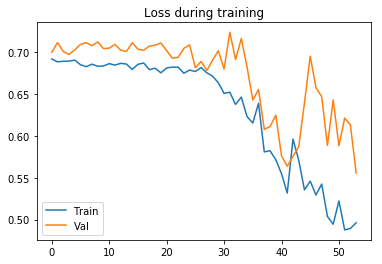

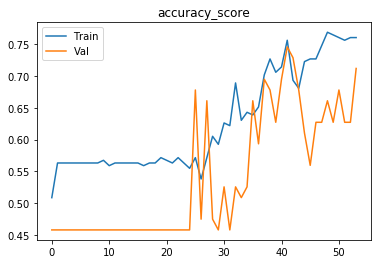

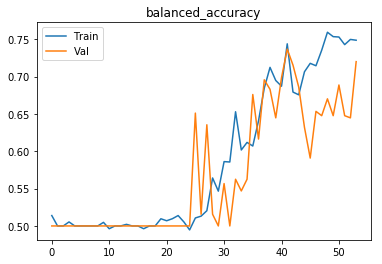

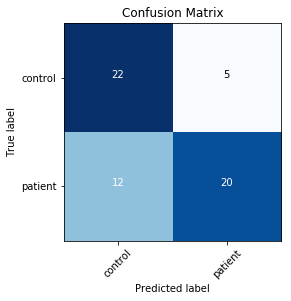

###### Starting inner fold 4
{'model': 'ModelAPIF', 'batch_size': 4, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 1348665
[0,    10] loss: 0.70886
[0,    20] loss: 0.69423
[0,    30] loss: 0.69118
[0,    40] loss: 0.70116
[0,    50] loss: 0.69152
Time elapsed: 0h:0m:24s
train accuracy_score: 52.10 %
train balanced_accuracy: 48.53 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.705786
[1,    10] loss: 0.70158
[1,    20] loss: 0.69044
[1,    30] loss: 0.65359
[1,    40] loss: 0.71121
[1,    50] loss: 0.68786
Time elapsed: 0h:1m:2s
train accuracy_score: 56.30 %
train balanced_accuracy: 50.00 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.701040
[2,    10] loss: 0.69791
[2,    20] loss: 0.66991
[2,    30] loss: 0.68280
[2,    40] loss: 0.65282
[2,    50] loss: 0.76077
Time elapsed: 0h:1m:39s
train accuracy_score: 56.30 %
train balanced_accuracy: 50.00 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.7009

val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.716062
[28,    10] loss: 0.67299
[28,    20] loss: 0.64660
[28,    30] loss: 0.68504
[28,    40] loss: 0.69131
[28,    50] loss: 0.66901
Time elapsed: 0h:17m:43s
train accuracy_score: 55.88 %
train balanced_accuracy: 49.73 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.689890
[29,    10] loss: 0.67254
[29,    20] loss: 0.67697
[29,    30] loss: 0.68582
[29,    40] loss: 0.66734
[29,    50] loss: 0.66105
Time elapsed: 0h:18m:23s
train accuracy_score: 60.08 %
train balanced_accuracy: 55.51 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.709152
[30,    10] loss: 0.66957
[30,    20] loss: 0.70473
[30,    30] loss: 0.66646
[30,    40] loss: 0.64661
[30,    50] loss: 0.65272
Time elapsed: 0h:19m:0s
train accuracy_score: 56.30 %
train balanced_accuracy: 50.22 %
val accuracy_score: 45.76 %
val balanced_accuracy: 50.00 %
Val loss: 0.700796
[31,    10] loss: 0.66635
[31,    2

Time elapsed: 0h:34m:23s
train accuracy_score: 91.60 %
train balanced_accuracy: 91.57 %
val accuracy_score: 79.66 %
val balanced_accuracy: 80.96 %
Val loss: 0.426068
[56,    10] loss: 0.22863
[56,    20] loss: 0.42020
[56,    30] loss: 0.40620
[56,    40] loss: 0.20843
[56,    50] loss: 0.25250
Time elapsed: 0h:35m:0s
train accuracy_score: 89.08 %
train balanced_accuracy: 88.68 %
val accuracy_score: 77.97 %
val balanced_accuracy: 78.53 %
Val loss: 0.363217
[57,    10] loss: 0.27360
[57,    20] loss: 0.26219
[57,    30] loss: 0.25495
[57,    40] loss: 0.18890
[57,    50] loss: 0.25622
Time elapsed: 0h:35m:37s
train accuracy_score: 91.60 %
train balanced_accuracy: 91.57 %
val accuracy_score: 83.05 %
val balanced_accuracy: 83.22 %
Val loss: 0.344429
[58,    10] loss: 0.21818
[58,    20] loss: 0.20860
[58,    30] loss: 0.20865
[58,    40] loss: 0.16463
[58,    50] loss: 0.12383
Time elapsed: 0h:36m:13s
train accuracy_score: 94.54 %
train balanced_accuracy: 94.72 %
val accuracy_score: 77.97

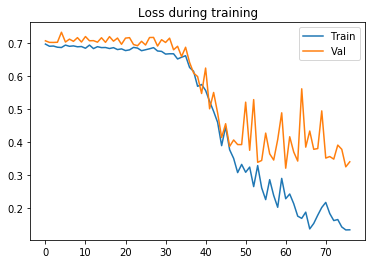

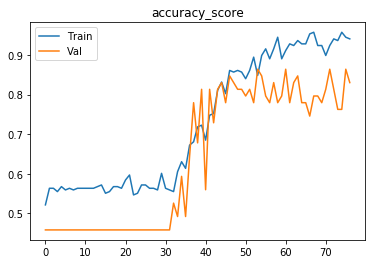

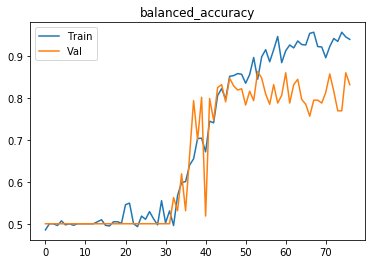

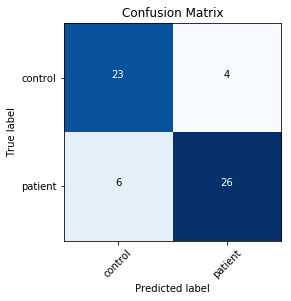

Finished outer fold.
{'final_acc': 0.837962962962963, 'best_acc': 0.8506944444444444, 'final_iter': 110, 'best_iter': 107, 'params': {'model': 'ModelAPIF', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 0}
###### Starting outer fold 1
238
59
Shuffled the data..
###### Starting inner fold 0
{'model': 'ModelAPIF', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 1348665
[0,    10] loss: 0.70216
[0,    20] loss: 0.69672
[0,    30] loss: 0.69096
[0,    40] loss: 0.69314
[0,    50] loss: 0.71294
Time elapsed: 0h:0m:25s
train accuracy_score: 42.02 %
train balanced_accuracy: 39.76 %
val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.692006
[1,    10] loss: 0.68432
[1,    20] loss: 0.69078
[1,    30] loss: 0.70609
[1,    40] loss: 0.70907
[1,    50] loss: 0.69048
Time elapsed: 0h:1m:5s
train accuracy_score: 47.48 %
train balanced_accuracy: 45.22 %
val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.687928
[2,  

val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.672024
[27,    10] loss: 0.68728
[27,    20] loss: 0.68671
[27,    30] loss: 0.66759
[27,    40] loss: 0.68374
[27,    50] loss: 0.67370
Time elapsed: 0h:17m:44s
train accuracy_score: 54.20 %
train balanced_accuracy: 50.07 %
val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.671861
[28,    10] loss: 0.69698
[28,    20] loss: 0.68818
[28,    30] loss: 0.68508
[28,    40] loss: 0.69436
[28,    50] loss: 0.65558
Time elapsed: 0h:18m:24s
train accuracy_score: 54.20 %
train balanced_accuracy: 51.21 %
val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.667946
[29,    10] loss: 0.65993
[29,    20] loss: 0.69840
[29,    30] loss: 0.68571
[29,    40] loss: 0.68432
[29,    50] loss: 0.70137
Time elapsed: 0h:19m:4s
train accuracy_score: 56.30 %
train balanced_accuracy: 53.86 %
val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.665624
[30,    10] loss: 0.69231
[30,    2

Time elapsed: 0h:35m:57s
train accuracy_score: 83.19 %
train balanced_accuracy: 83.00 %
val accuracy_score: 71.19 %
val balanced_accuracy: 66.00 %
Val loss: 0.566023
[55,    10] loss: 0.52347
[55,    20] loss: 0.40727
[55,    30] loss: 0.36140
[55,    40] loss: 0.40672
[55,    50] loss: 0.40737
Time elapsed: 0h:36m:40s
train accuracy_score: 80.25 %
train balanced_accuracy: 80.08 %
val accuracy_score: 79.66 %
val balanced_accuracy: 76.00 %
Val loss: 0.353902
[56,    10] loss: 0.28259
[56,    20] loss: 0.26742
[56,    30] loss: 0.41322
[56,    40] loss: 0.39492
[56,    50] loss: 0.29548
Time elapsed: 0h:37m:32s
train accuracy_score: 85.29 %
train balanced_accuracy: 85.15 %
val accuracy_score: 88.14 %
val balanced_accuracy: 86.53 %
Val loss: 0.287755
[57,    10] loss: 0.26089
[57,    20] loss: 0.26346
[57,    30] loss: 0.37143
[57,    40] loss: 0.34112
[57,    50] loss: 0.32898
Time elapsed: 0h:38m:29s
train accuracy_score: 87.39 %
train balanced_accuracy: 87.23 %
val accuracy_score: 86.4

[82,    30] loss: 0.32259
[82,    40] loss: 0.16879
[82,    50] loss: 0.14511
Time elapsed: 0h:55m:20s
train accuracy_score: 93.28 %
train balanced_accuracy: 93.30 %
val accuracy_score: 91.53 %
val balanced_accuracy: 92.65 %
Val loss: 0.209300
[83,    10] loss: 0.18754
[83,    20] loss: 0.22511
[83,    30] loss: 0.15753
[83,    40] loss: 0.35917
[83,    50] loss: 0.26050
Time elapsed: 0h:55m:57s
train accuracy_score: 92.44 %
train balanced_accuracy: 92.38 %
val accuracy_score: 91.53 %
val balanced_accuracy: 92.65 %
Val loss: 0.219391
[84,    10] loss: 0.15196
[84,    20] loss: 0.13338
[84,    30] loss: 0.28255
[84,    40] loss: 0.23201
[84,    50] loss: 0.22842
Time elapsed: 0h:56m:33s
train accuracy_score: 91.60 %
train balanced_accuracy: 91.61 %
val accuracy_score: 91.53 %
val balanced_accuracy: 92.65 %
Val loss: 0.227272
[85,    10] loss: 0.16974
[85,    20] loss: 0.32666
[85,    30] loss: 0.31293
[85,    40] loss: 0.18403
[85,    50] loss: 0.20871
Time elapsed: 0h:57m:9s
train accu

[110,    10] loss: 0.15934
[110,    20] loss: 0.07773
[110,    30] loss: 0.14684
[110,    40] loss: 0.14528
[110,    50] loss: 0.15569
Time elapsed: 1h:12m:39s
train accuracy_score: 93.28 %
train balanced_accuracy: 93.16 %
val accuracy_score: 91.53 %
val balanced_accuracy: 92.65 %
Val loss: 0.269905
[111,    10] loss: 0.23338
[111,    20] loss: 0.09489
[111,    30] loss: 0.15827
[111,    40] loss: 0.06758
[111,    50] loss: 0.08805
Time elapsed: 1h:13m:15s
train accuracy_score: 94.96 %
train balanced_accuracy: 94.85 %
val accuracy_score: 93.22 %
val balanced_accuracy: 94.12 %
Val loss: 0.155504
[112,    10] loss: 0.18159
[112,    20] loss: 0.09379
[112,    30] loss: 0.16870
[112,    40] loss: 0.09974
[112,    50] loss: 0.13350
Time elapsed: 1h:13m:51s
train accuracy_score: 95.38 %
train balanced_accuracy: 95.45 %
val accuracy_score: 93.22 %
val balanced_accuracy: 94.12 %
Val loss: 0.154598
[113,    10] loss: 0.13275
[113,    20] loss: 0.14478
[113,    30] loss: 0.19967
[113,    40] los

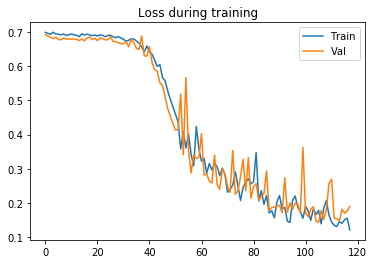

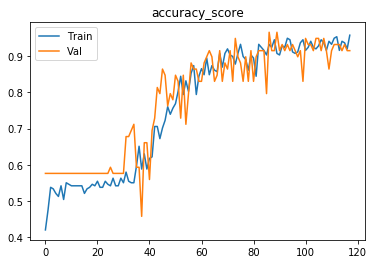

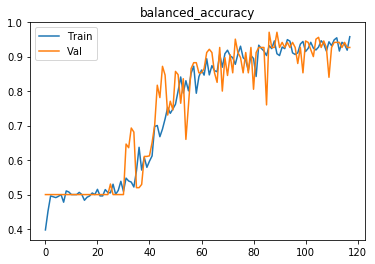

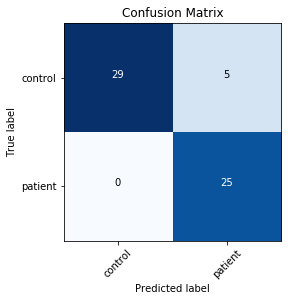

###### Starting inner fold 1
{'model': 'ModelAPIF', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 1348665
[0,    10] loss: 0.69556
Time elapsed: 0h:0m:25s
train accuracy_score: 51.26 %
train balanced_accuracy: 47.86 %
val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.683177
[1,    10] loss: 0.68937
Time elapsed: 0h:1m:1s
train accuracy_score: 48.74 %
train balanced_accuracy: 47.38 %
val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.678728
[2,    10] loss: 0.70328
Time elapsed: 0h:1m:38s
train accuracy_score: 54.20 %
train balanced_accuracy: 50.00 %
val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.684948
[3,    10] loss: 0.69128
Time elapsed: 0h:2m:15s
train accuracy_score: 54.20 %
train balanced_accuracy: 50.00 %
val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.680064
[4,    10] loss: 0.69471
Time elapsed: 0h:2m:52s
train accuracy_score: 54.20 %
train balanced_accuracy: 5

val accuracy_score: 59.32 %
val balanced_accuracy: 64.71 %
Val loss: 0.657727
[43,    10] loss: 0.63455
Time elapsed: 0h:27m:35s
train accuracy_score: 64.29 %
train balanced_accuracy: 62.22 %
val accuracy_score: 81.36 %
val balanced_accuracy: 79.59 %
Val loss: 0.604351
[44,    10] loss: 0.61212
Time elapsed: 0h:28m:12s
train accuracy_score: 65.13 %
train balanced_accuracy: 63.63 %
val accuracy_score: 42.37 %
val balanced_accuracy: 50.00 %
Val loss: 0.702915
[45,    10] loss: 0.65140
Time elapsed: 0h:28m:49s
train accuracy_score: 64.29 %
train balanced_accuracy: 63.50 %
val accuracy_score: 42.37 %
val balanced_accuracy: 50.00 %
Val loss: 0.721026
[46,    10] loss: 0.61629
Time elapsed: 0h:29m:27s
train accuracy_score: 65.55 %
train balanced_accuracy: 65.02 %
val accuracy_score: 86.44 %
val balanced_accuracy: 86.65 %
Val loss: 0.569829
[47,    10] loss: 0.56890
Time elapsed: 0h:30m:5s
train accuracy_score: 65.55 %
train balanced_accuracy: 64.73 %
val accuracy_score: 84.75 %
val balanced_

val accuracy_score: 91.53 %
val balanced_accuracy: 92.65 %
Val loss: 0.179399
[86,    10] loss: 0.18743
Time elapsed: 0h:54m:32s
train accuracy_score: 93.70 %
train balanced_accuracy: 93.76 %
val accuracy_score: 79.66 %
val balanced_accuracy: 76.00 %
Val loss: 0.305491
[87,    10] loss: 0.30230
Time elapsed: 0h:55m:10s
train accuracy_score: 86.55 %
train balanced_accuracy: 86.32 %
val accuracy_score: 86.44 %
val balanced_accuracy: 88.24 %
Val loss: 0.363480
[88,    10] loss: 0.23429
Time elapsed: 0h:55m:48s
train accuracy_score: 93.28 %
train balanced_accuracy: 93.23 %
val accuracy_score: 89.83 %
val balanced_accuracy: 91.18 %
Val loss: 0.223331
[89,    10] loss: 0.13792
Time elapsed: 0h:56m:26s
train accuracy_score: 94.96 %
train balanced_accuracy: 94.99 %
val accuracy_score: 89.83 %
val balanced_accuracy: 91.18 %
Val loss: 0.214537
[90,    10] loss: 0.11312
Time elapsed: 0h:57m:4s
train accuracy_score: 95.80 %
train balanced_accuracy: 95.84 %
val accuracy_score: 91.53 %
val balanced_

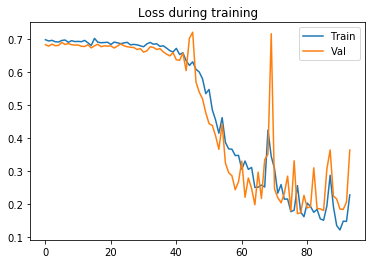

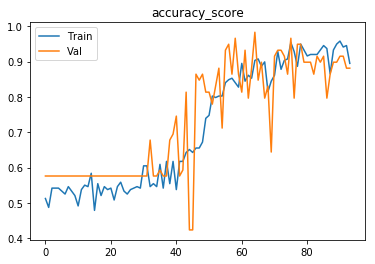

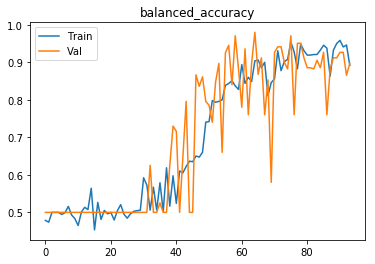

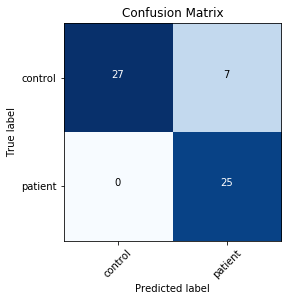

###### Starting inner fold 2
{'model': 'ModelBPIF', 'batch_size': 6, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 301895
[0,    10] loss: 0.69277
[0,    20] loss: 0.70325
[0,    30] loss: 0.69400
Time elapsed: 0h:0m:24s
train accuracy_score: 49.16 %
train balanced_accuracy: 51.75 %
val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.690197
[1,    10] loss: 0.69256
[1,    20] loss: 0.69623
[1,    30] loss: 0.68897
Time elapsed: 0h:1m:1s
train accuracy_score: 54.20 %
train balanced_accuracy: 50.00 %
val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.683438
[2,    10] loss: 0.69649
[2,    20] loss: 0.68734
[2,    30] loss: 0.69107
Time elapsed: 0h:1m:37s
train accuracy_score: 54.20 %
train balanced_accuracy: 50.00 %
val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.681337
[3,    10] loss: 0.67764
[3,    20] loss: 0.66268
[3,    30] loss: 0.73655
Time elapsed: 0h:2m:14s
train accuracy_score: 54.20 %
train balanced_accu

Time elapsed: 0h:20m:38s
train accuracy_score: 56.72 %
train balanced_accuracy: 53.11 %
val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.669343
[34,    10] loss: 0.67602
[34,    20] loss: 0.68762
[34,    30] loss: 0.67682
Time elapsed: 0h:21m:14s
train accuracy_score: 54.20 %
train balanced_accuracy: 50.50 %
val accuracy_score: 59.32 %
val balanced_accuracy: 52.53 %
Val loss: 0.668092
[35,    10] loss: 0.68144
[35,    20] loss: 0.66915
[35,    30] loss: 0.66321
Time elapsed: 0h:21m:50s
train accuracy_score: 56.30 %
train balanced_accuracy: 53.43 %
val accuracy_score: 57.63 %
val balanced_accuracy: 50.53 %
Val loss: 0.664688
[36,    10] loss: 0.66164
[36,    20] loss: 0.68858
[36,    30] loss: 0.68665
Time elapsed: 0h:22m:25s
train accuracy_score: 58.40 %
train balanced_accuracy: 56.37 %
val accuracy_score: 66.10 %
val balanced_accuracy: 64.24 %
Val loss: 0.672818
[37,    10] loss: 0.68728
[37,    20] loss: 0.67347
[37,    30] loss: 0.70120
Time elapsed: 0h:23m:2s


[67,    10] loss: 0.53312
[67,    20] loss: 0.54990
[67,    30] loss: 0.60403
Time elapsed: 0h:41m:3s
train accuracy_score: 72.27 %
train balanced_accuracy: 71.86 %
val accuracy_score: 79.66 %
val balanced_accuracy: 78.65 %
Val loss: 0.496303
[68,    10] loss: 0.58906
[68,    20] loss: 0.54256
[68,    30] loss: 0.62454
Time elapsed: 0h:41m:41s
train accuracy_score: 68.07 %
train balanced_accuracy: 66.92 %
val accuracy_score: 79.66 %
val balanced_accuracy: 78.12 %
Val loss: 0.502578
[69,    10] loss: 0.56465
[69,    20] loss: 0.59458
[69,    30] loss: 0.54979
Time elapsed: 0h:42m:17s
train accuracy_score: 69.75 %
train balanced_accuracy: 68.89 %
val accuracy_score: 79.66 %
val balanced_accuracy: 78.65 %
Val loss: 0.492733
[70,    10] loss: 0.58909
[70,    20] loss: 0.57962
[70,    30] loss: 0.61299
Time elapsed: 0h:42m:53s
train accuracy_score: 72.27 %
train balanced_accuracy: 72.07 %
val accuracy_score: 77.97 %
val balanced_accuracy: 75.06 %
Val loss: 0.488030
[71,    10] loss: 0.60613

val accuracy_score: 84.75 %
val balanced_accuracy: 83.59 %
Val loss: 0.348988
[101,    10] loss: 0.52107
[101,    20] loss: 0.50114
[101,    30] loss: 0.39915
Time elapsed: 1h:1m:50s
train accuracy_score: 81.09 %
train balanced_accuracy: 80.85 %
val accuracy_score: 88.14 %
val balanced_accuracy: 88.12 %
Val loss: 0.350452
[102,    10] loss: 0.48308
[102,    20] loss: 0.50657
[102,    30] loss: 0.41293
Time elapsed: 1h:2m:27s
train accuracy_score: 77.73 %
train balanced_accuracy: 77.47 %
val accuracy_score: 86.44 %
val balanced_accuracy: 85.59 %
Val loss: 0.348464
[103,    10] loss: 0.40122
[103,    20] loss: 0.52879
[103,    30] loss: 0.41616
Time elapsed: 1h:3m:4s
train accuracy_score: 79.83 %
train balanced_accuracy: 79.62 %
val accuracy_score: 83.05 %
val balanced_accuracy: 83.71 %
Val loss: 0.354992
[104,    10] loss: 0.45437
[104,    20] loss: 0.47740
[104,    30] loss: 0.44183
Time elapsed: 1h:3m:40s
train accuracy_score: 78.99 %
train balanced_accuracy: 78.63 %
val accuracy_scor

[134,    10] loss: 0.30469
[134,    20] loss: 0.40803
[134,    30] loss: 0.33266
Time elapsed: 1h:21m:51s
train accuracy_score: 83.19 %
train balanced_accuracy: 83.07 %
val accuracy_score: 89.83 %
val balanced_accuracy: 88.53 %
Val loss: 0.252240
[135,    10] loss: 0.42432
[135,    20] loss: 0.36381
[135,    30] loss: 0.37769
Time elapsed: 1h:22m:27s
train accuracy_score: 81.51 %
train balanced_accuracy: 81.24 %
val accuracy_score: 88.14 %
val balanced_accuracy: 87.06 %
Val loss: 0.242621
[136,    10] loss: 0.42080
[136,    20] loss: 0.32871
[136,    30] loss: 0.30698
Time elapsed: 1h:23m:3s
train accuracy_score: 84.45 %
train balanced_accuracy: 84.31 %
val accuracy_score: 89.83 %
val balanced_accuracy: 89.06 %
Val loss: 0.242519
[137,    10] loss: 0.33872
[137,    20] loss: 0.28238
[137,    30] loss: 0.41537
Time elapsed: 1h:23m:39s
train accuracy_score: 83.61 %
train balanced_accuracy: 83.46 %
val accuracy_score: 89.83 %
val balanced_accuracy: 88.53 %
Val loss: 0.251192
[138,    10] 

[167,    30] loss: 0.25697
Time elapsed: 1h:41m:52s
train accuracy_score: 85.29 %
train balanced_accuracy: 84.94 %
val accuracy_score: 89.83 %
val balanced_accuracy: 89.06 %
Val loss: 0.202761
[168,    10] loss: 0.38085
[168,    20] loss: 0.34419
[168,    30] loss: 0.32691
Time elapsed: 1h:42m:28s
train accuracy_score: 84.45 %
train balanced_accuracy: 84.52 %
val accuracy_score: 88.14 %
val balanced_accuracy: 87.06 %
Val loss: 0.203577
[169,    10] loss: 0.37201
[169,    20] loss: 0.28901
[169,    30] loss: 0.31785
Time elapsed: 1h:43m:5s
train accuracy_score: 87.39 %
train balanced_accuracy: 87.23 %
val accuracy_score: 88.14 %
val balanced_accuracy: 89.71 %
Val loss: 0.289865
[170,    10] loss: 0.32924
[170,    20] loss: 0.32034
[170,    30] loss: 0.37677
Time elapsed: 1h:43m:42s
train accuracy_score: 86.13 %
train balanced_accuracy: 86.00 %
val accuracy_score: 89.83 %
val balanced_accuracy: 88.00 %
Val loss: 0.219205
[171,    10] loss: 0.25759
[171,    20] loss: 0.24068
[171,    30] 

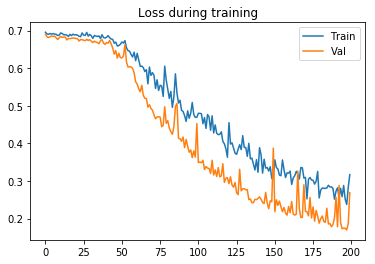

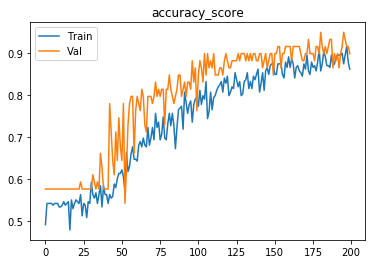

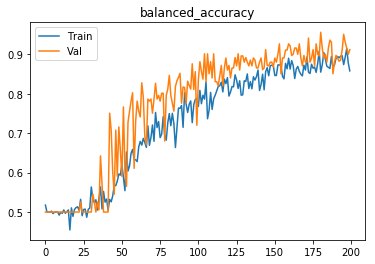

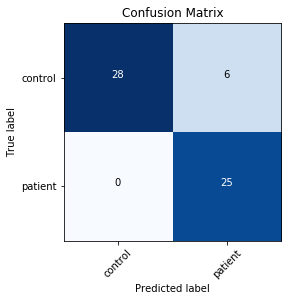

###### Starting inner fold 3
{'model': 'ModelBPIF', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 301895
[0,    10] loss: 0.68590
[0,    20] loss: 0.68333
[0,    30] loss: 0.70479
[0,    40] loss: 0.70467
[0,    50] loss: 0.69006
Time elapsed: 0h:0m:24s
train accuracy_score: 53.78 %
train balanced_accuracy: 49.61 %
val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.683940
[1,    10] loss: 0.70270
[1,    20] loss: 0.68699
[1,    30] loss: 0.69320
[1,    40] loss: 0.68228
[1,    50] loss: 0.68337
Time elapsed: 0h:0m:59s
train accuracy_score: 54.20 %
train balanced_accuracy: 50.00 %
val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.685794
[2,    10] loss: 0.68114
[2,    20] loss: 0.70726
[2,    30] loss: 0.68322
[2,    40] loss: 0.68904
[2,    50] loss: 0.70219
Time elapsed: 0h:1m:36s
train accuracy_score: 53.78 %
train balanced_accuracy: 50.61 %
val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.681

val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.681338
[28,    10] loss: 0.70421
[28,    20] loss: 0.67576
[28,    30] loss: 0.69624
[28,    40] loss: 0.68086
[28,    50] loss: 0.69377
Time elapsed: 0h:17m:17s
train accuracy_score: 54.20 %
train balanced_accuracy: 50.00 %
val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.681176
[29,    10] loss: 0.69867
[29,    20] loss: 0.69722
[29,    30] loss: 0.68603
[29,    40] loss: 0.68204
[29,    50] loss: 0.67567
Time elapsed: 0h:17m:54s
train accuracy_score: 54.20 %
train balanced_accuracy: 50.00 %
val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.678868
[30,    10] loss: 0.69413
[30,    20] loss: 0.68921
[30,    30] loss: 0.69262
[30,    40] loss: 0.67360
[30,    50] loss: 0.67507
Time elapsed: 0h:18m:31s
train accuracy_score: 55.04 %
train balanced_accuracy: 51.06 %
val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.670339
[31,    10] loss: 0.67198
[31,    

Time elapsed: 0h:33m:41s
train accuracy_score: 71.85 %
train balanced_accuracy: 71.04 %
val accuracy_score: 76.27 %
val balanced_accuracy: 74.12 %
Val loss: 0.428308
[56,    10] loss: 0.55364
[56,    20] loss: 0.58285
[56,    30] loss: 0.47057
[56,    40] loss: 0.48265
[56,    50] loss: 0.53467
Time elapsed: 0h:34m:16s
train accuracy_score: 76.47 %
train balanced_accuracy: 76.23 %
val accuracy_score: 81.36 %
val balanced_accuracy: 79.06 %
Val loss: 0.416586
[57,    10] loss: 0.44030
[57,    20] loss: 0.47841
[57,    30] loss: 0.46907
[57,    40] loss: 0.52372
[57,    50] loss: 0.50002
Time elapsed: 0h:34m:53s
train accuracy_score: 75.21 %
train balanced_accuracy: 74.36 %
val accuracy_score: 83.05 %
val balanced_accuracy: 84.24 %
Val loss: 0.428293
[58,    10] loss: 0.65721
[58,    20] loss: 0.50507
[58,    30] loss: 0.46873
[58,    40] loss: 0.36942
[58,    50] loss: 0.61361
Time elapsed: 0h:35m:30s
train accuracy_score: 75.63 %
train balanced_accuracy: 75.46 %
val accuracy_score: 88.1

[83,    30] loss: 0.25874
[83,    40] loss: 0.18370
[83,    50] loss: 0.27503
Time elapsed: 0h:50m:41s
train accuracy_score: 88.66 %
train balanced_accuracy: 88.54 %
val accuracy_score: 89.83 %
val balanced_accuracy: 88.53 %
Val loss: 0.201756
[84,    10] loss: 0.23611
[84,    20] loss: 0.27985
[84,    30] loss: 0.25786
[84,    40] loss: 0.31543
[84,    50] loss: 0.35394
Time elapsed: 0h:51m:18s
train accuracy_score: 88.66 %
train balanced_accuracy: 88.47 %
val accuracy_score: 91.53 %
val balanced_accuracy: 90.53 %
Val loss: 0.226916
[85,    10] loss: 0.25672
[85,    20] loss: 0.22157
[85,    30] loss: 0.30707
[85,    40] loss: 0.26847
[85,    50] loss: 0.28393
Time elapsed: 0h:51m:54s
train accuracy_score: 87.39 %
train balanced_accuracy: 87.31 %
val accuracy_score: 91.53 %
val balanced_accuracy: 91.06 %
Val loss: 0.212542
[86,    10] loss: 0.25516
[86,    20] loss: 0.27464
[86,    30] loss: 0.24474
[86,    40] loss: 0.27826
[86,    50] loss: 0.31391
Time elapsed: 0h:52m:30s
train acc

val accuracy_score: 94.92 %
val balanced_accuracy: 95.06 %
Val loss: 0.200647
[111,    10] loss: 0.18839
[111,    20] loss: 0.15666
[111,    30] loss: 0.08832
[111,    40] loss: 0.07010
[111,    50] loss: 0.23936
Time elapsed: 1h:7m:41s
train accuracy_score: 94.54 %
train balanced_accuracy: 94.53 %
val accuracy_score: 94.92 %
val balanced_accuracy: 95.06 %
Val loss: 0.200380
Early stopping in epoch 112
Total time elapsed: 1h:7m:53s
Writing model to disk...
Best result during training: 0.95. Saving model..
Finished inner fold.


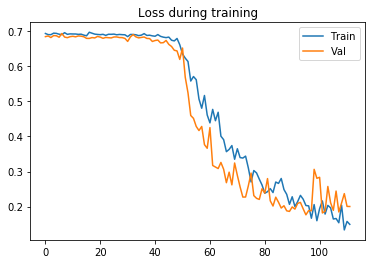

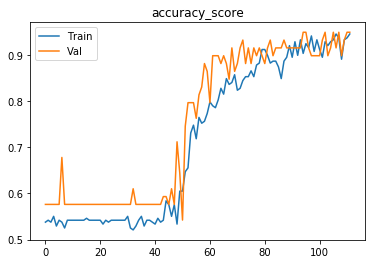

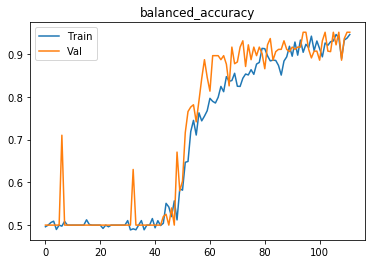

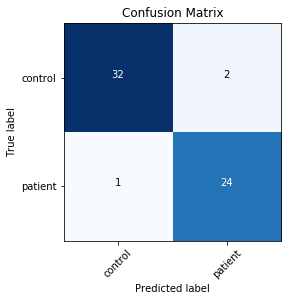

###### Starting inner fold 4
{'model': 'ModelAPIF', 'batch_size': 12, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 1348665
[0,    10] loss: 0.69873
Time elapsed: 0h:0m:25s
train accuracy_score: 53.78 %
train balanced_accuracy: 49.97 %
val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.680845
[1,    10] loss: 0.70807
Time elapsed: 0h:1m:2s
train accuracy_score: 54.62 %
train balanced_accuracy: 50.53 %
val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.686727
[2,    10] loss: 0.68623
Time elapsed: 0h:1m:39s
train accuracy_score: 54.20 %
train balanced_accuracy: 50.07 %
val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.681478
[3,    10] loss: 0.69582
Time elapsed: 0h:2m:17s
train accuracy_score: 52.52 %
train balanced_accuracy: 49.94 %
val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.680329
[4,    10] loss: 0.71080
Time elapsed: 0h:2m:55s
train accuracy_score: 54.62 %
train balanced_accuracy: 5

Time elapsed: 0h:26m:44s
train accuracy_score: 53.36 %
train balanced_accuracy: 51.71 %
val accuracy_score: 61.02 %
val balanced_accuracy: 54.00 %
Val loss: 0.648755
[43,    10] loss: 0.67537
Time elapsed: 0h:27m:23s
train accuracy_score: 64.29 %
train balanced_accuracy: 62.36 %
val accuracy_score: 61.02 %
val balanced_accuracy: 54.00 %
Val loss: 0.653856
[44,    10] loss: 0.68031
Time elapsed: 0h:28m:0s
train accuracy_score: 57.56 %
train balanced_accuracy: 56.16 %
val accuracy_score: 57.63 %
val balanced_accuracy: 50.00 %
Val loss: 0.649210
[45,    10] loss: 0.66191
Time elapsed: 0h:28m:37s
train accuracy_score: 58.82 %
train balanced_accuracy: 55.83 %
val accuracy_score: 69.49 %
val balanced_accuracy: 69.29 %
Val loss: 0.652477
[46,    10] loss: 0.65787
Time elapsed: 0h:29m:15s
train accuracy_score: 61.34 %
train balanced_accuracy: 59.86 %
val accuracy_score: 61.02 %
val balanced_accuracy: 54.00 %
Val loss: 0.633323
[47,    10] loss: 0.64558
Time elapsed: 0h:29m:53s
train accuracy_s

[85,    10] loss: 0.23359
Time elapsed: 0h:53m:48s
train accuracy_score: 91.60 %
train balanced_accuracy: 91.39 %
val accuracy_score: 94.92 %
val balanced_accuracy: 95.59 %
Val loss: 0.175981
[86,    10] loss: 0.19736
Time elapsed: 0h:54m:26s
train accuracy_score: 93.28 %
train balanced_accuracy: 93.44 %
val accuracy_score: 93.22 %
val balanced_accuracy: 93.06 %
Val loss: 0.180478
[87,    10] loss: 0.21184
Time elapsed: 0h:55m:4s
train accuracy_score: 89.50 %
train balanced_accuracy: 89.24 %
val accuracy_score: 79.66 %
val balanced_accuracy: 76.53 %
Val loss: 0.326880
[88,    10] loss: 0.24638
Time elapsed: 0h:55m:43s
train accuracy_score: 91.60 %
train balanced_accuracy: 91.39 %
val accuracy_score: 91.53 %
val balanced_accuracy: 92.65 %
Val loss: 0.275023
[89,    10] loss: 0.15977
Time elapsed: 0h:56m:20s
train accuracy_score: 94.12 %
train balanced_accuracy: 94.15 %
val accuracy_score: 91.53 %
val balanced_accuracy: 90.53 %
Val loss: 0.191539
[90,    10] loss: 0.13650
Time elapsed: 0

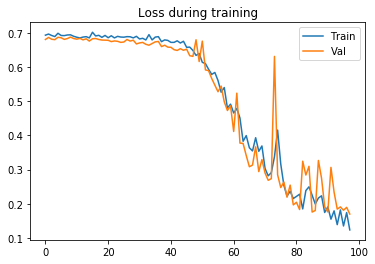

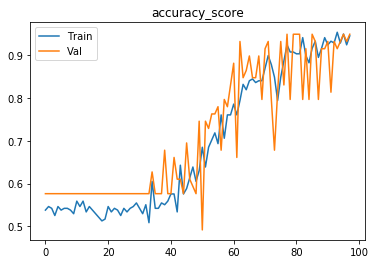

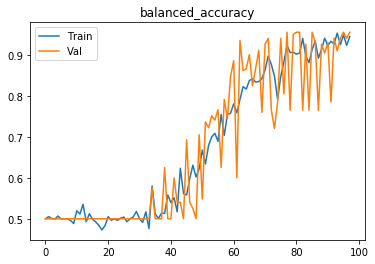

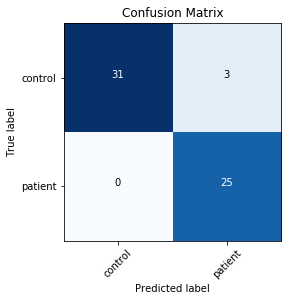

Finished outer fold.
{'final_acc': 0.9505882352941176, 'best_acc': 0.9505882352941176, 'final_iter': 112, 'best_iter': 112, 'params': {'model': 'ModelBPIF', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 3}
###### Starting outer fold 2
238
59
Shuffled the data..
###### Starting inner fold 0
{'model': 'ModelAPIF', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 1348665
[0,    10] loss: 0.71240
[0,    20] loss: 0.67319
[0,    30] loss: 0.62958
[0,    40] loss: 0.75727
[0,    50] loss: 0.67334
Time elapsed: 0h:0m:24s
train accuracy_score: 56.72 %
train balanced_accuracy: 52.78 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.689160
[1,    10] loss: 0.70003
[1,    20] loss: 0.67242
[1,    30] loss: 0.71848
[1,    40] loss: 0.66551
[1,    50] loss: 0.66216
Time elapsed: 0h:1m:0s
train accuracy_score: 53.78 %
train balanced_accuracy: 49.06 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.720361
[2, 

val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.657953
[27,    10] loss: 0.66362
[27,    20] loss: 0.66108
[27,    30] loss: 0.66610
[27,    40] loss: 0.60224
[27,    50] loss: 0.66216
Time elapsed: 0h:16m:40s
train accuracy_score: 62.61 %
train balanced_accuracy: 56.72 %
val accuracy_score: 69.49 %
val balanced_accuracy: 66.61 %
Val loss: 0.644451
[28,    10] loss: 0.64985
[28,    20] loss: 0.65955
[28,    30] loss: 0.63805
[28,    40] loss: 0.55786
[28,    50] loss: 0.72341
Time elapsed: 0h:17m:17s
train accuracy_score: 58.82 %
train balanced_accuracy: 55.65 %
val accuracy_score: 67.80 %
val balanced_accuracy: 63.87 %
Val loss: 0.631824
[29,    10] loss: 0.62235
[29,    20] loss: 0.71214
[29,    30] loss: 0.62055
[29,    40] loss: 0.61928
[29,    50] loss: 0.63821
Time elapsed: 0h:17m:53s
train accuracy_score: 65.97 %
train balanced_accuracy: 61.46 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.649877
[30,    10] loss: 0.62748
[30,    

Time elapsed: 0h:32m:54s
train accuracy_score: 92.86 %
train balanced_accuracy: 92.49 %
val accuracy_score: 89.83 %
val balanced_accuracy: 90.09 %
Val loss: 0.214799
[55,    10] loss: 0.17011
[55,    20] loss: 0.18607
[55,    30] loss: 0.29524
[55,    40] loss: 0.13120
[55,    50] loss: 0.14782
Time elapsed: 0h:33m:31s
train accuracy_score: 91.60 %
train balanced_accuracy: 91.27 %
val accuracy_score: 88.14 %
val balanced_accuracy: 86.54 %
Val loss: 0.261238
[56,    10] loss: 0.22173
[56,    20] loss: 0.15164
[56,    30] loss: 0.28718
[56,    40] loss: 0.11347
[56,    50] loss: 0.07894
Time elapsed: 0h:34m:7s
train accuracy_score: 94.54 %
train balanced_accuracy: 94.08 %
val accuracy_score: 88.14 %
val balanced_accuracy: 88.99 %
Val loss: 0.241386
[57,    10] loss: 0.19422
[57,    20] loss: 0.06960
[57,    30] loss: 0.17329
[57,    40] loss: 0.07066
[57,    50] loss: 0.28174
Time elapsed: 0h:34m:43s
train accuracy_score: 94.54 %
train balanced_accuracy: 94.61 %
val accuracy_score: 93.22

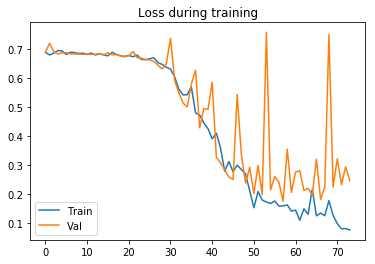

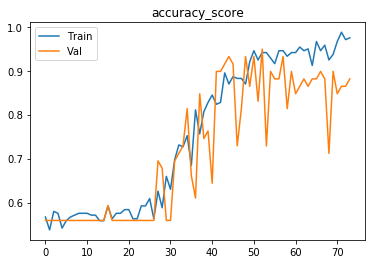

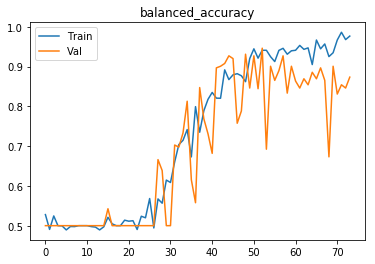

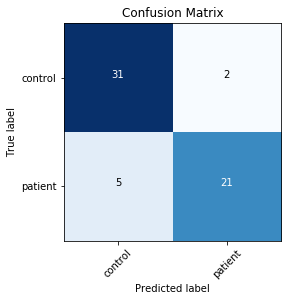

###### Starting inner fold 1
{'model': 'ModelAPIF', 'batch_size': 12, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 1348665
[0,    10] loss: 0.69846
Time elapsed: 0h:0m:25s
train accuracy_score: 53.36 %
train balanced_accuracy: 51.68 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.687385
[1,    10] loss: 0.68505
Time elapsed: 0h:1m:2s
train accuracy_score: 57.56 %
train balanced_accuracy: 50.00 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.683367
[2,    10] loss: 0.67527
Time elapsed: 0h:1m:40s
train accuracy_score: 56.72 %
train balanced_accuracy: 49.40 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.687370
[3,    10] loss: 0.68628
Time elapsed: 0h:2m:17s
train accuracy_score: 57.56 %
train balanced_accuracy: 50.13 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.683188
[4,    10] loss: 0.66854
Time elapsed: 0h:2m:53s
train accuracy_score: 57.56 %
train balanced_accuracy: 50

Time elapsed: 0h:26m:27s
train accuracy_score: 57.56 %
train balanced_accuracy: 50.00 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.678885
[43,    10] loss: 0.67789
Time elapsed: 0h:27m:5s
train accuracy_score: 57.98 %
train balanced_accuracy: 51.41 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.671976
[44,    10] loss: 0.66823
Time elapsed: 0h:27m:43s
train accuracy_score: 58.40 %
train balanced_accuracy: 51.38 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.671277
[45,    10] loss: 0.66863
Time elapsed: 0h:28m:20s
train accuracy_score: 57.98 %
train balanced_accuracy: 51.02 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.667376
[46,    10] loss: 0.66274
Time elapsed: 0h:28m:58s
train accuracy_score: 59.24 %
train balanced_accuracy: 52.11 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.668097
[47,    10] loss: 0.68377
Time elapsed: 0h:29m:35s
train accuracy_s

[85,    10] loss: 0.43293
Time elapsed: 0h:53m:5s
train accuracy_score: 84.03 %
train balanced_accuracy: 83.27 %
val accuracy_score: 81.36 %
val balanced_accuracy: 79.66 %
Val loss: 0.425588
[86,    10] loss: 0.44017
Time elapsed: 0h:53m:42s
train accuracy_score: 80.25 %
train balanced_accuracy: 79.20 %
val accuracy_score: 86.44 %
val balanced_accuracy: 85.43 %
Val loss: 0.408344
[87,    10] loss: 0.40399
Time elapsed: 0h:54m:18s
train accuracy_score: 78.15 %
train balanced_accuracy: 76.86 %
val accuracy_score: 89.83 %
val balanced_accuracy: 90.09 %
Val loss: 0.378366
[88,    10] loss: 0.46181
Time elapsed: 0h:54m:55s
train accuracy_score: 78.57 %
train balanced_accuracy: 77.61 %
val accuracy_score: 89.83 %
val balanced_accuracy: 89.69 %
Val loss: 0.369714
[89,    10] loss: 0.34307
Time elapsed: 0h:55m:32s
train accuracy_score: 83.61 %
train balanced_accuracy: 83.16 %
val accuracy_score: 88.14 %
val balanced_accuracy: 88.17 %
Val loss: 0.355893
[90,    10] loss: 0.39836
Time elapsed: 0

[128,    10] loss: 0.20818
Time elapsed: 1h:20m:0s
train accuracy_score: 89.92 %
train balanced_accuracy: 90.20 %
val accuracy_score: 83.05 %
val balanced_accuracy: 80.77 %
Val loss: 0.374667
[129,    10] loss: 0.20571
Time elapsed: 1h:20m:39s
train accuracy_score: 92.44 %
train balanced_accuracy: 92.00 %
val accuracy_score: 88.14 %
val balanced_accuracy: 87.76 %
Val loss: 0.218305
Early stopping in epoch 130
Total time elapsed: 1h:20m:51s
Writing model to disk...
Best result during training: 0.94. Saving model..
Finished inner fold.


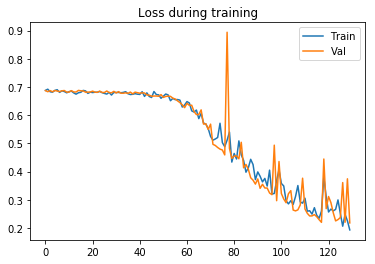

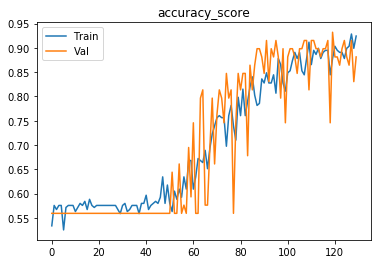

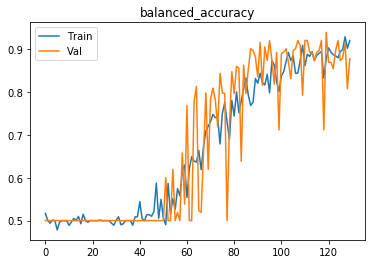

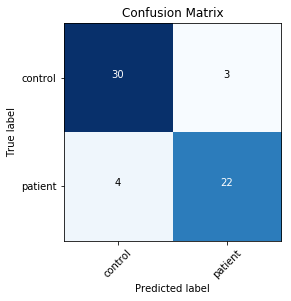

###### Starting inner fold 2
{'model': 'ModelBPIF', 'batch_size': 12, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 301895
[0,    10] loss: 0.68732
Time elapsed: 0h:0m:26s
train accuracy_score: 55.88 %
train balanced_accuracy: 48.67 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.687973
[1,    10] loss: 0.68948
Time elapsed: 0h:1m:3s
train accuracy_score: 57.56 %
train balanced_accuracy: 50.00 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.687899
[2,    10] loss: 0.69684
Time elapsed: 0h:1m:42s
train accuracy_score: 57.56 %
train balanced_accuracy: 50.00 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.688581
[3,    10] loss: 0.66365
Time elapsed: 0h:2m:20s
train accuracy_score: 57.56 %
train balanced_accuracy: 50.00 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.684005
[4,    10] loss: 0.65899
Time elapsed: 0h:2m:58s
train accuracy_score: 57.98 %
train balanced_accuracy: 50.

val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.680355
[43,    10] loss: 0.66944
Time elapsed: 0h:27m:53s
train accuracy_score: 57.56 %
train balanced_accuracy: 50.00 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.680023
[44,    10] loss: 0.68772
Time elapsed: 0h:28m:32s
train accuracy_score: 57.56 %
train balanced_accuracy: 50.00 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.679955
[45,    10] loss: 0.69236
Time elapsed: 0h:29m:11s
train accuracy_score: 57.14 %
train balanced_accuracy: 49.64 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.683919
[46,    10] loss: 0.69513
Time elapsed: 0h:29m:50s
train accuracy_score: 57.56 %
train balanced_accuracy: 50.00 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.683569
[47,    10] loss: 0.68336
Time elapsed: 0h:30m:28s
train accuracy_score: 57.56 %
train balanced_accuracy: 50.00 %
val accuracy_score: 55.93 %
val balanced

val accuracy_score: 74.58 %
val balanced_accuracy: 76.46 %
Val loss: 0.569718
[86,    10] loss: 0.59247
Time elapsed: 0h:54m:58s
train accuracy_score: 72.27 %
train balanced_accuracy: 70.19 %
val accuracy_score: 79.66 %
val balanced_accuracy: 79.78 %
Val loss: 0.520293
[87,    10] loss: 0.55623
Time elapsed: 0h:55m:36s
train accuracy_score: 70.59 %
train balanced_accuracy: 68.86 %
val accuracy_score: 72.88 %
val balanced_accuracy: 69.64 %
Val loss: 0.537722
[88,    10] loss: 0.58097
Time elapsed: 0h:56m:13s
train accuracy_score: 69.33 %
train balanced_accuracy: 67.24 %
val accuracy_score: 66.10 %
val balanced_accuracy: 61.54 %
Val loss: 0.574158
[89,    10] loss: 0.62252
Time elapsed: 0h:56m:49s
train accuracy_score: 70.17 %
train balanced_accuracy: 67.71 %
val accuracy_score: 76.27 %
val balanced_accuracy: 73.89 %
Val loss: 0.508527
[90,    10] loss: 0.55928
Time elapsed: 0h:57m:27s
train accuracy_score: 72.27 %
train balanced_accuracy: 70.19 %
val accuracy_score: 74.58 %
val balanced

val accuracy_score: 83.05 %
val balanced_accuracy: 81.59 %
Val loss: 0.385250
[129,    10] loss: 0.49319
Time elapsed: 1h:21m:42s
train accuracy_score: 78.15 %
train balanced_accuracy: 77.12 %
val accuracy_score: 86.44 %
val balanced_accuracy: 85.43 %
Val loss: 0.368214
[130,    10] loss: 0.42576
Time elapsed: 1h:22m:21s
train accuracy_score: 78.99 %
train balanced_accuracy: 78.50 %
val accuracy_score: 83.05 %
val balanced_accuracy: 83.62 %
Val loss: 0.381726
[131,    10] loss: 0.41361
Time elapsed: 1h:22m:59s
train accuracy_score: 81.51 %
train balanced_accuracy: 80.56 %
val accuracy_score: 84.75 %
val balanced_accuracy: 83.51 %
Val loss: 0.357414
[132,    10] loss: 0.40220
Time elapsed: 1h:23m:37s
train accuracy_score: 78.99 %
train balanced_accuracy: 77.46 %
val accuracy_score: 83.05 %
val balanced_accuracy: 81.59 %
Val loss: 0.356352
[133,    10] loss: 0.42067
Time elapsed: 1h:24m:16s
train accuracy_score: 77.31 %
train balanced_accuracy: 76.26 %
val accuracy_score: 81.36 %
val bal

Time elapsed: 1h:47m:55s
train accuracy_score: 85.29 %
train balanced_accuracy: 84.10 %
val accuracy_score: 89.83 %
val balanced_accuracy: 89.69 %
Val loss: 0.276987
[172,    10] loss: 0.29934
Time elapsed: 1h:48m:33s
train accuracy_score: 84.87 %
train balanced_accuracy: 84.52 %
val accuracy_score: 88.14 %
val balanced_accuracy: 87.35 %
Val loss: 0.286040
[173,    10] loss: 0.33922
Time elapsed: 1h:49m:11s
train accuracy_score: 81.09 %
train balanced_accuracy: 79.93 %
val accuracy_score: 81.36 %
val balanced_accuracy: 78.85 %
Val loss: 0.335593
[174,    10] loss: 0.38799
Time elapsed: 1h:49m:47s
train accuracy_score: 82.35 %
train balanced_accuracy: 81.55 %
val accuracy_score: 89.83 %
val balanced_accuracy: 89.69 %
Val loss: 0.276646
[175,    10] loss: 0.28586
Time elapsed: 1h:50m:25s
train accuracy_score: 85.29 %
train balanced_accuracy: 84.36 %
val accuracy_score: 89.83 %
val balanced_accuracy: 89.28 %
Val loss: 0.277881
[176,    10] loss: 0.36231
Time elapsed: 1h:51m:2s
train accur

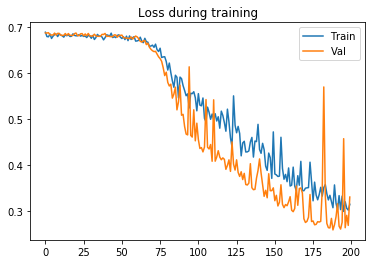

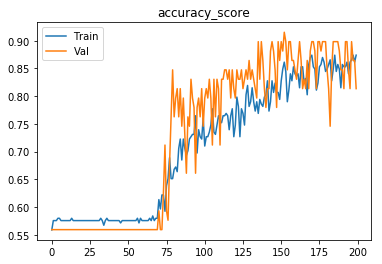

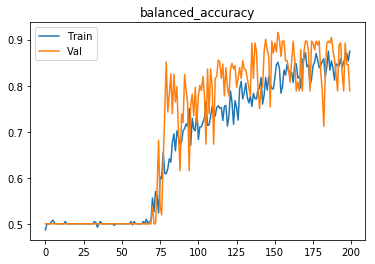

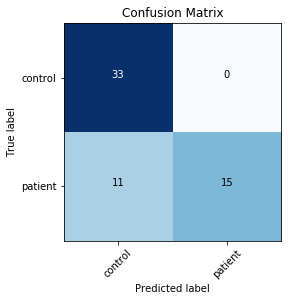

###### Starting inner fold 3
{'model': 'ModelBPIF', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 301895
[0,    10] loss: 0.69140
[0,    20] loss: 0.69245
[0,    30] loss: 0.66935
[0,    40] loss: 0.68534
[0,    50] loss: 0.68322
Time elapsed: 0h:0m:25s
train accuracy_score: 57.14 %
train balanced_accuracy: 50.16 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.684079
[1,    10] loss: 0.69821
[1,    20] loss: 0.67228
[1,    30] loss: 0.67629
[1,    40] loss: 0.66014
[1,    50] loss: 0.74245
Time elapsed: 0h:1m:1s
train accuracy_score: 57.56 %
train balanced_accuracy: 50.00 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.687739
[2,    10] loss: 0.67707
[2,    20] loss: 0.69002
[2,    30] loss: 0.69767
[2,    40] loss: 0.66863
[2,    50] loss: 0.69800
Time elapsed: 0h:1m:38s
train accuracy_score: 57.56 %
train balanced_accuracy: 50.00 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.68336

val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.676304
[28,    10] loss: 0.64575
[28,    20] loss: 0.68727
[28,    30] loss: 0.65409
[28,    40] loss: 0.69202
[28,    50] loss: 0.66688
Time elapsed: 0h:17m:22s
train accuracy_score: 57.14 %
train balanced_accuracy: 50.16 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.674087
[29,    10] loss: 0.67137
[29,    20] loss: 0.67385
[29,    30] loss: 0.70054
[29,    40] loss: 0.68258
[29,    50] loss: 0.67630
Time elapsed: 0h:17m:59s
train accuracy_score: 55.88 %
train balanced_accuracy: 48.93 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.679452
[30,    10] loss: 0.72270
[30,    20] loss: 0.64698
[30,    30] loss: 0.65054
[30,    40] loss: 0.68484
[30,    50] loss: 0.72887
Time elapsed: 0h:18m:37s
train accuracy_score: 57.14 %
train balanced_accuracy: 49.64 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.677720
[31,    10] loss: 0.65874
[31,    

Time elapsed: 0h:33m:50s
train accuracy_score: 69.33 %
train balanced_accuracy: 66.59 %
val accuracy_score: 59.32 %
val balanced_accuracy: 53.85 %
Val loss: 0.656921
[56,    10] loss: 0.67023
[56,    20] loss: 0.56608
[56,    30] loss: 0.56752
[56,    40] loss: 0.51191
[56,    50] loss: 0.62201
Time elapsed: 0h:34m:27s
train accuracy_score: 75.63 %
train balanced_accuracy: 73.11 %
val accuracy_score: 79.66 %
val balanced_accuracy: 79.37 %
Val loss: 0.541407
[57,    10] loss: 0.63055
[57,    20] loss: 0.51856
[57,    30] loss: 0.56160
[57,    40] loss: 0.62717
[57,    50] loss: 0.57818
Time elapsed: 0h:35m:3s
train accuracy_score: 68.07 %
train balanced_accuracy: 66.93 %
val accuracy_score: 64.41 %
val balanced_accuracy: 60.02 %
Val loss: 0.590983
[58,    10] loss: 0.55955
[58,    20] loss: 0.56335
[58,    30] loss: 0.58362
[58,    40] loss: 0.58027
[58,    50] loss: 0.50579
Time elapsed: 0h:35m:40s
train accuracy_score: 71.01 %
train balanced_accuracy: 68.83 %
val accuracy_score: 79.66

[83,    30] loss: 0.51092
[83,    40] loss: 0.49698
[83,    50] loss: 0.47249
Time elapsed: 0h:51m:2s
train accuracy_score: 78.99 %
train balanced_accuracy: 77.85 %
val accuracy_score: 67.80 %
val balanced_accuracy: 63.87 %
Val loss: 0.561493
[84,    10] loss: 0.59595
[84,    20] loss: 0.45157
[84,    30] loss: 0.57724
[84,    40] loss: 0.37268
[84,    50] loss: 0.54707
Time elapsed: 0h:51m:39s
train accuracy_score: 73.53 %
train balanced_accuracy: 72.06 %
val accuracy_score: 79.66 %
val balanced_accuracy: 81.41 %
Val loss: 0.491316
[85,    10] loss: 0.64966
[85,    20] loss: 0.35253
[85,    30] loss: 0.58789
[85,    40] loss: 0.49567
[85,    50] loss: 0.45193
Time elapsed: 0h:52m:15s
train accuracy_score: 75.21 %
train balanced_accuracy: 73.26 %
val accuracy_score: 83.05 %
val balanced_accuracy: 82.40 %
Val loss: 0.409153
[86,    10] loss: 0.37047
[86,    20] loss: 0.48614
[86,    30] loss: 0.54630
[86,    40] loss: 0.41987
[86,    50] loss: 0.58105
Time elapsed: 0h:52m:52s
train accu

val accuracy_score: 86.44 %
val balanced_accuracy: 85.84 %
Val loss: 0.323951
[111,    10] loss: 0.38831
[111,    20] loss: 0.43143
[111,    30] loss: 0.35351
[111,    40] loss: 0.36742
[111,    50] loss: 0.42410
Time elapsed: 1h:8m:15s
train accuracy_score: 83.61 %
train balanced_accuracy: 82.90 %
val accuracy_score: 89.83 %
val balanced_accuracy: 90.09 %
Val loss: 0.322254
[112,    10] loss: 0.35905
[112,    20] loss: 0.30726
[112,    30] loss: 0.39105
[112,    40] loss: 0.42451
[112,    50] loss: 0.45720
Time elapsed: 1h:8m:53s
train accuracy_score: 85.71 %
train balanced_accuracy: 85.12 %
val accuracy_score: 76.27 %
val balanced_accuracy: 73.48 %
Val loss: 0.405566
[113,    10] loss: 0.29587
[113,    20] loss: 0.29315
[113,    30] loss: 0.44242
[113,    40] loss: 0.34135
[113,    50] loss: 0.42368
Time elapsed: 1h:9m:31s
train accuracy_score: 81.51 %
train balanced_accuracy: 81.08 %
val accuracy_score: 86.44 %
val balanced_accuracy: 85.43 %
Val loss: 0.315338
[114,    10] loss: 0.3

[138,    10] loss: 0.31535
[138,    20] loss: 0.21434
[138,    30] loss: 0.32617
[138,    40] loss: 0.30530
[138,    50] loss: 0.22246
Time elapsed: 1h:25m:2s
train accuracy_score: 84.87 %
train balanced_accuracy: 84.26 %
val accuracy_score: 84.75 %
val balanced_accuracy: 84.32 %
Val loss: 0.258821
[139,    10] loss: 0.27639
[139,    20] loss: 0.43238
[139,    30] loss: 0.22356
[139,    40] loss: 0.22247
[139,    50] loss: 0.32601
Time elapsed: 1h:25m:39s
train accuracy_score: 90.34 %
train balanced_accuracy: 90.04 %
val accuracy_score: 88.14 %
val balanced_accuracy: 88.17 %
Val loss: 0.244908
[140,    10] loss: 0.26208
[140,    20] loss: 0.37743
[140,    30] loss: 0.30558
[140,    40] loss: 0.35085
[140,    50] loss: 0.23554
Time elapsed: 1h:26m:16s
train accuracy_score: 85.71 %
train balanced_accuracy: 84.73 %
val accuracy_score: 83.05 %
val balanced_accuracy: 80.77 %
Val loss: 0.315725
[141,    10] loss: 0.18015
[141,    20] loss: 0.36800
[141,    30] loss: 0.24015
[141,    40] loss

[165,    40] loss: 0.29319
[165,    50] loss: 0.16411
Time elapsed: 1h:41m:36s
train accuracy_score: 91.18 %
train balanced_accuracy: 91.56 %
val accuracy_score: 83.05 %
val balanced_accuracy: 80.77 %
Val loss: 0.312698
[166,    10] loss: 0.23614
[166,    20] loss: 0.31172
[166,    30] loss: 0.32266
[166,    40] loss: 0.24244
[166,    50] loss: 0.32318
Time elapsed: 1h:42m:13s
train accuracy_score: 86.97 %
train balanced_accuracy: 86.47 %
val accuracy_score: 81.36 %
val balanced_accuracy: 78.85 %
Val loss: 0.344408
[167,    10] loss: 0.27726
[167,    20] loss: 0.31582
[167,    30] loss: 0.24911
[167,    40] loss: 0.25791
[167,    50] loss: 0.20543
Time elapsed: 1h:42m:50s
train accuracy_score: 88.66 %
train balanced_accuracy: 88.19 %
val accuracy_score: 89.83 %
val balanced_accuracy: 88.87 %
Val loss: 0.214171
[168,    10] loss: 0.26391
[168,    20] loss: 0.29061
[168,    30] loss: 0.22943
[168,    40] loss: 0.27427
[168,    50] loss: 0.19208
Time elapsed: 1h:43m:26s
train accuracy_sco

val accuracy_score: 84.75 %
val balanced_accuracy: 86.36 %
Val loss: 0.350195
[193,    10] loss: 0.29070
[193,    20] loss: 0.20942
[193,    30] loss: 0.17450
[193,    40] loss: 0.14088
[193,    50] loss: 0.29762
Time elapsed: 1h:58m:50s
train accuracy_score: 91.18 %
train balanced_accuracy: 90.64 %
val accuracy_score: 84.75 %
val balanced_accuracy: 82.69 %
Val loss: 0.275423
[194,    10] loss: 0.18709
[194,    20] loss: 0.18117
[194,    30] loss: 0.14985
[194,    40] loss: 0.28239
[194,    50] loss: 0.20527
Time elapsed: 1h:59m:26s
train accuracy_score: 91.60 %
train balanced_accuracy: 91.66 %
val accuracy_score: 89.83 %
val balanced_accuracy: 88.87 %
Val loss: 0.235845
[195,    10] loss: 0.23222
[195,    20] loss: 0.15785
[195,    30] loss: 0.16490
[195,    40] loss: 0.13297
[195,    50] loss: 0.26254
Time elapsed: 2h:0m:2s
train accuracy_score: 93.70 %
train balanced_accuracy: 93.61 %
val accuracy_score: 84.75 %
val balanced_accuracy: 82.69 %
Val loss: 0.294881
[196,    10] loss: 0.

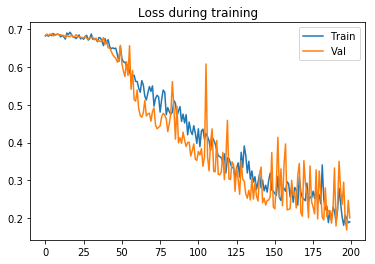

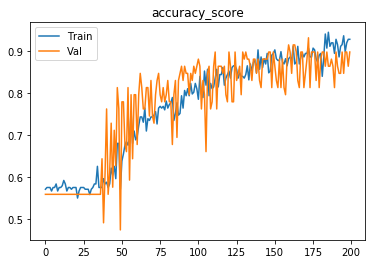

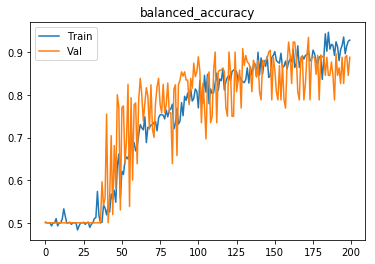

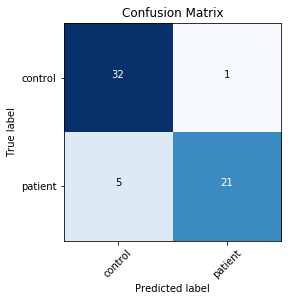

###### Starting inner fold 4
{'model': 'ModelBPIF', 'batch_size': 4, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 301895
[0,    10] loss: 0.69760
[0,    20] loss: 0.69843
[0,    30] loss: 0.67909
[0,    40] loss: 0.69963
[0,    50] loss: 0.69842
Time elapsed: 0h:0m:23s
train accuracy_score: 52.52 %
train balanced_accuracy: 49.26 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.687331
[1,    10] loss: 0.67648
[1,    20] loss: 0.72421
[1,    30] loss: 0.67463
[1,    40] loss: 0.67032
[1,    50] loss: 0.71922
Time elapsed: 0h:1m:0s
train accuracy_score: 57.56 %
train balanced_accuracy: 50.00 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.683887
[2,    10] loss: 0.68979
[2,    20] loss: 0.67103
[2,    30] loss: 0.71161
[2,    40] loss: 0.67976
[2,    50] loss: 0.67865
Time elapsed: 0h:1m:38s
train accuracy_score: 57.56 %
train balanced_accuracy: 50.00 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.6888

val accuracy_score: 72.88 %
val balanced_accuracy: 69.64 %
Val loss: 0.593106
[28,    10] loss: 0.57687
[28,    20] loss: 0.64630
[28,    30] loss: 0.52154
[28,    40] loss: 0.62733
[28,    50] loss: 0.56663
Time elapsed: 0h:17m:39s
train accuracy_score: 72.69 %
train balanced_accuracy: 70.68 %
val accuracy_score: 76.27 %
val balanced_accuracy: 74.71 %
Val loss: 0.545644
[29,    10] loss: 0.49383
[29,    20] loss: 0.59860
[29,    30] loss: 0.58817
[29,    40] loss: 0.56569
[29,    50] loss: 0.65089
Time elapsed: 0h:18m:16s
train accuracy_score: 69.75 %
train balanced_accuracy: 68.13 %
val accuracy_score: 81.36 %
val balanced_accuracy: 81.29 %
Val loss: 0.515296
[30,    10] loss: 0.58346
[30,    20] loss: 0.48000
[30,    30] loss: 0.58152
[30,    40] loss: 0.48058
[30,    50] loss: 0.57361
Time elapsed: 0h:18m:53s
train accuracy_score: 71.01 %
train balanced_accuracy: 69.61 %
val accuracy_score: 81.36 %
val balanced_accuracy: 82.11 %
Val loss: 0.510775
[31,    10] loss: 0.50188
[31,    

Time elapsed: 0h:34m:12s
train accuracy_score: 86.97 %
train balanced_accuracy: 86.47 %
val accuracy_score: 89.83 %
val balanced_accuracy: 88.87 %
Val loss: 0.230614
[56,    10] loss: 0.28028
[56,    20] loss: 0.27623
[56,    30] loss: 0.28375
[56,    40] loss: 0.36213
[56,    50] loss: 0.35374
Time elapsed: 0h:34m:50s
train accuracy_score: 87.82 %
train balanced_accuracy: 87.20 %
val accuracy_score: 93.22 %
val balanced_accuracy: 93.53 %
Val loss: 0.238205
[57,    10] loss: 0.27805
[57,    20] loss: 0.32434
[57,    30] loss: 0.15654
[57,    40] loss: 0.38824
[57,    50] loss: 0.20421
Time elapsed: 0h:35m:27s
train accuracy_score: 87.39 %
train balanced_accuracy: 86.97 %
val accuracy_score: 91.53 %
val balanced_accuracy: 90.79 %
Val loss: 0.221300
[58,    10] loss: 0.32477
[58,    20] loss: 0.39068
[58,    30] loss: 0.21286
[58,    40] loss: 0.25324
[58,    50] loss: 0.29084
Time elapsed: 0h:36m:3s
train accuracy_score: 85.29 %
train balanced_accuracy: 84.49 %
val accuracy_score: 88.14

[83,    30] loss: 0.19692
[83,    40] loss: 0.09923
[83,    50] loss: 0.09676
Time elapsed: 0h:51m:22s
train accuracy_score: 93.70 %
train balanced_accuracy: 93.48 %
val accuracy_score: 93.22 %
val balanced_accuracy: 92.72 %
Val loss: 0.184217
[84,    10] loss: 0.10544
[84,    20] loss: 0.30902
[84,    30] loss: 0.23687
[84,    40] loss: 0.11898
[84,    50] loss: 0.28452
Time elapsed: 0h:51m:59s
train accuracy_score: 91.18 %
train balanced_accuracy: 91.16 %
val accuracy_score: 94.92 %
val balanced_accuracy: 95.05 %
Val loss: 0.186018
[85,    10] loss: 0.24193
[85,    20] loss: 0.17356
[85,    30] loss: 0.07256
[85,    40] loss: 0.05596
[85,    50] loss: 0.19631
Time elapsed: 0h:52m:35s
train accuracy_score: 92.44 %
train balanced_accuracy: 92.13 %
val accuracy_score: 94.92 %
val balanced_accuracy: 94.64 %
Val loss: 0.177000
[86,    10] loss: 0.30144
[86,    20] loss: 0.19750
[86,    30] loss: 0.09308
[86,    40] loss: 0.17076
[86,    50] loss: 0.12885
Time elapsed: 0h:53m:12s
train acc

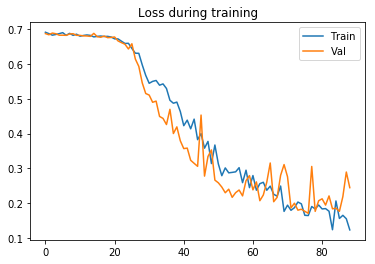

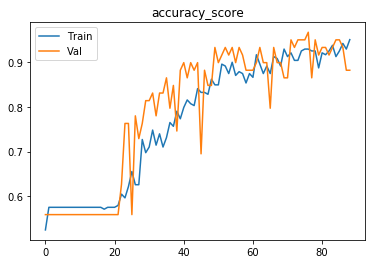

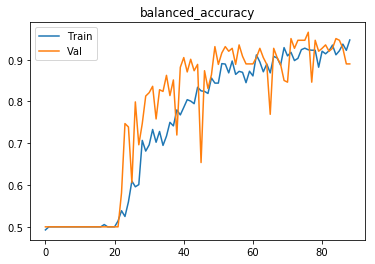

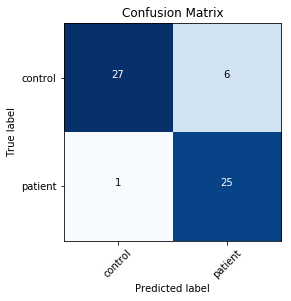

Finished outer fold.
{'final_acc': 0.8898601398601399, 'best_acc': 0.9656177156177157, 'final_iter': 89, 'best_iter': 77, 'params': {'model': 'ModelBPIF', 'batch_size': 4, 'patience': 12, 'lr': 0.0001}, 'inner_fold_idx': 4}
###### Starting outer fold 3
238
59
Shuffled the data..
###### Starting inner fold 0
{'model': 'ModelAPIF', 'batch_size': 4, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 1348665
[0,    10] loss: 0.68261
[0,    20] loss: 0.71127
[0,    30] loss: 0.69309
[0,    40] loss: 0.68460
[0,    50] loss: 0.69406
Time elapsed: 0h:0m:25s
train accuracy_score: 53.78 %
train balanced_accuracy: 48.32 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.696535
[1,    10] loss: 0.69254
[1,    20] loss: 0.67685
[1,    30] loss: 0.64515
[1,    40] loss: 0.75966
[1,    50] loss: 0.70357
Time elapsed: 0h:1m:2s
train accuracy_score: 54.62 %
train balanced_accuracy: 49.57 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.694875
[2,   

val accuracy_score: 84.75 %
val balanced_accuracy: 84.45 %
Val loss: 0.376109
[27,    10] loss: 0.33498
[27,    20] loss: 0.41295
[27,    30] loss: 0.33530
[27,    40] loss: 0.47655
[27,    50] loss: 0.52958
Time elapsed: 0h:17m:2s
train accuracy_score: 79.41 %
train balanced_accuracy: 78.67 %
val accuracy_score: 86.44 %
val balanced_accuracy: 86.23 %
Val loss: 0.376905
[28,    10] loss: 0.44710
[28,    20] loss: 0.25848
[28,    30] loss: 0.30907
[28,    40] loss: 0.28236
[28,    50] loss: 0.32922
Time elapsed: 0h:17m:39s
train accuracy_score: 81.93 %
train balanced_accuracy: 81.23 %
val accuracy_score: 83.05 %
val balanced_accuracy: 82.49 %
Val loss: 0.411497
[29,    10] loss: 0.57849
[29,    20] loss: 0.26537
[29,    30] loss: 0.45270
[29,    40] loss: 0.20573
[29,    50] loss: 0.48196
Time elapsed: 0h:18m:16s
train accuracy_score: 81.51 %
train balanced_accuracy: 81.05 %
val accuracy_score: 86.44 %
val balanced_accuracy: 86.75 %
Val loss: 0.351474
[30,    10] loss: 0.25162
[30,    2

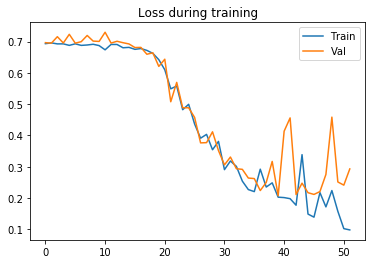

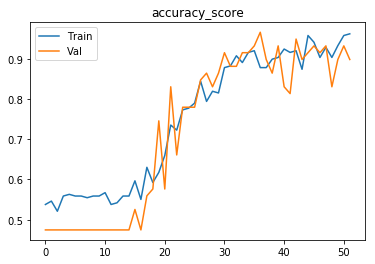

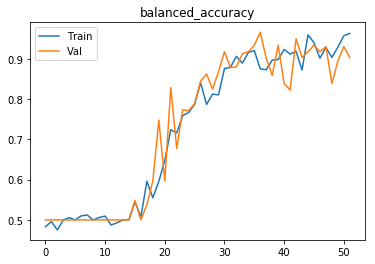

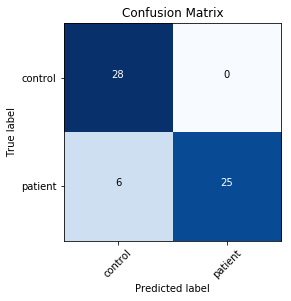

###### Starting inner fold 1
{'model': 'ModelAPIF', 'batch_size': 6, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 1348665
[0,    10] loss: 0.69716
[0,    20] loss: 0.69042
[0,    30] loss: 0.68732
Time elapsed: 0h:0m:25s
train accuracy_score: 53.78 %
train balanced_accuracy: 49.82 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.703247
[1,    10] loss: 0.70541
[1,    20] loss: 0.68548
[1,    30] loss: 0.68882
Time elapsed: 0h:1m:2s
train accuracy_score: 57.14 %
train balanced_accuracy: 51.83 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.704294
[2,    10] loss: 0.68938
[2,    20] loss: 0.70850
[2,    30] loss: 0.67363
Time elapsed: 0h:1m:39s
train accuracy_score: 55.88 %
train balanced_accuracy: 50.00 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.706528
[3,    10] loss: 0.69110
[3,    20] loss: 0.70116
[3,    30] loss: 0.68449
Time elapsed: 0h:2m:16s
train accuracy_score: 55.88 %
train balanced_acc

Time elapsed: 0h:20m:58s
train accuracy_score: 55.46 %
train balanced_accuracy: 49.62 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.682083
[34,    10] loss: 0.66675
[34,    20] loss: 0.67679
[34,    30] loss: 0.65702
Time elapsed: 0h:21m:36s
train accuracy_score: 55.46 %
train balanced_accuracy: 50.03 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.693974
[35,    10] loss: 0.64127
[35,    20] loss: 0.68446
[35,    30] loss: 0.66511
Time elapsed: 0h:22m:12s
train accuracy_score: 55.88 %
train balanced_accuracy: 50.50 %
val accuracy_score: 54.24 %
val balanced_accuracy: 56.45 %
Val loss: 0.673861
[36,    10] loss: 0.67261
[36,    20] loss: 0.63097
[36,    30] loss: 0.66499
Time elapsed: 0h:22m:50s
train accuracy_score: 56.72 %
train balanced_accuracy: 51.85 %
val accuracy_score: 62.71 %
val balanced_accuracy: 64.52 %
Val loss: 0.662642
[37,    10] loss: 0.66315
[37,    20] loss: 0.65686
[37,    30] loss: 0.64020
Time elapsed: 0h:23m:27s

[67,    10] loss: 0.24093
[67,    20] loss: 0.36377
[67,    30] loss: 0.31109
Time elapsed: 0h:42m:10s
train accuracy_score: 88.24 %
train balanced_accuracy: 87.87 %
val accuracy_score: 86.44 %
val balanced_accuracy: 85.71 %
Val loss: 0.263724
[68,    10] loss: 0.17081
[68,    20] loss: 0.24020
[68,    30] loss: 0.25936
Time elapsed: 0h:42m:49s
train accuracy_score: 89.50 %
train balanced_accuracy: 89.20 %
val accuracy_score: 86.44 %
val balanced_accuracy: 86.06 %
Val loss: 0.214085
[69,    10] loss: 0.30511
[69,    20] loss: 0.22310
[69,    30] loss: 0.28451
Time elapsed: 0h:43m:25s
train accuracy_score: 87.39 %
train balanced_accuracy: 87.32 %
val accuracy_score: 91.53 %
val balanced_accuracy: 91.94 %
Val loss: 0.244464
[70,    10] loss: 0.27671
[70,    20] loss: 0.39867
[70,    30] loss: 0.23257
Time elapsed: 0h:44m:2s
train accuracy_score: 85.29 %
train balanced_accuracy: 84.74 %
val accuracy_score: 93.22 %
val balanced_accuracy: 92.86 %
Val loss: 0.198622
[71,    10] loss: 0.22475

val accuracy_score: 94.92 %
val balanced_accuracy: 94.99 %
Val loss: 0.165927
[101,    10] loss: 0.16080
[101,    20] loss: 0.13581
[101,    30] loss: 0.19684
Time elapsed: 1h:3m:17s
train accuracy_score: 92.86 %
train balanced_accuracy: 92.91 %
val accuracy_score: 91.53 %
val balanced_accuracy: 91.59 %
Val loss: 0.166580
[102,    10] loss: 0.12357
[102,    20] loss: 0.21971
[102,    30] loss: 0.15632
Time elapsed: 1h:3m:54s
train accuracy_score: 94.96 %
train balanced_accuracy: 94.99 %
val accuracy_score: 88.14 %
val balanced_accuracy: 87.67 %
Val loss: 0.231568
[103,    10] loss: 0.13267
[103,    20] loss: 0.08727
[103,    30] loss: 0.15882
Time elapsed: 1h:4m:31s
train accuracy_score: 94.96 %
train balanced_accuracy: 94.89 %
val accuracy_score: 89.83 %
val balanced_accuracy: 89.46 %
Val loss: 0.180640
[104,    10] loss: 0.10114
[104,    20] loss: 0.19795
[104,    30] loss: 0.19442
Time elapsed: 1h:5m:9s
train accuracy_score: 92.02 %
train balanced_accuracy: 91.95 %
val accuracy_scor

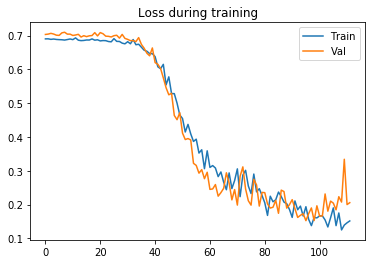

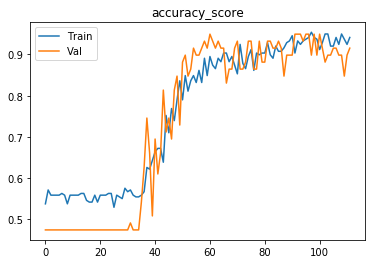

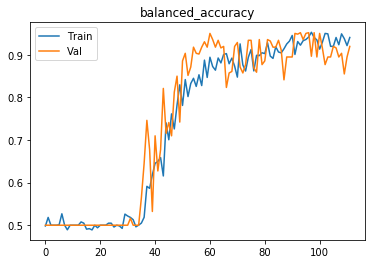

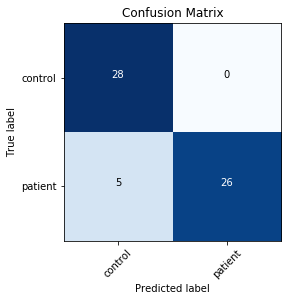

###### Starting inner fold 2
{'model': 'ModelBPIF', 'batch_size': 6, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 301895
[0,    10] loss: 0.67679
[0,    20] loss: 0.70003
[0,    30] loss: 0.68809
Time elapsed: 0h:0m:25s
train accuracy_score: 55.88 %
train balanced_accuracy: 50.00 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.702745
[1,    10] loss: 0.68191
[1,    20] loss: 0.67758
[1,    30] loss: 0.68733
Time elapsed: 0h:1m:2s
train accuracy_score: 55.88 %
train balanced_accuracy: 50.00 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.696462
[2,    10] loss: 0.68910
[2,    20] loss: 0.69070
[2,    30] loss: 0.69216
Time elapsed: 0h:1m:39s
train accuracy_score: 55.04 %
train balanced_accuracy: 49.25 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.696771
[3,    10] loss: 0.69854
[3,    20] loss: 0.68401
[3,    30] loss: 0.68817
Time elapsed: 0h:2m:16s
train accuracy_score: 55.88 %
train balanced_acc

Time elapsed: 0h:20m:51s
train accuracy_score: 57.98 %
train balanced_accuracy: 52.98 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.683908
[34,    10] loss: 0.61200
[34,    20] loss: 0.72909
[34,    30] loss: 0.68808
Time elapsed: 0h:21m:28s
train accuracy_score: 55.46 %
train balanced_accuracy: 53.13 %
val accuracy_score: 50.85 %
val balanced_accuracy: 53.23 %
Val loss: 0.678538
[35,    10] loss: 0.69713
[35,    20] loss: 0.63589
[35,    30] loss: 0.64728
Time elapsed: 0h:22m:5s
train accuracy_score: 56.72 %
train balanced_accuracy: 51.45 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.687300
[36,    10] loss: 0.63515
[36,    20] loss: 0.66253
[36,    30] loss: 0.65544
Time elapsed: 0h:22m:43s
train accuracy_score: 64.29 %
train balanced_accuracy: 60.73 %
val accuracy_score: 67.80 %
val balanced_accuracy: 68.15 %
Val loss: 0.643326
[37,    10] loss: 0.64249
[37,    20] loss: 0.64646
[37,    30] loss: 0.67937
Time elapsed: 0h:23m:20s


[67,    10] loss: 0.32774
[67,    20] loss: 0.38654
[67,    30] loss: 0.33464
Time elapsed: 0h:42m:1s
train accuracy_score: 85.29 %
train balanced_accuracy: 85.34 %
val accuracy_score: 79.66 %
val balanced_accuracy: 79.09 %
Val loss: 0.425039
[68,    10] loss: 0.41985
[68,    20] loss: 0.37028
[68,    30] loss: 0.47425
Time elapsed: 0h:42m:38s
train accuracy_score: 81.93 %
train balanced_accuracy: 81.33 %
val accuracy_score: 76.27 %
val balanced_accuracy: 75.17 %
Val loss: 0.470694
[69,    10] loss: 0.33352
[69,    20] loss: 0.37803
[69,    30] loss: 0.24851
Time elapsed: 0h:43m:15s
train accuracy_score: 84.45 %
train balanced_accuracy: 84.49 %
val accuracy_score: 81.36 %
val balanced_accuracy: 80.88 %
Val loss: 0.370675
[70,    10] loss: 0.27095
[70,    20] loss: 0.41436
[70,    30] loss: 0.40434
Time elapsed: 0h:43m:52s
train accuracy_score: 84.45 %
train balanced_accuracy: 84.19 %
val accuracy_score: 84.75 %
val balanced_accuracy: 84.45 %
Val loss: 0.330725
[71,    10] loss: 0.29791

val accuracy_score: 93.22 %
val balanced_accuracy: 93.38 %
Val loss: 0.221620
[101,    10] loss: 0.16862
[101,    20] loss: 0.27921
[101,    30] loss: 0.24727
Time elapsed: 1h:3m:6s
train accuracy_score: 89.92 %
train balanced_accuracy: 89.57 %
val accuracy_score: 93.22 %
val balanced_accuracy: 93.38 %
Val loss: 0.246127
[102,    10] loss: 0.17897
[102,    20] loss: 0.22197
[102,    30] loss: 0.12833
Time elapsed: 1h:3m:44s
train accuracy_score: 91.60 %
train balanced_accuracy: 91.58 %
val accuracy_score: 93.22 %
val balanced_accuracy: 93.38 %
Val loss: 0.230211
[103,    10] loss: 0.20930
[103,    20] loss: 0.32426
[103,    30] loss: 0.17184
Time elapsed: 1h:4m:21s
train accuracy_score: 90.76 %
train balanced_accuracy: 90.93 %
val accuracy_score: 93.22 %
val balanced_accuracy: 93.38 %
Val loss: 0.272238
[104,    10] loss: 0.17606
[104,    20] loss: 0.18611
[104,    30] loss: 0.15442
Time elapsed: 1h:4m:58s
train accuracy_score: 91.60 %
train balanced_accuracy: 91.88 %
val accuracy_scor

[134,    10] loss: 0.24674
[134,    20] loss: 0.13278
[134,    30] loss: 0.13465
Time elapsed: 1h:23m:40s
train accuracy_score: 93.70 %
train balanced_accuracy: 93.76 %
val accuracy_score: 89.83 %
val balanced_accuracy: 89.80 %
Val loss: 0.208461
[135,    10] loss: 0.12500
[135,    20] loss: 0.22138
[135,    30] loss: 0.13272
Time elapsed: 1h:24m:17s
train accuracy_score: 93.28 %
train balanced_accuracy: 93.28 %
val accuracy_score: 91.53 %
val balanced_accuracy: 91.76 %
Val loss: 0.234214
[136,    10] loss: 0.11040
[136,    20] loss: 0.16551
[136,    30] loss: 0.24566
Time elapsed: 1h:24m:55s
train accuracy_score: 94.54 %
train balanced_accuracy: 94.61 %
val accuracy_score: 94.92 %
val balanced_accuracy: 94.82 %
Val loss: 0.217568
[137,    10] loss: 0.14985
[137,    20] loss: 0.10528
[137,    30] loss: 0.19381
Time elapsed: 1h:25m:32s
train accuracy_score: 92.86 %
train balanced_accuracy: 92.61 %
val accuracy_score: 93.22 %
val balanced_accuracy: 93.03 %
Val loss: 0.195864
[138,    10]

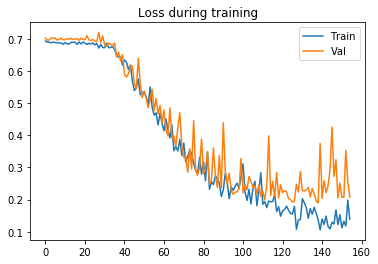

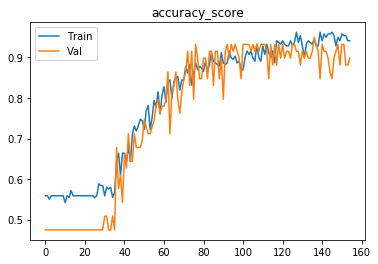

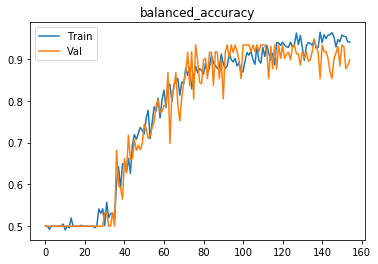

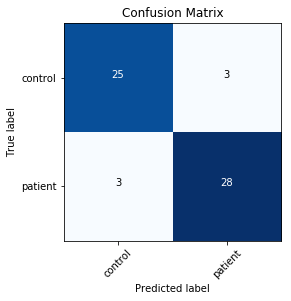

###### Starting inner fold 3
{'model': 'ModelBPIF', 'batch_size': 12, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 301895
[0,    10] loss: 0.69713
Time elapsed: 0h:0m:25s
train accuracy_score: 55.88 %
train balanced_accuracy: 50.00 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.696344
[1,    10] loss: 0.68879
Time elapsed: 0h:1m:3s
train accuracy_score: 55.88 %
train balanced_accuracy: 50.00 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.700937
[2,    10] loss: 0.67438
Time elapsed: 0h:1m:40s
train accuracy_score: 55.88 %
train balanced_accuracy: 50.00 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.708360
[3,    10] loss: 0.69496
Time elapsed: 0h:2m:19s
train accuracy_score: 55.88 %
train balanced_accuracy: 50.00 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.697242
[4,    10] loss: 0.68595
Time elapsed: 0h:2m:57s
train accuracy_score: 55.04 %
train balanced_accuracy: 49

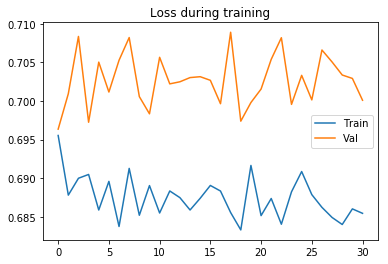

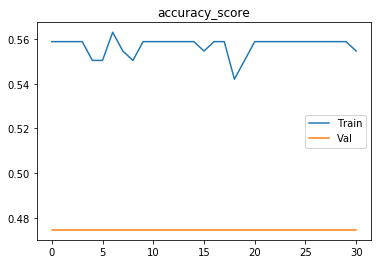

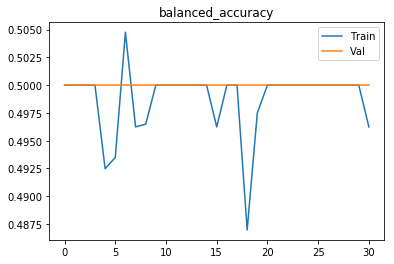

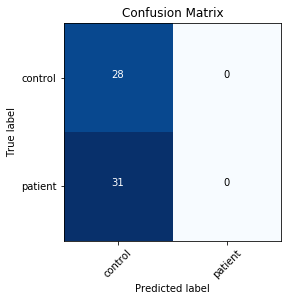

###### Starting inner fold 4
{'model': 'ModelBPIF', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 301895
[0,    10] loss: 0.69766
[0,    20] loss: 0.68701
[0,    30] loss: 0.67374
[0,    40] loss: 0.72237
[0,    50] loss: 0.69088
Time elapsed: 0h:0m:23s
train accuracy_score: 51.68 %
train balanced_accuracy: 47.14 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.698045
[1,    10] loss: 0.67700
[1,    20] loss: 0.71375
[1,    30] loss: 0.67587
[1,    40] loss: 0.69290
[1,    50] loss: 0.69509
Time elapsed: 0h:1m:0s
train accuracy_score: 55.88 %
train balanced_accuracy: 50.00 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.697114
[2,    10] loss: 0.68364
[2,    20] loss: 0.68122
[2,    30] loss: 0.73100
[2,    40] loss: 0.67768
[2,    50] loss: 0.70178
Time elapsed: 0h:1m:37s
train accuracy_score: 55.88 %
train balanced_accuracy: 50.00 %
val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.6961

val accuracy_score: 47.46 %
val balanced_accuracy: 50.00 %
Val loss: 0.676706
[28,    10] loss: 0.63989
[28,    20] loss: 0.69241
[28,    30] loss: 0.65756
[28,    40] loss: 0.65023
[28,    50] loss: 0.63266
Time elapsed: 0h:17m:40s
train accuracy_score: 57.98 %
train balanced_accuracy: 53.68 %
val accuracy_score: 50.85 %
val balanced_accuracy: 53.23 %
Val loss: 0.663937
[29,    10] loss: 0.67115
[29,    20] loss: 0.64021
[29,    30] loss: 0.61396
[29,    40] loss: 0.65076
[29,    50] loss: 0.58629
Time elapsed: 0h:18m:17s
train accuracy_score: 63.87 %
train balanced_accuracy: 61.15 %
val accuracy_score: 67.80 %
val balanced_accuracy: 66.94 %
Val loss: 0.627558
[30,    10] loss: 0.69655
[30,    20] loss: 0.59197
[30,    30] loss: 0.64617
[30,    40] loss: 0.55808
[30,    50] loss: 0.54413
Time elapsed: 0h:18m:54s
train accuracy_score: 65.55 %
train balanced_accuracy: 63.46 %
val accuracy_score: 74.58 %
val balanced_accuracy: 75.81 %
Val loss: 0.599522
[31,    10] loss: 0.49132
[31,    

Time elapsed: 0h:34m:21s
train accuracy_score: 87.82 %
train balanced_accuracy: 87.69 %
val accuracy_score: 88.14 %
val balanced_accuracy: 88.36 %
Val loss: 0.266565
[56,    10] loss: 0.29446
[56,    20] loss: 0.37066
[56,    30] loss: 0.23827
[56,    40] loss: 0.27330
[56,    50] loss: 0.27988
Time elapsed: 0h:34m:58s
train accuracy_score: 88.24 %
train balanced_accuracy: 88.07 %
val accuracy_score: 88.14 %
val balanced_accuracy: 88.71 %
Val loss: 0.290758
[57,    10] loss: 0.30585
[57,    20] loss: 0.25703
[57,    30] loss: 0.32871
[57,    40] loss: 0.20587
[57,    50] loss: 0.32311
Time elapsed: 0h:35m:35s
train accuracy_score: 85.71 %
train balanced_accuracy: 85.41 %
val accuracy_score: 86.44 %
val balanced_accuracy: 86.92 %
Val loss: 0.280994
[58,    10] loss: 0.35016
[58,    20] loss: 0.22189
[58,    30] loss: 0.20855
[58,    40] loss: 0.29490
[58,    50] loss: 0.42850
Time elapsed: 0h:36m:12s
train accuracy_score: 86.55 %
train balanced_accuracy: 86.37 %
val accuracy_score: 81.3

[83,    30] loss: 0.21393
[83,    40] loss: 0.15396
[83,    50] loss: 0.19032
Time elapsed: 0h:51m:35s
train accuracy_score: 93.70 %
train balanced_accuracy: 93.56 %
val accuracy_score: 86.44 %
val balanced_accuracy: 85.89 %
Val loss: 0.316441
[84,    10] loss: 0.17374
[84,    20] loss: 0.16288
[84,    30] loss: 0.27735
[84,    40] loss: 0.15985
[84,    50] loss: 0.12892
Time elapsed: 0h:52m:11s
train accuracy_score: 93.70 %
train balanced_accuracy: 93.66 %
val accuracy_score: 89.83 %
val balanced_accuracy: 89.80 %
Val loss: 0.201782
[85,    10] loss: 0.22248
[85,    20] loss: 0.17654
[85,    30] loss: 0.25731
[85,    40] loss: 0.05400
[85,    50] loss: 0.06679
Time elapsed: 0h:52m:48s
train accuracy_score: 93.70 %
train balanced_accuracy: 93.46 %
val accuracy_score: 86.44 %
val balanced_accuracy: 85.89 %
Val loss: 0.318804
[86,    10] loss: 0.15438
[86,    20] loss: 0.18100
[86,    30] loss: 0.29174
[86,    40] loss: 0.13357
[86,    50] loss: 0.15638
Time elapsed: 0h:53m:25s
train acc

val accuracy_score: 93.22 %
val balanced_accuracy: 93.20 %
Val loss: 0.153676
[111,    10] loss: 0.04646
[111,    20] loss: 0.10782
[111,    30] loss: 0.07426
[111,    40] loss: 0.22316
[111,    50] loss: 0.08948
Time elapsed: 1h:8m:54s
train accuracy_score: 94.96 %
train balanced_accuracy: 94.89 %
val accuracy_score: 91.53 %
val balanced_accuracy: 91.59 %
Val loss: 0.169137
[112,    10] loss: 0.11091
[112,    20] loss: 0.12546
[112,    30] loss: 0.07701
[112,    40] loss: 0.14735
[112,    50] loss: 0.07991
Time elapsed: 1h:9m:31s
train accuracy_score: 94.96 %
train balanced_accuracy: 94.79 %
val accuracy_score: 94.92 %
val balanced_accuracy: 94.99 %
Val loss: 0.156415
[113,    10] loss: 0.07312
[113,    20] loss: 0.17952
[113,    30] loss: 0.16943
[113,    40] loss: 0.06839
[113,    50] loss: 0.05422
Time elapsed: 1h:10m:8s
train accuracy_score: 96.22 %
train balanced_accuracy: 96.12 %
val accuracy_score: 88.14 %
val balanced_accuracy: 88.19 %
Val loss: 0.184824
[114,    10] loss: 0.1

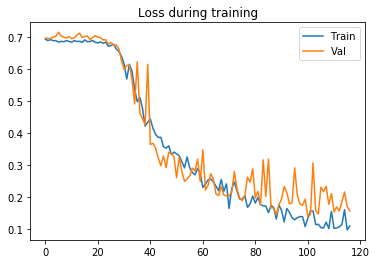

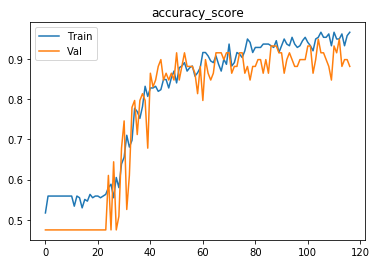

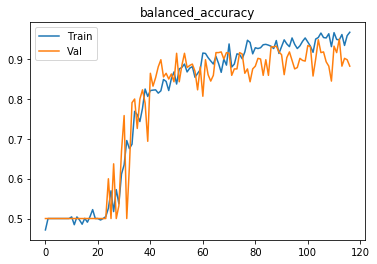

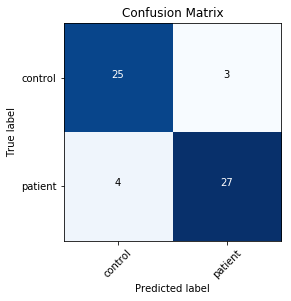

Finished outer fold.
{'final_acc': 0.9032258064516129, 'best_acc': 0.9660138248847927, 'final_iter': 52, 'best_iter': 37, 'params': {'model': 'ModelAPIF', 'batch_size': 4, 'patience': 12, 'lr': 0.0001}, 'inner_fold_idx': 0}
###### Starting outer fold 4
238
59
Shuffled the data..
###### Starting inner fold 0
{'model': 'ModelAPIF', 'batch_size': 6, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 1348665
[0,    10] loss: 0.70234
[0,    20] loss: 0.70042
[0,    30] loss: 0.69659
Time elapsed: 0h:0m:24s
train accuracy_score: 46.22 %
train balanced_accuracy: 44.58 %
val accuracy_score: 54.24 %
val balanced_accuracy: 50.00 %
Val loss: 0.687241
[1,    10] loss: 0.68437
[1,    20] loss: 0.71817
[1,    30] loss: 0.68940
Time elapsed: 0h:1m:2s
train accuracy_score: 52.94 %
train balanced_accuracy: 48.70 %
val accuracy_score: 54.24 %
val balanced_accuracy: 50.00 %
Val loss: 0.690171
[2,    10] loss: 0.69638
[2,    20] loss: 0.68421
[2,    30] loss: 0.69561
Time elapsed: 0h:1m:39s
train ac

[32,    20] loss: 0.66753
[32,    30] loss: 0.67574
Time elapsed: 0h:21m:29s
train accuracy_score: 62.61 %
train balanced_accuracy: 60.60 %
val accuracy_score: 54.24 %
val balanced_accuracy: 50.00 %
Val loss: 0.679021
[33,    10] loss: 0.65378
[33,    20] loss: 0.65356
[33,    30] loss: 0.66798
Time elapsed: 0h:22m:10s
train accuracy_score: 63.03 %
train balanced_accuracy: 59.73 %
val accuracy_score: 55.93 %
val balanced_accuracy: 51.85 %
Val loss: 0.676866
[34,    10] loss: 0.68456
[34,    20] loss: 0.66048
[34,    30] loss: 0.63431
Time elapsed: 0h:22m:49s
train accuracy_score: 59.24 %
train balanced_accuracy: 57.52 %
val accuracy_score: 55.93 %
val balanced_accuracy: 51.85 %
Val loss: 0.665263
[35,    10] loss: 0.66677
[35,    20] loss: 0.64881
[35,    30] loss: 0.63098
Time elapsed: 0h:23m:29s
train accuracy_score: 58.82 %
train balanced_accuracy: 56.27 %
val accuracy_score: 59.32 %
val balanced_accuracy: 55.84 %
Val loss: 0.668683
[36,    10] loss: 0.65856
[36,    20] loss: 0.6454

[66,    10] loss: 0.19590
[66,    20] loss: 0.22796
[66,    30] loss: 0.18257
Time elapsed: 0h:43m:36s
train accuracy_score: 90.34 %
train balanced_accuracy: 90.45 %
val accuracy_score: 67.80 %
val balanced_accuracy: 64.81 %
Val loss: 0.835693
[67,    10] loss: 0.43284
[67,    20] loss: 0.29824
[67,    30] loss: 0.20830
Time elapsed: 0h:44m:21s
train accuracy_score: 86.97 %
train balanced_accuracy: 86.75 %
val accuracy_score: 74.58 %
val balanced_accuracy: 73.38 %
Val loss: 0.581019
[68,    10] loss: 0.26024
[68,    20] loss: 0.29676
[68,    30] loss: 0.22594
Time elapsed: 0h:44m:59s
train accuracy_score: 89.92 %
train balanced_accuracy: 89.67 %
val accuracy_score: 77.97 %
val balanced_accuracy: 77.95 %
Val loss: 0.482982
[69,    10] loss: 0.17859
[69,    20] loss: 0.21959
[69,    30] loss: 0.24483
Time elapsed: 0h:45m:39s
train accuracy_score: 90.34 %
train balanced_accuracy: 90.37 %
val accuracy_score: 77.97 %
val balanced_accuracy: 76.79 %
Val loss: 0.504130
[70,    10] loss: 0.1761

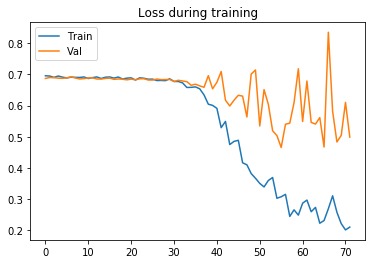

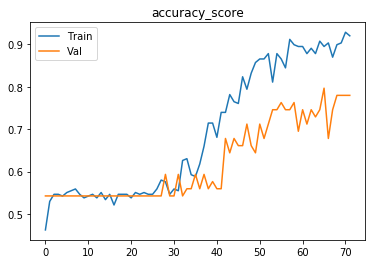

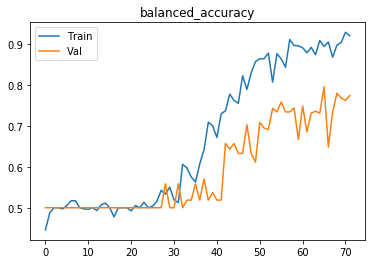

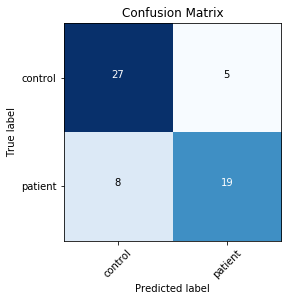

###### Starting inner fold 1
{'model': 'ModelAPIF', 'batch_size': 6, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 1348665
[0,    10] loss: 0.70212
[0,    20] loss: 0.69341
[0,    30] loss: 0.69815
Time elapsed: 0h:0m:28s
train accuracy_score: 48.32 %
train balanced_accuracy: 48.85 %
val accuracy_score: 54.24 %
val balanced_accuracy: 50.00 %
Val loss: 0.690728
[1,    10] loss: 0.68279
[1,    20] loss: 0.72192
[1,    30] loss: 0.69833
Time elapsed: 0h:1m:8s
train accuracy_score: 55.04 %
train balanced_accuracy: 51.01 %
val accuracy_score: 54.24 %
val balanced_accuracy: 50.00 %
Val loss: 0.692689
[2,    10] loss: 0.69407
[2,    20] loss: 0.68949
[2,    30] loss: 0.69428
Time elapsed: 0h:1m:51s
train accuracy_score: 57.14 %
train balanced_accuracy: 53.25 %
val accuracy_score: 54.24 %
val balanced_accuracy: 50.00 %
Val loss: 0.689149
[3,    10] loss: 0.69340
[3,    20] loss: 0.68074
[3,    30] loss: 0.66925
Time elapsed: 0h:2m:30s
train accuracy_score: 54.62 %
train balanced_acc

Time elapsed: 0h:21m:28s
train accuracy_score: 64.29 %
train balanced_accuracy: 61.51 %
val accuracy_score: 44.07 %
val balanced_accuracy: 46.12 %
Val loss: 0.749148
Early stopping in epoch 34
Total time elapsed: 0h:21m:41s
Writing model to disk...
Best result during training: 0.53. Saving model..
Finished inner fold.


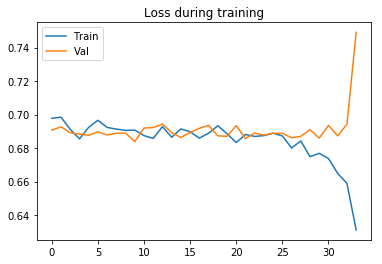

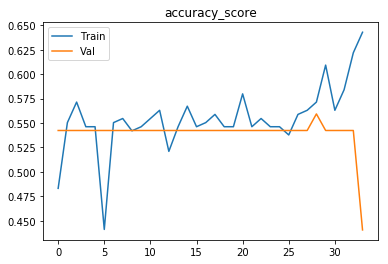

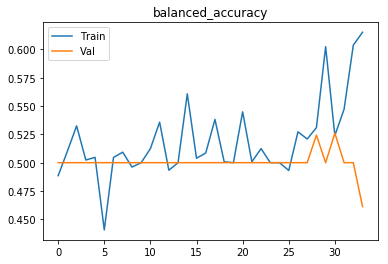

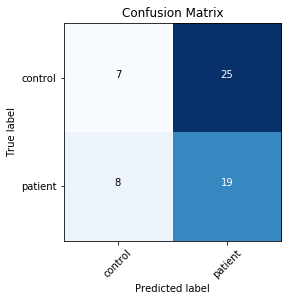

###### Starting inner fold 2
{'model': 'ModelBPIF', 'batch_size': 4, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 301895
[0,    10] loss: 0.68068
[0,    20] loss: 0.71386
[0,    30] loss: 0.67701
[0,    40] loss: 0.68924
[0,    50] loss: 0.70142
Time elapsed: 0h:0m:24s
train accuracy_score: 54.62 %
train balanced_accuracy: 50.00 %
val accuracy_score: 54.24 %
val balanced_accuracy: 50.00 %
Val loss: 0.687192
[1,    10] loss: 0.69177
[1,    20] loss: 0.68889
[1,    30] loss: 0.69410
[1,    40] loss: 0.71324
[1,    50] loss: 0.67787
Time elapsed: 0h:1m:1s
train accuracy_score: 54.62 %
train balanced_accuracy: 50.00 %
val accuracy_score: 54.24 %
val balanced_accuracy: 50.00 %
Val loss: 0.686217
[2,    10] loss: 0.67209
[2,    20] loss: 0.70617
[2,    30] loss: 0.68528
[2,    40] loss: 0.69310
[2,    50] loss: 0.70464
Time elapsed: 0h:1m:37s
train accuracy_score: 54.62 %
train balanced_accuracy: 50.00 %
val accuracy_score: 54.24 %
val balanced_accuracy: 50.00 %
Val loss: 0.69029

val accuracy_score: 54.24 %
val balanced_accuracy: 50.00 %
Val loss: 0.686755
[28,    10] loss: 0.69097
[28,    20] loss: 0.68150
[28,    30] loss: 0.66232
[28,    40] loss: 0.69577
[28,    50] loss: 0.68681
Time elapsed: 0h:18m:1s
train accuracy_score: 54.62 %
train balanced_accuracy: 50.08 %
val accuracy_score: 54.24 %
val balanced_accuracy: 50.00 %
Val loss: 0.686476
[29,    10] loss: 0.69243
[29,    20] loss: 0.69007
[29,    30] loss: 0.69275
[29,    40] loss: 0.68676
[29,    50] loss: 0.67833
Time elapsed: 0h:18m:40s
train accuracy_score: 54.20 %
train balanced_accuracy: 49.69 %
val accuracy_score: 54.24 %
val balanced_accuracy: 50.00 %
Val loss: 0.683120
[30,    10] loss: 0.71123
[30,    20] loss: 0.64568
[30,    30] loss: 0.67796
[30,    40] loss: 0.72965
[30,    50] loss: 0.67579
Time elapsed: 0h:19m:20s
train accuracy_score: 54.62 %
train balanced_accuracy: 50.00 %
val accuracy_score: 54.24 %
val balanced_accuracy: 50.00 %
Val loss: 0.682425
[31,    10] loss: 0.66386
[31,    2

Time elapsed: 0h:35m:21s
train accuracy_score: 72.69 %
train balanced_accuracy: 71.87 %
val accuracy_score: 54.24 %
val balanced_accuracy: 50.00 %
Val loss: 0.657708
[56,    10] loss: 0.57550
[56,    20] loss: 0.60427
[56,    30] loss: 0.51396
[56,    40] loss: 0.50933
[56,    50] loss: 0.60961
Time elapsed: 0h:35m:59s
train accuracy_score: 73.53 %
train balanced_accuracy: 72.64 %
val accuracy_score: 74.58 %
val balanced_accuracy: 75.69 %
Val loss: 0.618402
[57,    10] loss: 0.57594
[57,    20] loss: 0.52979
[57,    30] loss: 0.64329
[57,    40] loss: 0.55865
[57,    50] loss: 0.50877
Time elapsed: 0h:36m:35s
train accuracy_score: 73.95 %
train balanced_accuracy: 72.94 %
val accuracy_score: 61.02 %
val balanced_accuracy: 57.70 %
Val loss: 0.619664
[58,    10] loss: 0.50972
[58,    20] loss: 0.54299
[58,    30] loss: 0.52552
[58,    40] loss: 0.45510
[58,    50] loss: 0.62716
Time elapsed: 0h:37m:11s
train accuracy_score: 74.79 %
train balanced_accuracy: 74.02 %
val accuracy_score: 74.5

[83,    30] loss: 0.38432
[83,    40] loss: 0.45554
[83,    50] loss: 0.24323
Time elapsed: 0h:52m:38s
train accuracy_score: 88.66 %
train balanced_accuracy: 88.60 %
val accuracy_score: 77.97 %
val balanced_accuracy: 77.95 %
Val loss: 0.492408
[84,    10] loss: 0.37221
[84,    20] loss: 0.31715
[84,    30] loss: 0.36009
[84,    40] loss: 0.55769
[84,    50] loss: 0.28333
Time elapsed: 0h:53m:15s
train accuracy_score: 83.61 %
train balanced_accuracy: 83.51 %
val accuracy_score: 77.97 %
val balanced_accuracy: 77.66 %
Val loss: 0.518749
[85,    10] loss: 0.36302
[85,    20] loss: 0.35896
[85,    30] loss: 0.37849
[85,    40] loss: 0.32742
[85,    50] loss: 0.30475
Time elapsed: 0h:53m:52s
train accuracy_score: 89.08 %
train balanced_accuracy: 89.14 %
val accuracy_score: 77.97 %
val balanced_accuracy: 78.53 %
Val loss: 0.496186
[86,    10] loss: 0.21658
[86,    20] loss: 0.37084
[86,    30] loss: 0.26471
[86,    40] loss: 0.37205
[86,    50] loss: 0.30585
Time elapsed: 0h:54m:29s
train acc

val accuracy_score: 79.66 %
val balanced_accuracy: 80.38 %
Val loss: 0.457025
[111,    10] loss: 0.33545
[111,    20] loss: 0.28612
[111,    30] loss: 0.26315
[111,    40] loss: 0.20126
[111,    50] loss: 0.22998
Time elapsed: 1h:9m:58s
train accuracy_score: 88.66 %
train balanced_accuracy: 88.52 %
val accuracy_score: 81.36 %
val balanced_accuracy: 80.79 %
Val loss: 0.463797
[112,    10] loss: 0.27415
[112,    20] loss: 0.31836
[112,    30] loss: 0.39361
[112,    40] loss: 0.24529
[112,    50] loss: 0.16364
Time elapsed: 1h:10m:35s
train accuracy_score: 86.97 %
train balanced_accuracy: 86.67 %
val accuracy_score: 74.58 %
val balanced_accuracy: 75.69 %
Val loss: 0.521079
[113,    10] loss: 0.21852
[113,    20] loss: 0.34345
[113,    30] loss: 0.20532
[113,    40] loss: 0.24787
[113,    50] loss: 0.16406
Time elapsed: 1h:11m:11s
train accuracy_score: 91.18 %
train balanced_accuracy: 91.14 %
val accuracy_score: 77.97 %
val balanced_accuracy: 78.82 %
Val loss: 0.478350
[114,    10] loss: 0

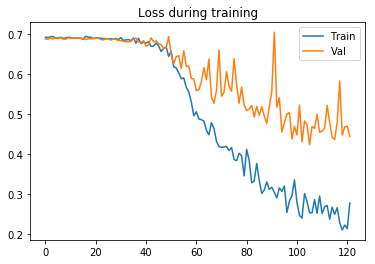

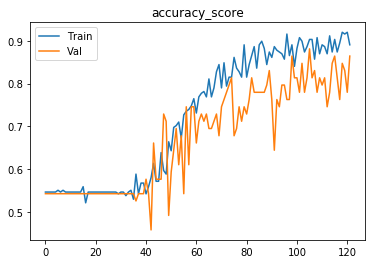

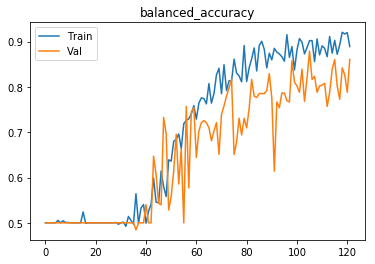

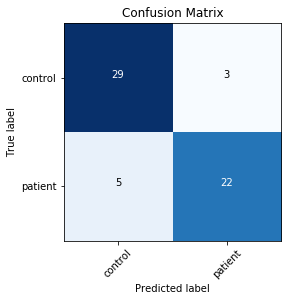

###### Starting inner fold 3
{'model': 'ModelBPIF', 'batch_size': 6, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 301895
[0,    10] loss: 0.68974
[0,    20] loss: 0.69869
[0,    30] loss: 0.67686
Time elapsed: 0h:0m:26s
train accuracy_score: 53.78 %
train balanced_accuracy: 49.23 %
val accuracy_score: 54.24 %
val balanced_accuracy: 50.00 %
Val loss: 0.686543
[1,    10] loss: 0.70121
[1,    20] loss: 0.68746
[1,    30] loss: 0.70186
Time elapsed: 0h:1m:5s
train accuracy_score: 53.78 %
train balanced_accuracy: 49.23 %
val accuracy_score: 54.24 %
val balanced_accuracy: 50.00 %
Val loss: 0.687690
[2,    10] loss: 0.67394
[2,    20] loss: 0.69790
[2,    30] loss: 0.68958
Time elapsed: 0h:1m:44s
train accuracy_score: 54.62 %
train balanced_accuracy: 50.00 %
val accuracy_score: 54.24 %
val balanced_accuracy: 50.00 %
Val loss: 0.687018
[3,    10] loss: 0.69248
[3,    20] loss: 0.67815
[3,    30] loss: 0.68014
Time elapsed: 0h:2m:27s
train accuracy_score: 55.46 %
train balanced_acc

Time elapsed: 0h:21m:35s
train accuracy_score: 65.13 %
train balanced_accuracy: 63.53 %
val accuracy_score: 66.10 %
val balanced_accuracy: 67.01 %
Val loss: 0.655138
[34,    10] loss: 0.60706
[34,    20] loss: 0.65976
[34,    30] loss: 0.62773
Time elapsed: 0h:22m:14s
train accuracy_score: 68.07 %
train balanced_accuracy: 67.01 %
val accuracy_score: 66.10 %
val balanced_accuracy: 65.28 %
Val loss: 0.638088
[35,    10] loss: 0.61598
[35,    20] loss: 0.61526
[35,    30] loss: 0.62992
Time elapsed: 0h:22m:52s
train accuracy_score: 62.61 %
train balanced_accuracy: 61.70 %
val accuracy_score: 47.46 %
val balanced_accuracy: 51.56 %
Val loss: 0.715511
[36,    10] loss: 0.54895
[36,    20] loss: 0.66766
[36,    30] loss: 0.77559
Time elapsed: 0h:23m:30s
train accuracy_score: 62.61 %
train balanced_accuracy: 61.46 %
val accuracy_score: 62.71 %
val balanced_accuracy: 59.55 %
Val loss: 0.634213
[37,    10] loss: 0.59047
[37,    20] loss: 0.62044
[37,    30] loss: 0.66869
Time elapsed: 0h:24m:6s


[67,    10] loss: 0.41365
[67,    20] loss: 0.35976
[67,    30] loss: 0.26161
Time elapsed: 0h:42m:59s
train accuracy_score: 88.24 %
train balanced_accuracy: 88.21 %
val accuracy_score: 79.66 %
val balanced_accuracy: 78.94 %
Val loss: 0.487100
[68,    10] loss: 0.21755
[68,    20] loss: 0.31057
[68,    30] loss: 0.25577
Time elapsed: 0h:43m:37s
train accuracy_score: 89.08 %
train balanced_accuracy: 88.82 %
val accuracy_score: 72.88 %
val balanced_accuracy: 73.55 %
Val loss: 0.494933
[69,    10] loss: 0.29672
[69,    20] loss: 0.26369
[69,    30] loss: 0.26177
Time elapsed: 0h:44m:16s
train accuracy_score: 89.50 %
train balanced_accuracy: 89.29 %
val accuracy_score: 77.97 %
val balanced_accuracy: 77.37 %
Val loss: 0.485557
[70,    10] loss: 0.20212
[70,    20] loss: 0.20115
[70,    30] loss: 0.20081
Time elapsed: 0h:44m:54s
train accuracy_score: 89.08 %
train balanced_accuracy: 89.06 %
val accuracy_score: 79.66 %
val balanced_accuracy: 78.65 %
Val loss: 0.497943
[71,    10] loss: 0.1988

val accuracy_score: 81.36 %
val balanced_accuracy: 80.21 %
Val loss: 0.449669
[101,    10] loss: 0.19759
[101,    20] loss: 0.12312
[101,    30] loss: 0.14027
Time elapsed: 1h:4m:19s
train accuracy_score: 91.60 %
train balanced_accuracy: 91.52 %
val accuracy_score: 74.58 %
val balanced_accuracy: 72.22 %
Val loss: 0.859268
[102,    10] loss: 0.24623
[102,    20] loss: 0.17094
[102,    30] loss: 0.09895
Time elapsed: 1h:4m:57s
train accuracy_score: 91.60 %
train balanced_accuracy: 91.60 %
val accuracy_score: 77.97 %
val balanced_accuracy: 78.24 %
Val loss: 0.449293
[103,    10] loss: 0.07232
[103,    20] loss: 0.16478
[103,    30] loss: 0.12969
Time elapsed: 1h:5m:36s
train accuracy_score: 94.12 %
train balanced_accuracy: 94.07 %
val accuracy_score: 81.36 %
val balanced_accuracy: 81.08 %
Val loss: 0.449112
[104,    10] loss: 0.22630
[104,    20] loss: 0.15158
[104,    30] loss: 0.15036
Time elapsed: 1h:6m:14s
train accuracy_score: 92.86 %
train balanced_accuracy: 92.91 %
val accuracy_sco

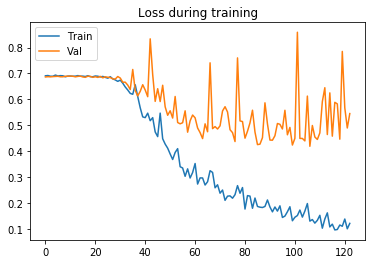

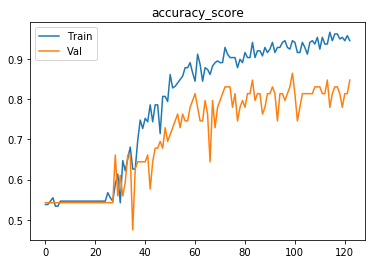

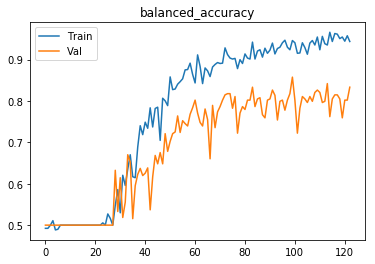

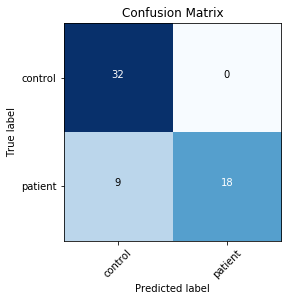

###### Starting inner fold 4
{'model': 'ModelAPIF', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 1348665
[0,    10] loss: 0.69644
Time elapsed: 0h:0m:25s
train accuracy_score: 52.10 %
train balanced_accuracy: 48.40 %
val accuracy_score: 54.24 %
val balanced_accuracy: 50.00 %
Val loss: 0.690103
[1,    10] loss: 0.68468
Time elapsed: 0h:1m:4s
train accuracy_score: 54.62 %
train balanced_accuracy: 50.47 %
val accuracy_score: 54.24 %
val balanced_accuracy: 50.00 %
Val loss: 0.689092
[2,    10] loss: 0.69040
Time elapsed: 0h:1m:42s
train accuracy_score: 50.42 %
train balanced_accuracy: 47.09 %
val accuracy_score: 54.24 %
val balanced_accuracy: 50.00 %
Val loss: 0.686180
[3,    10] loss: 0.68869
Time elapsed: 0h:2m:21s
train accuracy_score: 52.10 %
train balanced_accuracy: 47.69 %
val accuracy_score: 54.24 %
val balanced_accuracy: 50.00 %
Val loss: 0.688965
[4,    10] loss: 0.69555
Time elapsed: 0h:2m:58s
train accuracy_score: 54.62 %
train balanced_accuracy: 5

Time elapsed: 0h:28m:37s
train accuracy_score: 80.25 %
train balanced_accuracy: 79.49 %
val accuracy_score: 44.07 %
val balanced_accuracy: 47.28 %
Val loss: 1.014972
[43,    10] loss: 0.56593
Time elapsed: 0h:29m:18s
train accuracy_score: 76.89 %
train balanced_accuracy: 76.65 %
val accuracy_score: 71.19 %
val balanced_accuracy: 69.68 %
Val loss: 0.638470
[44,    10] loss: 0.47241
Time elapsed: 0h:30m:3s
train accuracy_score: 79.41 %
train balanced_accuracy: 78.96 %
val accuracy_score: 67.80 %
val balanced_accuracy: 64.81 %
Val loss: 0.641198
[45,    10] loss: 0.36578
Time elapsed: 0h:30m:44s
train accuracy_score: 83.19 %
train balanced_accuracy: 82.89 %
val accuracy_score: 66.10 %
val balanced_accuracy: 66.72 %
Val loss: 0.604804
[46,    10] loss: 0.42927
Time elapsed: 0h:31m:23s
train accuracy_score: 81.09 %
train balanced_accuracy: 80.97 %
val accuracy_score: 66.10 %
val balanced_accuracy: 62.96 %
Val loss: 0.686851
[47,    10] loss: 0.33089
Time elapsed: 0h:32m:1s
train accuracy_sc

[85,    10] loss: 0.13053
Time elapsed: 0h:56m:26s
train accuracy_score: 92.86 %
train balanced_accuracy: 92.76 %
val accuracy_score: 79.66 %
val balanced_accuracy: 78.07 %
Val loss: 0.547917
[86,    10] loss: 0.10553
Time elapsed: 0h:57m:12s
train accuracy_score: 94.96 %
train balanced_accuracy: 94.84 %
val accuracy_score: 79.66 %
val balanced_accuracy: 78.07 %
Val loss: 0.480624
[87,    10] loss: 0.15920
Time elapsed: 0h:57m:57s
train accuracy_score: 93.70 %
train balanced_accuracy: 93.45 %
val accuracy_score: 86.44 %
val balanced_accuracy: 85.47 %
Val loss: 0.406391
[88,    10] loss: 0.19939
Time elapsed: 0h:58m:40s
train accuracy_score: 92.44 %
train balanced_accuracy: 92.45 %
val accuracy_score: 88.14 %
val balanced_accuracy: 87.33 %
Val loss: 0.391669
[89,    10] loss: 0.12042
Time elapsed: 0h:59m:21s
train accuracy_score: 95.38 %
train balanced_accuracy: 95.38 %
val accuracy_score: 84.75 %
val balanced_accuracy: 83.62 %
Val loss: 0.408164
[90,    10] loss: 0.13298
Time elapsed: 

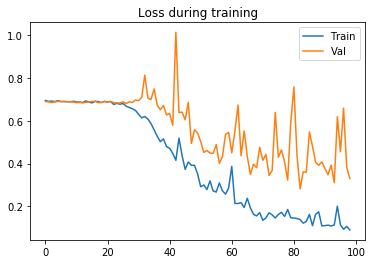

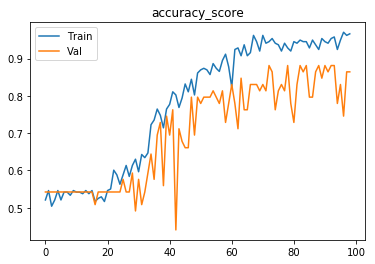

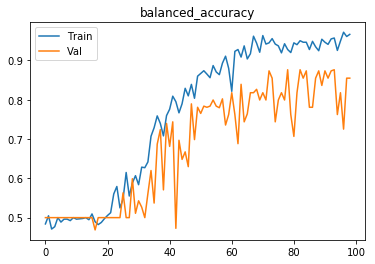

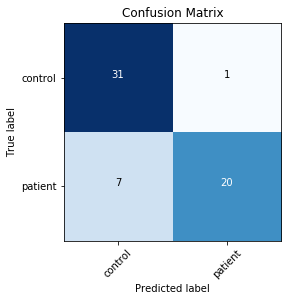

Finished outer fold.
{'final_acc': 0.8605324074074074, 'best_acc': 0.879050925925926, 'final_iter': 122, 'best_iter': 106, 'params': {'model': 'ModelBPIF', 'batch_size': 4, 'patience': 16, 'lr': 5e-05}, 'inner_fold_idx': 2}
###### Starting outer fold 5
238
59
Shuffled the data..
###### Starting inner fold 0
{'model': 'ModelAPIF', 'batch_size': 12, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 1348665
[0,    10] loss: 0.67830
Time elapsed: 0h:0m:26s
train accuracy_score: 59.24 %
train balanced_accuracy: 50.00 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.698021
[1,    10] loss: 0.68655
Time elapsed: 0h:1m:4s
train accuracy_score: 58.82 %
train balanced_accuracy: 49.65 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.698574
[2,    10] loss: 0.68535
Time elapsed: 0h:1m:42s
train accuracy_score: 59.24 %
train balanced_accuracy: 50.00 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.695250
[3,    10] loss:

[41,    10] loss: 0.66336
Time elapsed: 0h:27m:5s
train accuracy_score: 59.24 %
train balanced_accuracy: 50.00 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.689461
[42,    10] loss: 0.68716
Time elapsed: 0h:27m:43s
train accuracy_score: 59.24 %
train balanced_accuracy: 50.00 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.688902
[43,    10] loss: 0.68198
Time elapsed: 0h:28m:22s
train accuracy_score: 59.24 %
train balanced_accuracy: 50.00 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.695529
[44,    10] loss: 0.64689
Time elapsed: 0h:29m:1s
train accuracy_score: 59.24 %
train balanced_accuracy: 50.00 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.694808
[45,    10] loss: 0.66501
Time elapsed: 0h:29m:39s
train accuracy_score: 58.82 %
train balanced_accuracy: 49.65 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.690844
[46,    10] loss: 0.67468
Time elapsed: 0h

[84,    10] loss: 0.33190
Time elapsed: 0h:56m:8s
train accuracy_score: 87.82 %
train balanced_accuracy: 87.14 %
val accuracy_score: 76.27 %
val balanced_accuracy: 75.00 %
Val loss: 0.422415
[85,    10] loss: 0.31422
Time elapsed: 0h:56m:47s
train accuracy_score: 87.82 %
train balanced_accuracy: 87.30 %
val accuracy_score: 81.36 %
val balanced_accuracy: 80.53 %
Val loss: 0.324013
[86,    10] loss: 0.27078
Time elapsed: 0h:57m:26s
train accuracy_score: 89.50 %
train balanced_accuracy: 89.04 %
val accuracy_score: 86.44 %
val balanced_accuracy: 86.06 %
Val loss: 0.277393
[87,    10] loss: 0.23408
Time elapsed: 0h:58m:5s
train accuracy_score: 90.34 %
train balanced_accuracy: 89.59 %
val accuracy_score: 91.53 %
val balanced_accuracy: 91.76 %
Val loss: 0.266305
[88,    10] loss: 0.35706
Time elapsed: 0h:58m:44s
train accuracy_score: 87.82 %
train balanced_accuracy: 87.30 %
val accuracy_score: 79.66 %
val balanced_accuracy: 78.74 %
Val loss: 0.349411
[89,    10] loss: 0.28246
Time elapsed: 0h

[127,    10] loss: 0.16497
Time elapsed: 1h:25m:5s
train accuracy_score: 91.60 %
train balanced_accuracy: 91.30 %
val accuracy_score: 84.75 %
val balanced_accuracy: 84.45 %
Val loss: 0.228666
[128,    10] loss: 0.15565
Time elapsed: 1h:25m:44s
train accuracy_score: 93.70 %
train balanced_accuracy: 93.39 %
val accuracy_score: 93.22 %
val balanced_accuracy: 93.38 %
Val loss: 0.206587
[129,    10] loss: 0.22914
Time elapsed: 1h:26m:23s
train accuracy_score: 92.86 %
train balanced_accuracy: 92.52 %
val accuracy_score: 93.22 %
val balanced_accuracy: 93.38 %
Val loss: 0.230725
[130,    10] loss: 0.14643
Time elapsed: 1h:27m:2s
train accuracy_score: 92.86 %
train balanced_accuracy: 92.68 %
val accuracy_score: 83.05 %
val balanced_accuracy: 82.32 %
Val loss: 0.310858
[131,    10] loss: 0.23525
Time elapsed: 1h:27m:40s
train accuracy_score: 92.02 %
train balanced_accuracy: 91.98 %
val accuracy_score: 93.22 %
val balanced_accuracy: 93.38 %
Val loss: 0.204494
[132,    10] loss: 0.18778
Time elaps

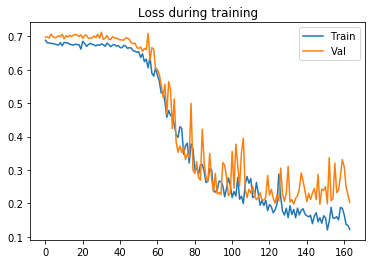

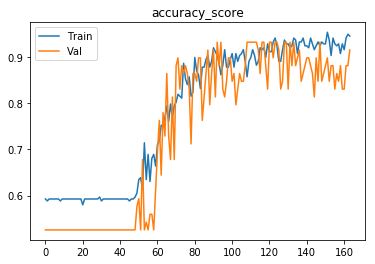

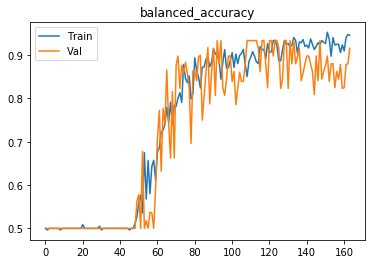

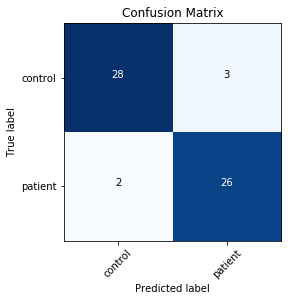

###### Starting inner fold 1
{'model': 'ModelAPIF', 'batch_size': 6, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 1348665
[0,    10] loss: 0.66428
[0,    20] loss: 0.70006
[0,    30] loss: 0.66215
Time elapsed: 0h:0m:24s
train accuracy_score: 58.82 %
train balanced_accuracy: 49.97 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.689560
[1,    10] loss: 0.68478
[1,    20] loss: 0.67998
[1,    30] loss: 0.66510
Time elapsed: 0h:1m:2s
train accuracy_score: 59.24 %
train balanced_accuracy: 50.00 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.716278
[2,    10] loss: 0.67112
[2,    20] loss: 0.65708
[2,    30] loss: 0.68867
Time elapsed: 0h:1m:40s
train accuracy_score: 58.40 %
train balanced_accuracy: 49.77 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.696879
[3,    10] loss: 0.68813
[3,    20] loss: 0.67134
[3,    30] loss: 0.67574
Time elapsed: 0h:2m:18s
train accuracy_score: 57.56 %
train balanced_ac

Time elapsed: 0h:21m:35s
train accuracy_score: 74.37 %
train balanced_accuracy: 71.77 %
val accuracy_score: 76.27 %
val balanced_accuracy: 77.25 %
Val loss: 0.510521
[34,    10] loss: 0.49082
[34,    20] loss: 0.61732
[34,    30] loss: 0.53734
Time elapsed: 0h:22m:13s
train accuracy_score: 74.79 %
train balanced_accuracy: 72.45 %
val accuracy_score: 79.66 %
val balanced_accuracy: 80.13 %
Val loss: 0.486950
[35,    10] loss: 0.47319
[35,    20] loss: 0.44947
[35,    30] loss: 0.61258
Time elapsed: 0h:22m:52s
train accuracy_score: 78.99 %
train balanced_accuracy: 78.25 %
val accuracy_score: 84.75 %
val balanced_accuracy: 84.27 %
Val loss: 0.454195
[36,    10] loss: 0.55381
[36,    20] loss: 0.47681
[36,    30] loss: 0.55452
Time elapsed: 0h:23m:31s
train accuracy_score: 71.85 %
train balanced_accuracy: 69.49 %
val accuracy_score: 64.41 %
val balanced_accuracy: 62.50 %
Val loss: 0.517248
[37,    10] loss: 0.60241
[37,    20] loss: 0.45219
[37,    30] loss: 0.43747
Time elapsed: 0h:24m:10s

[67,    10] loss: 0.11290
[67,    20] loss: 0.17532
[67,    30] loss: 0.24155
Time elapsed: 0h:43m:34s
train accuracy_score: 92.44 %
train balanced_accuracy: 92.33 %
val accuracy_score: 91.53 %
val balanced_accuracy: 91.59 %
Val loss: 0.186143
[68,    10] loss: 0.17855
[68,    20] loss: 0.12980
[68,    30] loss: 0.12437
Time elapsed: 0h:44m:13s
train accuracy_score: 94.96 %
train balanced_accuracy: 94.78 %
val accuracy_score: 86.44 %
val balanced_accuracy: 86.06 %
Val loss: 0.210731
[69,    10] loss: 0.13782
[69,    20] loss: 0.17711
[69,    30] loss: 0.16070
Time elapsed: 0h:44m:53s
train accuracy_score: 92.86 %
train balanced_accuracy: 92.68 %
val accuracy_score: 88.14 %
val balanced_accuracy: 87.50 %
Val loss: 0.285155
[70,    10] loss: 0.17019
[70,    20] loss: 0.20852
[70,    30] loss: 0.15226
Time elapsed: 0h:45m:31s
train accuracy_score: 92.44 %
train balanced_accuracy: 92.17 %
val accuracy_score: 88.14 %
val balanced_accuracy: 87.50 %
Val loss: 0.257887
[71,    10] loss: 0.1593

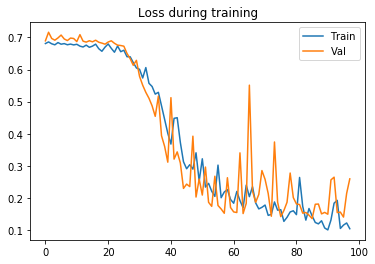

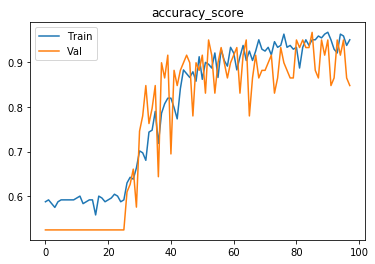

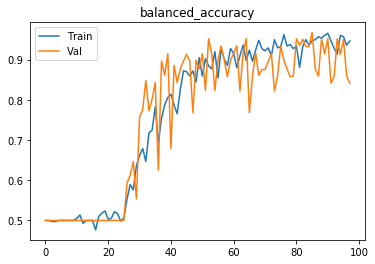

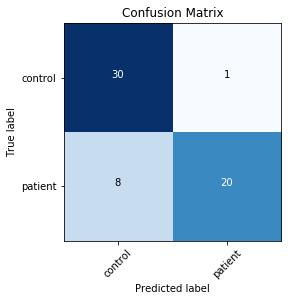

###### Starting inner fold 2
{'model': 'ModelBPIF', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 301895
[0,    10] loss: 0.69205
[0,    20] loss: 0.66810
[0,    30] loss: 0.70233
[0,    40] loss: 0.68528
[0,    50] loss: 0.68855
Time elapsed: 0h:0m:24s
train accuracy_score: 59.24 %
train balanced_accuracy: 50.00 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.692380
[1,    10] loss: 0.66411
[1,    20] loss: 0.63516
[1,    30] loss: 0.72785
[1,    40] loss: 0.69608
[1,    50] loss: 0.71434
Time elapsed: 0h:1m:2s
train accuracy_score: 59.24 %
train balanced_accuracy: 50.00 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.690955
[2,    10] loss: 0.69292
[2,    20] loss: 0.68582
[2,    30] loss: 0.65940
[2,    40] loss: 0.69548
[2,    50] loss: 0.67239
Time elapsed: 0h:1m:39s
train accuracy_score: 59.24 %
train balanced_accuracy: 50.00 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.69977

val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.690112
[28,    10] loss: 0.64532
[28,    20] loss: 0.66403
[28,    30] loss: 0.69060
[28,    40] loss: 0.66328
[28,    50] loss: 0.67847
Time elapsed: 0h:17m:40s
train accuracy_score: 59.24 %
train balanced_accuracy: 50.00 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.687446
[29,    10] loss: 0.63930
[29,    20] loss: 0.70677
[29,    30] loss: 0.69065
[29,    40] loss: 0.67907
[29,    50] loss: 0.66963
Time elapsed: 0h:18m:17s
train accuracy_score: 59.24 %
train balanced_accuracy: 50.00 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.689957
[30,    10] loss: 0.67830
[30,    20] loss: 0.69400
[30,    30] loss: 0.69115
[30,    40] loss: 0.66629
[30,    50] loss: 0.63083
Time elapsed: 0h:18m:54s
train accuracy_score: 58.40 %
train balanced_accuracy: 49.29 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.697062
[31,    10] loss: 0.66085
[31,    

Time elapsed: 0h:34m:15s
train accuracy_score: 74.37 %
train balanced_accuracy: 70.65 %
val accuracy_score: 74.58 %
val balanced_accuracy: 74.42 %
Val loss: 0.535455
[56,    10] loss: 0.52212
[56,    20] loss: 0.43229
[56,    30] loss: 0.59885
[56,    40] loss: 0.60079
[56,    50] loss: 0.47745
Time elapsed: 0h:34m:51s
train accuracy_score: 75.63 %
train balanced_accuracy: 74.77 %
val accuracy_score: 71.19 %
val balanced_accuracy: 70.16 %
Val loss: 0.576893
[57,    10] loss: 0.54190
[57,    20] loss: 0.51756
[57,    30] loss: 0.56867
[57,    40] loss: 0.68199
[57,    50] loss: 0.49331
Time elapsed: 0h:35m:27s
train accuracy_score: 71.01 %
train balanced_accuracy: 67.81 %
val accuracy_score: 72.88 %
val balanced_accuracy: 72.47 %
Val loss: 0.525318
[58,    10] loss: 0.41222
[58,    20] loss: 0.64402
[58,    30] loss: 0.54812
[58,    40] loss: 0.54113
[58,    50] loss: 0.52795
Time elapsed: 0h:36m:3s
train accuracy_score: 75.21 %
train balanced_accuracy: 71.52 %
val accuracy_score: 76.27

[83,    30] loss: 0.34703
[83,    40] loss: 0.36736
[83,    50] loss: 0.37078
Time elapsed: 0h:51m:22s
train accuracy_score: 82.35 %
train balanced_accuracy: 81.41 %
val accuracy_score: 79.66 %
val balanced_accuracy: 79.61 %
Val loss: 0.375857
[84,    10] loss: 0.45034
[84,    20] loss: 0.34455
[84,    30] loss: 0.37255
[84,    40] loss: 0.40881
[84,    50] loss: 0.39254
Time elapsed: 0h:51m:59s
train accuracy_score: 80.25 %
train balanced_accuracy: 78.51 %
val accuracy_score: 84.75 %
val balanced_accuracy: 84.45 %
Val loss: 0.387862
[85,    10] loss: 0.36851
[85,    20] loss: 0.28662
[85,    30] loss: 0.36825
[85,    40] loss: 0.31006
[85,    50] loss: 0.41361
Time elapsed: 0h:52m:36s
train accuracy_score: 81.93 %
train balanced_accuracy: 80.89 %
val accuracy_score: 79.66 %
val balanced_accuracy: 79.95 %
Val loss: 0.349600
[86,    10] loss: 0.38441
[86,    20] loss: 0.32968
[86,    30] loss: 0.34431
[86,    40] loss: 0.46117
[86,    50] loss: 0.40021
Time elapsed: 0h:53m:12s
train acc

val accuracy_score: 89.83 %
val balanced_accuracy: 89.63 %
Val loss: 0.240106
[111,    10] loss: 0.23653
[111,    20] loss: 0.19689
[111,    30] loss: 0.24834
[111,    40] loss: 0.24092
[111,    50] loss: 0.30056
Time elapsed: 1h:8m:31s
train accuracy_score: 90.76 %
train balanced_accuracy: 90.27 %
val accuracy_score: 89.83 %
val balanced_accuracy: 89.63 %
Val loss: 0.238290
[112,    10] loss: 0.16404
[112,    20] loss: 0.31771
[112,    30] loss: 0.54289
[112,    40] loss: 0.22542
[112,    50] loss: 0.42855
Time elapsed: 1h:9m:7s
train accuracy_score: 84.87 %
train balanced_accuracy: 84.66 %
val accuracy_score: 71.19 %
val balanced_accuracy: 69.82 %
Val loss: 0.541493
[113,    10] loss: 0.30277
[113,    20] loss: 0.21768
[113,    30] loss: 0.31538
[113,    40] loss: 0.26770
[113,    50] loss: 0.22779
Time elapsed: 1h:9m:44s
train accuracy_score: 85.71 %
train balanced_accuracy: 85.37 %
val accuracy_score: 86.44 %
val balanced_accuracy: 86.06 %
Val loss: 0.261593
[114,    10] loss: 0.21

[138,    10] loss: 0.20121
[138,    20] loss: 0.31201
[138,    30] loss: 0.27599
[138,    40] loss: 0.07753
[138,    50] loss: 0.25684
Time elapsed: 1h:25m:8s
train accuracy_score: 88.24 %
train balanced_accuracy: 87.66 %
val accuracy_score: 88.14 %
val balanced_accuracy: 87.85 %
Val loss: 0.239350
[139,    10] loss: 0.18737
[139,    20] loss: 0.14365
[139,    30] loss: 0.17194
[139,    40] loss: 0.21666
[139,    50] loss: 0.18159
Time elapsed: 1h:25m:45s
train accuracy_score: 92.02 %
train balanced_accuracy: 91.81 %
val accuracy_score: 86.44 %
val balanced_accuracy: 85.89 %
Val loss: 0.292479
[140,    10] loss: 0.16731
[140,    20] loss: 0.27493
[140,    30] loss: 0.17931
[140,    40] loss: 0.17517
[140,    50] loss: 0.13676
Time elapsed: 1h:26m:22s
train accuracy_score: 92.02 %
train balanced_accuracy: 91.65 %
val accuracy_score: 94.92 %
val balanced_accuracy: 95.16 %
Val loss: 0.225254
[141,    10] loss: 0.19235
[141,    20] loss: 0.26208
[141,    30] loss: 0.13704
[141,    40] loss

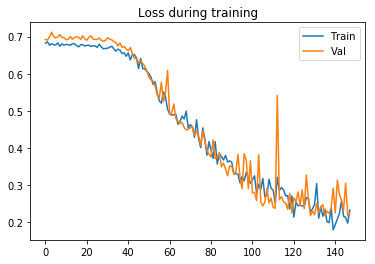

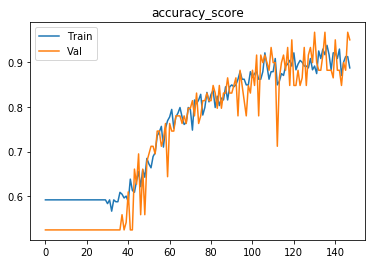

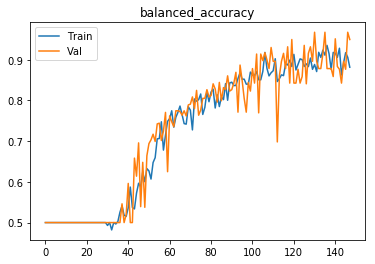

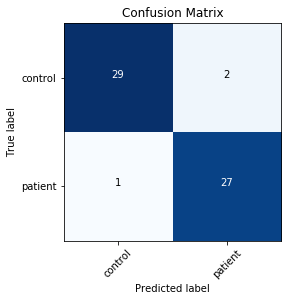

###### Starting inner fold 3
{'model': 'ModelBPIF', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 301895
[0,    10] loss: 0.67281
[0,    20] loss: 0.64214
[0,    30] loss: 0.66373
[0,    40] loss: 0.70712
[0,    50] loss: 0.69042
Time elapsed: 0h:0m:24s
train accuracy_score: 59.24 %
train balanced_accuracy: 50.00 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.689454
[1,    10] loss: 0.67557
[1,    20] loss: 0.68092
[1,    30] loss: 0.71178
[1,    40] loss: 0.69829
[1,    50] loss: 0.67097
Time elapsed: 0h:1m:1s
train accuracy_score: 59.24 %
train balanced_accuracy: 50.16 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.695289
[2,    10] loss: 0.66615
[2,    20] loss: 0.64657
[2,    30] loss: 0.69494
[2,    40] loss: 0.65361
[2,    50] loss: 0.70005
Time elapsed: 0h:1m:38s
train accuracy_score: 59.66 %
train balanced_accuracy: 50.52 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.6923

val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.667473
[28,    10] loss: 0.72577
[28,    20] loss: 0.61234
[28,    30] loss: 0.71058
[28,    40] loss: 0.63822
[28,    50] loss: 0.64681
Time elapsed: 0h:17m:41s
train accuracy_score: 62.61 %
train balanced_accuracy: 55.89 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.707946
[29,    10] loss: 0.72924
[29,    20] loss: 0.58825
[29,    30] loss: 0.66302
[29,    40] loss: 0.62508
[29,    50] loss: 0.67261
Time elapsed: 0h:18m:18s
train accuracy_score: 61.34 %
train balanced_accuracy: 52.90 %
val accuracy_score: 62.71 %
val balanced_accuracy: 60.71 %
Val loss: 0.637750
[30,    10] loss: 0.60070
[30,    20] loss: 0.69519
[30,    30] loss: 0.66186
[30,    40] loss: 0.61680
[30,    50] loss: 0.62303
Time elapsed: 0h:18m:55s
train accuracy_score: 61.34 %
train balanced_accuracy: 56.44 %
val accuracy_score: 54.24 %
val balanced_accuracy: 51.79 %
Val loss: 0.630503
[31,    10] loss: 0.60836
[31,    

Time elapsed: 0h:34m:25s
train accuracy_score: 78.57 %
train balanced_accuracy: 77.25 %
val accuracy_score: 76.27 %
val balanced_accuracy: 76.04 %
Val loss: 0.462679
[56,    10] loss: 0.40375
[56,    20] loss: 0.36321
[56,    30] loss: 0.47658
[56,    40] loss: 0.43441
[56,    50] loss: 0.49991
Time elapsed: 0h:35m:2s
train accuracy_score: 82.77 %
train balanced_accuracy: 82.24 %
val accuracy_score: 79.66 %
val balanced_accuracy: 78.92 %
Val loss: 0.509435
[57,    10] loss: 0.50634
[57,    20] loss: 0.53018
[57,    30] loss: 0.39175
[57,    40] loss: 0.38858
[57,    50] loss: 0.27252
Time elapsed: 0h:35m:39s
train accuracy_score: 81.09 %
train balanced_accuracy: 79.86 %
val accuracy_score: 71.19 %
val balanced_accuracy: 69.64 %
Val loss: 0.681834
[58,    10] loss: 0.41067
[58,    20] loss: 0.39462
[58,    30] loss: 0.49721
[58,    40] loss: 0.51126
[58,    50] loss: 0.52585
Time elapsed: 0h:36m:16s
train accuracy_score: 78.15 %
train balanced_accuracy: 76.25 %
val accuracy_score: 74.58

[83,    30] loss: 0.32334
[83,    40] loss: 0.36438
[83,    50] loss: 0.23005
Time elapsed: 0h:51m:44s
train accuracy_score: 89.08 %
train balanced_accuracy: 88.69 %
val accuracy_score: 83.05 %
val balanced_accuracy: 82.49 %
Val loss: 0.350891
[84,    10] loss: 0.23706
[84,    20] loss: 0.18625
[84,    30] loss: 0.19646
[84,    40] loss: 0.13892
[84,    50] loss: 0.30616
Time elapsed: 0h:52m:21s
train accuracy_score: 89.50 %
train balanced_accuracy: 88.72 %
val accuracy_score: 89.83 %
val balanced_accuracy: 89.63 %
Val loss: 0.303075
[85,    10] loss: 0.23832
[85,    20] loss: 0.17027
[85,    30] loss: 0.31504
[85,    40] loss: 0.17951
[85,    50] loss: 0.27821
Time elapsed: 0h:52m:59s
train accuracy_score: 90.34 %
train balanced_accuracy: 89.91 %
val accuracy_score: 77.97 %
val balanced_accuracy: 76.96 %
Val loss: 0.430103
[86,    10] loss: 0.33911
[86,    20] loss: 0.26810
[86,    30] loss: 0.15936
[86,    40] loss: 0.21331
[86,    50] loss: 0.22513
Time elapsed: 0h:53m:36s
train acc

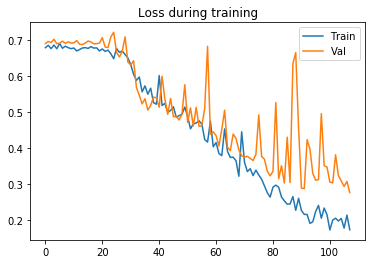

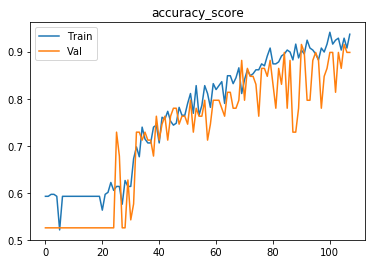

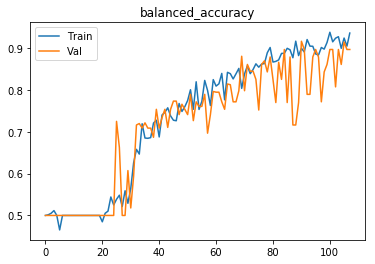

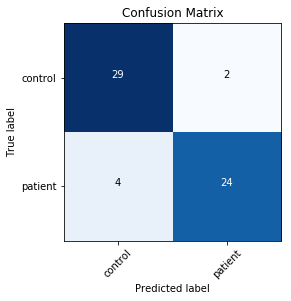

###### Starting inner fold 4
{'model': 'ModelBPIF', 'batch_size': 12, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 301895
[0,    10] loss: 0.69154
Time elapsed: 0h:0m:26s
train accuracy_score: 60.08 %
train balanced_accuracy: 54.09 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.693063
[1,    10] loss: 0.67659
Time elapsed: 0h:1m:5s
train accuracy_score: 59.24 %
train balanced_accuracy: 50.00 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.695799
[2,    10] loss: 0.66880
Time elapsed: 0h:1m:43s
train accuracy_score: 59.24 %
train balanced_accuracy: 50.00 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.700919
[3,    10] loss: 0.68217
Time elapsed: 0h:2m:21s
train accuracy_score: 59.24 %
train balanced_accuracy: 50.00 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.696007
[4,    10] loss: 0.68194
Time elapsed: 0h:3m:0s
train accuracy_score: 59.24 %
train balanced_accuracy: 50.0

val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.694779
[43,    10] loss: 0.67877
Time elapsed: 0h:28m:2s
train accuracy_score: 59.24 %
train balanced_accuracy: 50.00 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.697701
[44,    10] loss: 0.68647
Time elapsed: 0h:28m:40s
train accuracy_score: 59.24 %
train balanced_accuracy: 50.00 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.688174
[45,    10] loss: 0.66339
Time elapsed: 0h:29m:18s
train accuracy_score: 59.24 %
train balanced_accuracy: 50.00 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.690009
[46,    10] loss: 0.65332
Time elapsed: 0h:29m:56s
train accuracy_score: 59.24 %
train balanced_accuracy: 50.00 %
val accuracy_score: 52.54 %
val balanced_accuracy: 50.00 %
Val loss: 0.692392
[47,    10] loss: 0.69226
Time elapsed: 0h:30m:35s
train accuracy_score: 59.24 %
train balanced_accuracy: 50.00 %
val accuracy_score: 52.54 %
val balanced_

val accuracy_score: 55.93 %
val balanced_accuracy: 53.57 %
Val loss: 0.640887
[86,    10] loss: 0.61113
Time elapsed: 0h:55m:31s
train accuracy_score: 67.65 %
train balanced_accuracy: 63.69 %
val accuracy_score: 62.71 %
val balanced_accuracy: 61.06 %
Val loss: 0.602393
[87,    10] loss: 0.62941
Time elapsed: 0h:56m:9s
train accuracy_score: 71.01 %
train balanced_accuracy: 68.62 %
val accuracy_score: 59.32 %
val balanced_accuracy: 57.49 %
Val loss: 0.596871
[88,    10] loss: 0.52524
Time elapsed: 0h:56m:49s
train accuracy_score: 67.65 %
train balanced_accuracy: 62.40 %
val accuracy_score: 74.58 %
val balanced_accuracy: 74.94 %
Val loss: 0.572665
[89,    10] loss: 0.58989
Time elapsed: 0h:57m:27s
train accuracy_score: 69.75 %
train balanced_accuracy: 66.26 %
val accuracy_score: 81.36 %
val balanced_accuracy: 81.05 %
Val loss: 0.563570
[90,    10] loss: 0.55911
Time elapsed: 0h:58m:5s
train accuracy_score: 67.65 %
train balanced_accuracy: 63.20 %
val accuracy_score: 74.58 %
val balanced_a

val accuracy_score: 76.27 %
val balanced_accuracy: 75.69 %
Val loss: 0.431351
[129,    10] loss: 0.43848
Time elapsed: 1h:23m:2s
train accuracy_score: 76.89 %
train balanced_accuracy: 73.42 %
val accuracy_score: 84.75 %
val balanced_accuracy: 85.31 %
Val loss: 0.430233
[130,    10] loss: 0.39598
Time elapsed: 1h:23m:41s
train accuracy_score: 82.35 %
train balanced_accuracy: 82.37 %
val accuracy_score: 81.36 %
val balanced_accuracy: 82.09 %
Val loss: 0.457203
[131,    10] loss: 0.43644
Time elapsed: 1h:24m:19s
train accuracy_score: 83.61 %
train balanced_accuracy: 82.15 %
val accuracy_score: 83.05 %
val balanced_accuracy: 83.35 %
Val loss: 0.409200
[132,    10] loss: 0.41403
Time elapsed: 1h:24m:58s
train accuracy_score: 81.51 %
train balanced_accuracy: 80.54 %
val accuracy_score: 83.05 %
val balanced_accuracy: 83.01 %
Val loss: 0.394981
[133,    10] loss: 0.45203
Time elapsed: 1h:25m:37s
train accuracy_score: 82.77 %
train balanced_accuracy: 80.96 %
val accuracy_score: 84.75 %
val bala

Time elapsed: 1h:50m:12s
train accuracy_score: 84.45 %
train balanced_accuracy: 83.18 %
val accuracy_score: 86.44 %
val balanced_accuracy: 86.92 %
Val loss: 0.314721
[172,    10] loss: 0.34648
Time elapsed: 1h:50m:51s
train accuracy_score: 85.71 %
train balanced_accuracy: 85.53 %
val accuracy_score: 91.53 %
val balanced_accuracy: 91.42 %
Val loss: 0.300962
[173,    10] loss: 0.32588
Time elapsed: 1h:51m:30s
train accuracy_score: 84.45 %
train balanced_accuracy: 83.34 %
val accuracy_score: 84.75 %
val balanced_accuracy: 85.14 %
Val loss: 0.305823
[174,    10] loss: 0.32371
Time elapsed: 1h:52m:8s
train accuracy_score: 84.03 %
train balanced_accuracy: 83.63 %
val accuracy_score: 91.53 %
val balanced_accuracy: 91.59 %
Val loss: 0.298037
[175,    10] loss: 0.31187
Time elapsed: 1h:52m:48s
train accuracy_score: 84.45 %
train balanced_accuracy: 82.54 %
val accuracy_score: 91.53 %
val balanced_accuracy: 91.59 %
Val loss: 0.301343
[176,    10] loss: 0.35552
Time elapsed: 1h:53m:27s
train accur

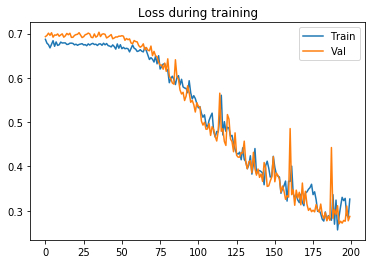

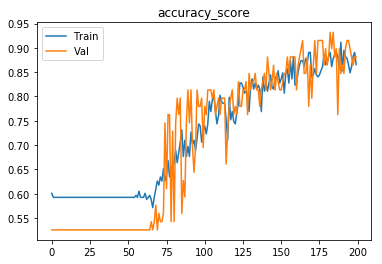

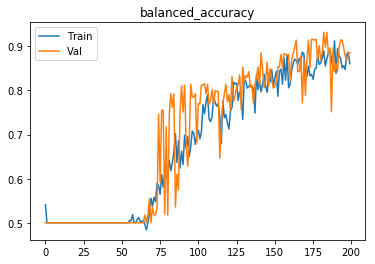

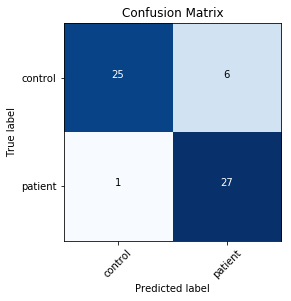

Finished outer fold.
{'final_acc': 0.9158986175115207, 'best_acc': 0.9337557603686636, 'final_iter': 164, 'best_iter': 148, 'params': {'model': 'ModelAPIF', 'batch_size': 12, 'patience': 16, 'lr': 5e-05}, 'inner_fold_idx': 0}
###### Starting outer fold 6
238
59
Shuffled the data..
###### Starting inner fold 0
{'model': 'ModelAPIF', 'batch_size': 4, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 1348665
[0,    10] loss: 0.69695
[0,    20] loss: 0.67427
[0,    30] loss: 0.72278
[0,    40] loss: 0.69847
[0,    50] loss: 0.69559
Time elapsed: 0h:0m:24s
train accuracy_score: 50.42 %
train balanced_accuracy: 48.11 %
val accuracy_score: 49.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.692491
[1,    10] loss: 0.69802
[1,    20] loss: 0.70384
[1,    30] loss: 0.69470
[1,    40] loss: 0.70490
[1,    50] loss: 0.67992
Time elapsed: 0h:1m:2s
train accuracy_score: 49.16 %
train balanced_accuracy: 47.04 %
val accuracy_score: 49.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.699492
[2,  

val accuracy_score: 49.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.689254
[27,    10] loss: 0.64998
[27,    20] loss: 0.70721
[27,    30] loss: 0.65123
[27,    40] loss: 0.69388
[27,    50] loss: 0.67035
Time elapsed: 0h:17m:23s
train accuracy_score: 53.78 %
train balanced_accuracy: 49.70 %
val accuracy_score: 49.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.683532
[28,    10] loss: 0.67363
[28,    20] loss: 0.66565
[28,    30] loss: 0.66235
[28,    40] loss: 0.68074
[28,    50] loss: 0.70521
Time elapsed: 0h:18m:0s
train accuracy_score: 58.82 %
train balanced_accuracy: 54.94 %
val accuracy_score: 61.02 %
val balanced_accuracy: 60.86 %
Val loss: 0.678234
[29,    10] loss: 0.69356
[29,    20] loss: 0.66375
[29,    30] loss: 0.69499
[29,    40] loss: 0.65363
[29,    50] loss: 0.70260
Time elapsed: 0h:18m:37s
train accuracy_score: 60.08 %
train balanced_accuracy: 58.84 %
val accuracy_score: 49.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.676407
[30,    10] loss: 0.68579
[30,    2

Time elapsed: 0h:34m:5s
train accuracy_score: 92.44 %
train balanced_accuracy: 92.45 %
val accuracy_score: 84.75 %
val balanced_accuracy: 84.77 %
Val loss: 0.353139
[55,    10] loss: 0.25402
[55,    20] loss: 0.18411
[55,    30] loss: 0.32612
[55,    40] loss: 0.30870
[55,    50] loss: 0.15830
Time elapsed: 0h:34m:42s
train accuracy_score: 89.92 %
train balanced_accuracy: 89.59 %
val accuracy_score: 81.36 %
val balanced_accuracy: 81.55 %
Val loss: 0.383238
[56,    10] loss: 0.25307
[56,    20] loss: 0.22290
[56,    30] loss: 0.23183
[56,    40] loss: 0.19555
[56,    50] loss: 0.20802
Time elapsed: 0h:35m:20s
train accuracy_score: 89.92 %
train balanced_accuracy: 89.75 %
val accuracy_score: 83.05 %
val balanced_accuracy: 82.87 %
Val loss: 0.405358
[57,    10] loss: 0.13564
[57,    20] loss: 0.22484
[57,    30] loss: 0.26178
[57,    40] loss: 0.28925
[57,    50] loss: 0.15415
Time elapsed: 0h:35m:57s
train accuracy_score: 92.02 %
train balanced_accuracy: 91.83 %
val accuracy_score: 79.66

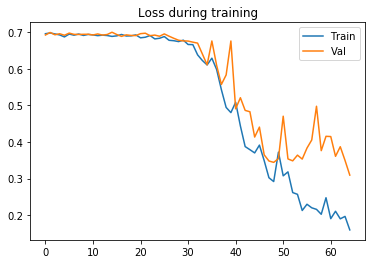

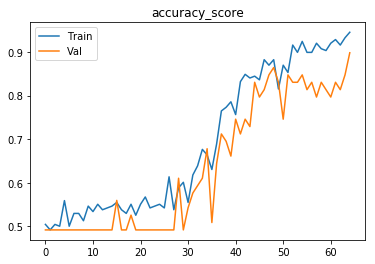

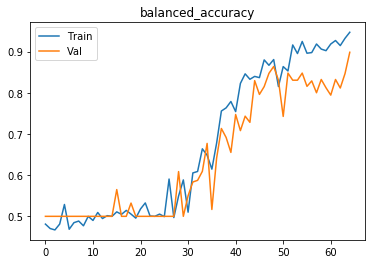

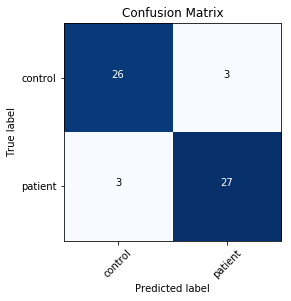

###### Starting inner fold 1
{'model': 'ModelAPIF', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 1348665
[0,    10] loss: 0.71535
[0,    20] loss: 0.68834
[0,    30] loss: 0.71561
[0,    40] loss: 0.69751
[0,    50] loss: 0.70500
Time elapsed: 0h:0m:25s
train accuracy_score: 47.90 %
train balanced_accuracy: 48.94 %
val accuracy_score: 49.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.697984
[1,    10] loss: 0.68534
[1,    20] loss: 0.67132
[1,    30] loss: 0.72963
[1,    40] loss: 0.69522
[1,    50] loss: 0.69405
Time elapsed: 0h:1m:3s
train accuracy_score: 50.84 %
train balanced_accuracy: 47.40 %
val accuracy_score: 49.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.692770
[2,    10] loss: 0.68559
[2,    20] loss: 0.70950
[2,    30] loss: 0.69578
[2,    40] loss: 0.69044
[2,    50] loss: 0.69365
Time elapsed: 0h:1m:40s
train accuracy_score: 52.10 %
train balanced_accuracy: 48.79 %
val accuracy_score: 49.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.696

val accuracy_score: 74.58 %
val balanced_accuracy: 74.83 %
Val loss: 0.566309
[28,    10] loss: 0.57221
[28,    20] loss: 0.52790
[28,    30] loss: 0.54439
[28,    40] loss: 0.39816
[28,    50] loss: 0.49370
Time elapsed: 0h:17m:46s
train accuracy_score: 77.73 %
train balanced_accuracy: 76.79 %
val accuracy_score: 74.58 %
val balanced_accuracy: 74.77 %
Val loss: 0.508597
[29,    10] loss: 0.44997
[29,    20] loss: 0.66900
[29,    30] loss: 0.46130
[29,    40] loss: 0.49801
[29,    50] loss: 0.47991
Time elapsed: 0h:18m:23s
train accuracy_score: 75.63 %
train balanced_accuracy: 74.95 %
val accuracy_score: 84.75 %
val balanced_accuracy: 84.60 %
Val loss: 0.470111
[30,    10] loss: 0.38165
[30,    20] loss: 0.43083
[30,    30] loss: 0.60515
[30,    40] loss: 0.59863
[30,    50] loss: 0.63124
Time elapsed: 0h:19m:1s
train accuracy_score: 76.05 %
train balanced_accuracy: 75.73 %
val accuracy_score: 77.97 %
val balanced_accuracy: 78.16 %
Val loss: 0.462544
[31,    10] loss: 0.38475
[31,    2

Time elapsed: 0h:34m:33s
train accuracy_score: 94.96 %
train balanced_accuracy: 94.99 %
val accuracy_score: 74.58 %
val balanced_accuracy: 75.00 %
Val loss: 0.748327
[56,    10] loss: 0.15759
[56,    20] loss: 0.08976
[56,    30] loss: 0.16512
[56,    40] loss: 0.07633
[56,    50] loss: 0.12469
Time elapsed: 0h:35m:10s
train accuracy_score: 92.86 %
train balanced_accuracy: 92.68 %
val accuracy_score: 79.66 %
val balanced_accuracy: 79.83 %
Val loss: 0.385244
[57,    10] loss: 0.04693
[57,    20] loss: 0.07662
[57,    30] loss: 0.04343
[57,    40] loss: 0.04967
[57,    50] loss: 0.03275
Time elapsed: 0h:35m:47s
train accuracy_score: 99.16 %
train balanced_accuracy: 99.15 %
val accuracy_score: 83.05 %
val balanced_accuracy: 83.28 %
Val loss: 0.610917
[58,    10] loss: 0.12926
[58,    20] loss: 0.01407
[58,    30] loss: 0.10813
[58,    40] loss: 0.26787
[58,    50] loss: 0.03116
Time elapsed: 0h:36m:25s
train accuracy_score: 93.70 %
train balanced_accuracy: 93.76 %
val accuracy_score: 79.6

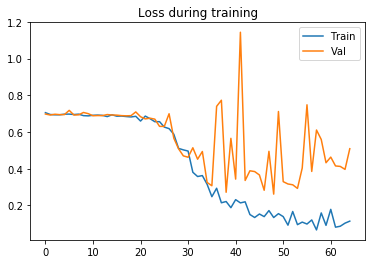

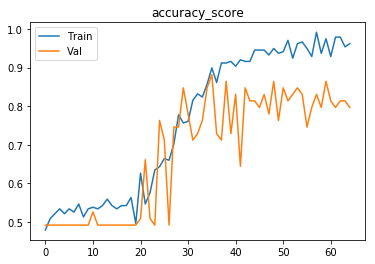

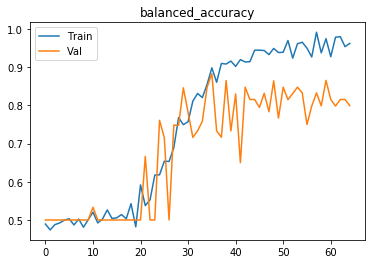

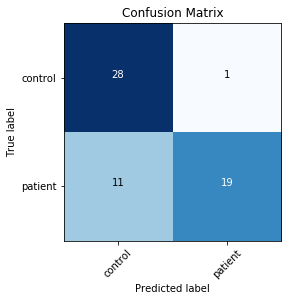

###### Starting inner fold 2
{'model': 'ModelBPIF', 'batch_size': 6, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 301895
[0,    10] loss: 0.67609
[0,    20] loss: 0.73431
[0,    30] loss: 0.69722
Time elapsed: 0h:0m:25s
train accuracy_score: 52.94 %
train balanced_accuracy: 49.32 %
val accuracy_score: 61.02 %
val balanced_accuracy: 61.15 %
Val loss: 0.692150
[1,    10] loss: 0.69203
[1,    20] loss: 0.70223
[1,    30] loss: 0.69697
Time elapsed: 0h:1m:3s
train accuracy_score: 48.74 %
train balanced_accuracy: 47.44 %
val accuracy_score: 49.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.694155
[2,    10] loss: 0.68284
[2,    20] loss: 0.72508
[2,    30] loss: 0.68291
Time elapsed: 0h:1m:40s
train accuracy_score: 57.14 %
train balanced_accuracy: 53.01 %
val accuracy_score: 49.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.692253
[3,    10] loss: 0.70029
[3,    20] loss: 0.69551
[3,    30] loss: 0.68510
Time elapsed: 0h:2m:17s
train accuracy_score: 50.42 %
train balanced_acc

Time elapsed: 0h:21m:30s
train accuracy_score: 56.72 %
train balanced_accuracy: 52.78 %
val accuracy_score: 49.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.684450
[34,    10] loss: 0.68628
[34,    20] loss: 0.69004
[34,    30] loss: 0.68626
Time elapsed: 0h:22m:7s
train accuracy_score: 53.36 %
train balanced_accuracy: 49.79 %
val accuracy_score: 49.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.679467
[35,    10] loss: 0.68710
[35,    20] loss: 0.68361
[35,    30] loss: 0.66498
Time elapsed: 0h:22m:45s
train accuracy_score: 57.98 %
train balanced_accuracy: 55.82 %
val accuracy_score: 49.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.680295
[36,    10] loss: 0.65013
[36,    20] loss: 0.68795
[36,    30] loss: 0.68198
Time elapsed: 0h:23m:22s
train accuracy_score: 58.82 %
train balanced_accuracy: 55.33 %
val accuracy_score: 74.58 %
val balanced_accuracy: 74.83 %
Val loss: 0.671325
[37,    10] loss: 0.67132
[37,    20] loss: 0.67897
[37,    30] loss: 0.72769
Time elapsed: 0h:24m:0s
t

[67,    10] loss: 0.38003
[67,    20] loss: 0.19188
[67,    30] loss: 0.35413
Time elapsed: 0h:42m:49s
train accuracy_score: 86.13 %
train balanced_accuracy: 85.90 %
val accuracy_score: 86.44 %
val balanced_accuracy: 86.32 %
Val loss: 0.363228
[68,    10] loss: 0.32791
[68,    20] loss: 0.21139
[68,    30] loss: 0.41357
Time elapsed: 0h:43m:26s
train accuracy_score: 84.45 %
train balanced_accuracy: 83.97 %
val accuracy_score: 72.88 %
val balanced_accuracy: 72.87 %
Val loss: 0.446303
[69,    10] loss: 0.27901
[69,    20] loss: 0.28737
[69,    30] loss: 0.24947
Time elapsed: 0h:44m:4s
train accuracy_score: 92.44 %
train balanced_accuracy: 92.29 %
val accuracy_score: 81.36 %
val balanced_accuracy: 81.21 %
Val loss: 0.413649
[70,    10] loss: 0.28886
[70,    20] loss: 0.31093
[70,    30] loss: 0.25802
Time elapsed: 0h:44m:43s
train accuracy_score: 87.82 %
train balanced_accuracy: 87.75 %
val accuracy_score: 81.36 %
val balanced_accuracy: 81.15 %
Val loss: 0.402905
[71,    10] loss: 0.28112

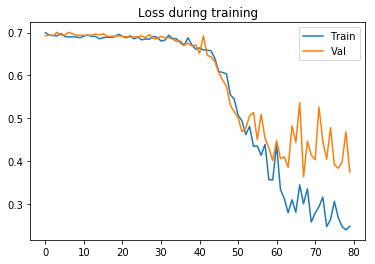

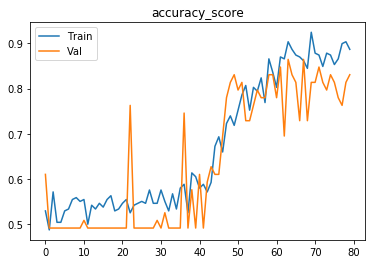

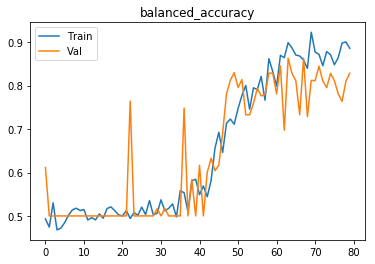

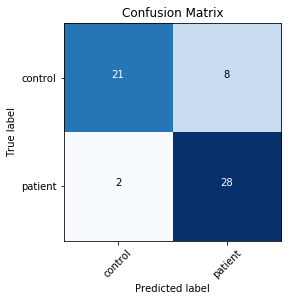

###### Starting inner fold 3
{'model': 'ModelBPIF', 'batch_size': 12, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 301895
[0,    10] loss: 0.69460
Time elapsed: 0h:0m:36s
train accuracy_score: 48.74 %
train balanced_accuracy: 46.73 %
val accuracy_score: 49.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.692955
[1,    10] loss: 0.69143
Time elapsed: 0h:1m:14s
train accuracy_score: 54.62 %
train balanced_accuracy: 50.00 %
val accuracy_score: 49.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.697062
[2,    10] loss: 0.68616
Time elapsed: 0h:1m:53s
train accuracy_score: 54.62 %
train balanced_accuracy: 50.00 %
val accuracy_score: 49.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.702695
[3,    10] loss: 0.68804
Time elapsed: 0h:2m:32s
train accuracy_score: 54.62 %
train balanced_accuracy: 50.00 %
val accuracy_score: 49.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.694114
[4,    10] loss: 0.68973
Time elapsed: 0h:3m:10s
train accuracy_score: 54.62 %
train balanced_accuracy: 50

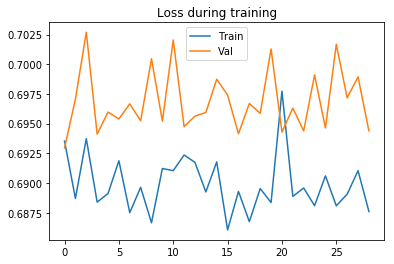

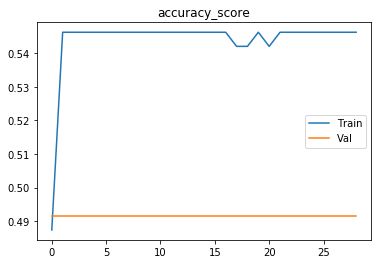

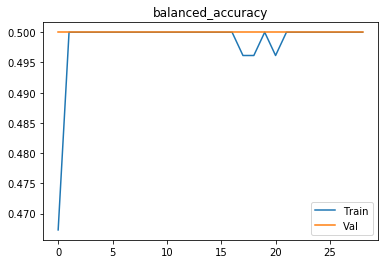

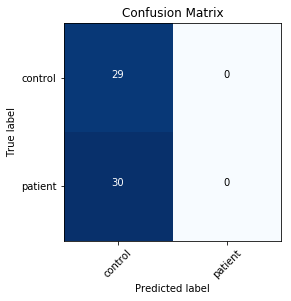

###### Starting inner fold 4
{'model': 'ModelBPIF', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 301895
[0,    10] loss: 0.68974
[0,    20] loss: 0.68602
[0,    30] loss: 0.70225
[0,    40] loss: 0.68390
[0,    50] loss: 0.68718
Time elapsed: 0h:0m:25s
train accuracy_score: 54.62 %
train balanced_accuracy: 50.00 %
val accuracy_score: 49.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.694853
[1,    10] loss: 0.68845
[1,    20] loss: 0.67806
[1,    30] loss: 0.68688
[1,    40] loss: 0.68703
[1,    50] loss: 0.70606
Time elapsed: 0h:1m:4s
train accuracy_score: 54.62 %
train balanced_accuracy: 50.00 %
val accuracy_score: 49.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.697181
[2,    10] loss: 0.70059
[2,    20] loss: 0.69990
[2,    30] loss: 0.68549
[2,    40] loss: 0.68769
[2,    50] loss: 0.67915
Time elapsed: 0h:1m:42s
train accuracy_score: 54.62 %
train balanced_accuracy: 50.00 %
val accuracy_score: 49.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.69476

val accuracy_score: 49.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.689610
[28,    10] loss: 0.70123
[28,    20] loss: 0.67674
[28,    30] loss: 0.69259
[28,    40] loss: 0.69280
[28,    50] loss: 0.66955
Time elapsed: 0h:18m:7s
train accuracy_score: 57.56 %
train balanced_accuracy: 54.18 %
val accuracy_score: 49.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.693184
[29,    10] loss: 0.69537
[29,    20] loss: 0.70287
[29,    30] loss: 0.69723
[29,    40] loss: 0.68297
[29,    50] loss: 0.66923
Time elapsed: 0h:18m:44s
train accuracy_score: 54.20 %
train balanced_accuracy: 49.77 %
val accuracy_score: 49.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.701859
[30,    10] loss: 0.72246
[30,    20] loss: 0.68457
[30,    30] loss: 0.69187
[30,    40] loss: 0.66464
[30,    50] loss: 0.65660
Time elapsed: 0h:19m:22s
train accuracy_score: 54.62 %
train balanced_accuracy: 50.00 %
val accuracy_score: 49.15 %
val balanced_accuracy: 50.00 %
Val loss: 0.691928
[31,    10] loss: 0.68233
[31,    2

Time elapsed: 0h:35m:10s
train accuracy_score: 76.89 %
train balanced_accuracy: 76.26 %
val accuracy_score: 64.41 %
val balanced_accuracy: 64.94 %
Val loss: 0.590274
[56,    10] loss: 0.57998
[56,    20] loss: 0.58123
[56,    30] loss: 0.49023
[56,    40] loss: 0.48156
[56,    50] loss: 0.38926
Time elapsed: 0h:35m:48s
train accuracy_score: 76.89 %
train balanced_accuracy: 76.26 %
val accuracy_score: 76.27 %
val balanced_accuracy: 76.38 %
Val loss: 0.515291
[57,    10] loss: 0.52997
[57,    20] loss: 0.49293
[57,    30] loss: 0.41552
[57,    40] loss: 0.42889
[57,    50] loss: 0.44894
Time elapsed: 0h:36m:26s
train accuracy_score: 77.73 %
train balanced_accuracy: 76.95 %
val accuracy_score: 76.27 %
val balanced_accuracy: 76.49 %
Val loss: 0.510101
[58,    10] loss: 0.45746
[58,    20] loss: 0.52383
[58,    30] loss: 0.45813
[58,    40] loss: 0.49183
[58,    50] loss: 0.38366
Time elapsed: 0h:37m:3s
train accuracy_score: 79.41 %
train balanced_accuracy: 78.88 %
val accuracy_score: 79.66

[83,    30] loss: 0.24902
[83,    40] loss: 0.28182
[83,    50] loss: 0.42928
Time elapsed: 0h:52m:54s
train accuracy_score: 88.24 %
train balanced_accuracy: 87.98 %
val accuracy_score: 76.27 %
val balanced_accuracy: 76.49 %
Val loss: 0.398752
[84,    10] loss: 0.28712
[84,    20] loss: 0.27043
[84,    30] loss: 0.35802
[84,    40] loss: 0.37834
[84,    50] loss: 0.31361
Time elapsed: 0h:53m:30s
train accuracy_score: 86.13 %
train balanced_accuracy: 85.98 %
val accuracy_score: 79.66 %
val balanced_accuracy: 79.89 %
Val loss: 0.372970
[85,    10] loss: 0.32871
[85,    20] loss: 0.32806
[85,    30] loss: 0.17406
[85,    40] loss: 0.34527
[85,    50] loss: 0.39126
Time elapsed: 0h:54m:8s
train accuracy_score: 85.29 %
train balanced_accuracy: 84.89 %
val accuracy_score: 77.97 %
val balanced_accuracy: 78.05 %
Val loss: 0.390402
[86,    10] loss: 0.19007
[86,    20] loss: 0.27483
[86,    30] loss: 0.37740
[86,    40] loss: 0.36922
[86,    50] loss: 0.28343
Time elapsed: 0h:54m:47s
train accu

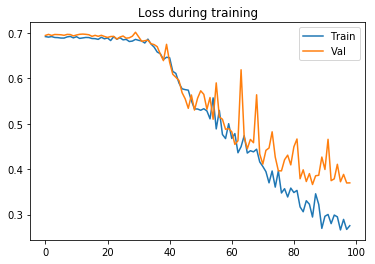

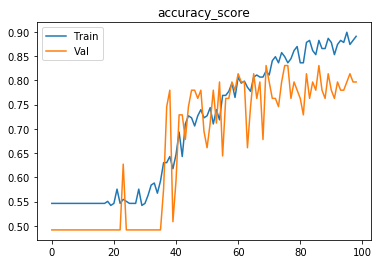

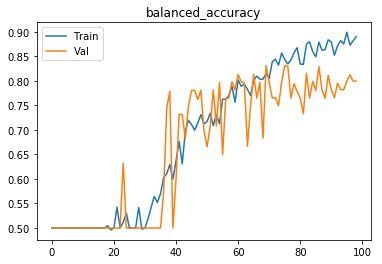

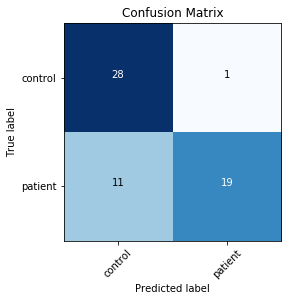

Finished outer fold.
{'final_acc': 0.8982758620689655, 'best_acc': 0.8982758620689655, 'final_iter': 65, 'best_iter': 65, 'params': {'model': 'ModelAPIF', 'batch_size': 4, 'patience': 16, 'lr': 5e-05}, 'inner_fold_idx': 0}
###### Starting outer fold 7
238
59
Shuffled the data..
###### Starting inner fold 0
{'model': 'ModelAPIF', 'batch_size': 12, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 1348665
[0,    10] loss: 0.69480
Time elapsed: 0h:0m:27s
train accuracy_score: 49.58 %
train balanced_accuracy: 47.53 %
val accuracy_score: 59.32 %
val balanced_accuracy: 50.00 %
Val loss: 0.677478
[1,    10] loss: 0.69169
Time elapsed: 0h:1m:8s
train accuracy_score: 53.36 %
train balanced_accuracy: 52.33 %
val accuracy_score: 59.32 %
val balanced_accuracy: 50.00 %
Val loss: 0.688446
[2,    10] loss: 0.69173
Time elapsed: 0h:1m:48s
train accuracy_score: 50.84 %
train balanced_accuracy: 47.92 %
val accuracy_score: 59.32 %
val balanced_accuracy: 50.00 %
Val loss: 0.675340
[3,    10] loss: 

[41,    10] loss: 0.63395
Time elapsed: 0h:27m:53s
train accuracy_score: 68.07 %
train balanced_accuracy: 67.58 %
val accuracy_score: 61.02 %
val balanced_accuracy: 56.01 %
Val loss: 0.650911
[42,    10] loss: 0.60651
Time elapsed: 0h:28m:34s
train accuracy_score: 69.75 %
train balanced_accuracy: 68.25 %
val accuracy_score: 42.37 %
val balanced_accuracy: 51.43 %
Val loss: 0.755305
[43,    10] loss: 0.63725
Time elapsed: 0h:29m:13s
train accuracy_score: 64.29 %
train balanced_accuracy: 64.83 %
val accuracy_score: 61.02 %
val balanced_accuracy: 56.01 %
Val loss: 0.640605
[44,    10] loss: 0.64383
Time elapsed: 0h:29m:53s
train accuracy_score: 68.91 %
train balanced_accuracy: 68.09 %
val accuracy_score: 55.93 %
val balanced_accuracy: 53.04 %
Val loss: 0.647425
[45,    10] loss: 0.60162
Time elapsed: 0h:30m:33s
train accuracy_score: 70.59 %
train balanced_accuracy: 70.34 %
val accuracy_score: 61.02 %
val balanced_accuracy: 58.63 %
Val loss: 0.662841
[46,    10] loss: 0.59121
Time elapsed: 

[84,    10] loss: 0.39529
Time elapsed: 0h:56m:39s
train accuracy_score: 81.09 %
train balanced_accuracy: 81.26 %
val accuracy_score: 61.02 %
val balanced_accuracy: 65.18 %
Val loss: 0.650256
[85,    10] loss: 0.52511
Time elapsed: 0h:57m:19s
train accuracy_score: 73.11 %
train balanced_accuracy: 72.93 %
val accuracy_score: 74.58 %
val balanced_accuracy: 70.71 %
Val loss: 0.497832
[86,    10] loss: 0.48549
Time elapsed: 0h:58m:0s
train accuracy_score: 81.09 %
train balanced_accuracy: 80.52 %
val accuracy_score: 76.27 %
val balanced_accuracy: 72.80 %
Val loss: 0.484371
[87,    10] loss: 0.45678
Time elapsed: 0h:58m:40s
train accuracy_score: 81.09 %
train balanced_accuracy: 80.98 %
val accuracy_score: 77.97 %
val balanced_accuracy: 74.88 %
Val loss: 0.483413
[88,    10] loss: 0.39491
Time elapsed: 0h:59m:20s
train accuracy_score: 85.29 %
train balanced_accuracy: 85.09 %
val accuracy_score: 79.66 %
val balanced_accuracy: 78.27 %
Val loss: 0.476601
[89,    10] loss: 0.44658
Time elapsed: 1

[127,    10] loss: 0.27188
Time elapsed: 1h:25m:32s
train accuracy_score: 88.66 %
train balanced_accuracy: 88.69 %
val accuracy_score: 79.66 %
val balanced_accuracy: 81.55 %
Val loss: 0.379622
[128,    10] loss: 0.25460
Time elapsed: 1h:26m:11s
train accuracy_score: 88.66 %
train balanced_accuracy: 88.63 %
val accuracy_score: 79.66 %
val balanced_accuracy: 80.89 %
Val loss: 0.386836
[129,    10] loss: 0.29875
Time elapsed: 1h:26m:51s
train accuracy_score: 87.82 %
train balanced_accuracy: 87.67 %
val accuracy_score: 69.49 %
val balanced_accuracy: 62.50 %
Val loss: 0.559671
[130,    10] loss: 0.27190
Time elapsed: 1h:27m:31s
train accuracy_score: 87.82 %
train balanced_accuracy: 87.39 %
val accuracy_score: 79.66 %
val balanced_accuracy: 81.55 %
Val loss: 0.383400
[131,    10] loss: 0.25055
Time elapsed: 1h:28m:11s
train accuracy_score: 89.92 %
train balanced_accuracy: 90.04 %
val accuracy_score: 79.66 %
val balanced_accuracy: 81.55 %
Val loss: 0.364347
[132,    10] loss: 0.27507
Time ela

val accuracy_score: 76.27 %
val balanced_accuracy: 78.69 %
Val loss: 0.391192
[170,    10] loss: 0.14411
Time elapsed: 1h:54m:14s
train accuracy_score: 93.28 %
train balanced_accuracy: 93.19 %
val accuracy_score: 83.05 %
val balanced_accuracy: 84.40 %
Val loss: 0.385730
[171,    10] loss: 0.15646
Time elapsed: 1h:54m:54s
train accuracy_score: 92.86 %
train balanced_accuracy: 92.74 %
val accuracy_score: 84.75 %
val balanced_accuracy: 83.87 %
Val loss: 0.328836
[172,    10] loss: 0.14101
Time elapsed: 1h:55m:36s
train accuracy_score: 93.28 %
train balanced_accuracy: 93.25 %
val accuracy_score: 74.58 %
val balanced_accuracy: 77.92 %
Val loss: 0.467565
[173,    10] loss: 0.20211
Time elapsed: 1h:56m:16s
train accuracy_score: 91.18 %
train balanced_accuracy: 91.05 %
val accuracy_score: 83.05 %
val balanced_accuracy: 81.79 %
Val loss: 0.327204
[174,    10] loss: 0.15315
Time elapsed: 1h:56m:56s
train accuracy_score: 94.96 %
train balanced_accuracy: 94.88 %
val accuracy_score: 84.75 %
val bal

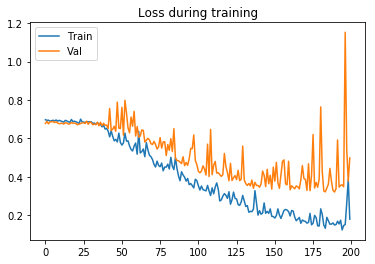

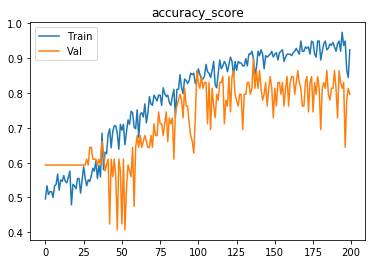

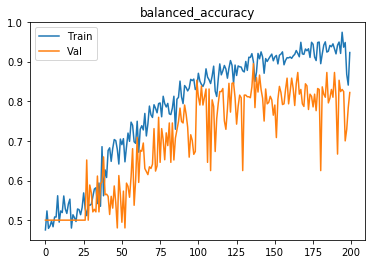

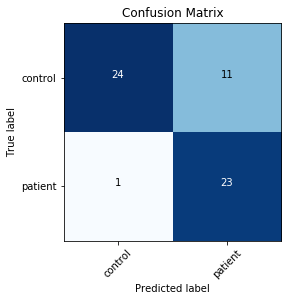

###### Starting inner fold 1
{'model': 'ModelAPIF', 'batch_size': 12, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 1348665
[0,    10] loss: 0.69599
Time elapsed: 0h:0m:26s
train accuracy_score: 50.84 %
train balanced_accuracy: 48.49 %
val accuracy_score: 59.32 %
val balanced_accuracy: 50.00 %
Val loss: 0.682800
[1,    10] loss: 0.68159
Time elapsed: 0h:1m:6s
train accuracy_score: 53.36 %
train balanced_accuracy: 50.00 %
val accuracy_score: 59.32 %
val balanced_accuracy: 50.00 %
Val loss: 0.679079
[2,    10] loss: 0.69772
Time elapsed: 0h:1m:46s
train accuracy_score: 50.42 %
train balanced_accuracy: 48.21 %
val accuracy_score: 59.32 %
val balanced_accuracy: 50.00 %
Val loss: 0.687323
[3,    10] loss: 0.69186
Time elapsed: 0h:2m:26s
train accuracy_score: 53.36 %
train balanced_accuracy: 50.85 %
val accuracy_score: 59.32 %
val balanced_accuracy: 50.00 %
Val loss: 0.683206
[4,    10] loss: 0.69908
Time elapsed: 0h:3m:5s
train accuracy_score: 53.78 %
train balanced_accuracy: 50.

val accuracy_score: 62.71 %
val balanced_accuracy: 54.17 %
Val loss: 0.674757
[43,    10] loss: 0.68361
Time elapsed: 0h:28m:54s
train accuracy_score: 63.87 %
train balanced_accuracy: 63.81 %
val accuracy_score: 61.02 %
val balanced_accuracy: 52.08 %
Val loss: 0.670018
[44,    10] loss: 0.65638
Time elapsed: 0h:29m:33s
train accuracy_score: 59.24 %
train balanced_accuracy: 56.87 %
val accuracy_score: 61.02 %
val balanced_accuracy: 52.08 %
Val loss: 0.661991
[45,    10] loss: 0.66474
Time elapsed: 0h:30m:13s
train accuracy_score: 60.50 %
train balanced_accuracy: 59.70 %
val accuracy_score: 72.88 %
val balanced_accuracy: 73.21 %
Val loss: 0.677760
[46,    10] loss: 0.67680
Time elapsed: 0h:30m:53s
train accuracy_score: 59.66 %
train balanced_accuracy: 59.88 %
val accuracy_score: 66.10 %
val balanced_accuracy: 60.30 %
Val loss: 0.672798
[47,    10] loss: 0.67620
Time elapsed: 0h:31m:33s
train accuracy_score: 63.45 %
train balanced_accuracy: 62.23 %
val accuracy_score: 64.41 %
val balanced

val accuracy_score: 79.66 %
val balanced_accuracy: 78.93 %
Val loss: 0.456964
[86,    10] loss: 0.37926
Time elapsed: 0h:57m:26s
train accuracy_score: 83.19 %
train balanced_accuracy: 83.06 %
val accuracy_score: 74.58 %
val balanced_accuracy: 77.26 %
Val loss: 0.520856
[87,    10] loss: 0.38732
Time elapsed: 0h:58m:6s
train accuracy_score: 81.09 %
train balanced_accuracy: 80.92 %
val accuracy_score: 77.97 %
val balanced_accuracy: 74.23 %
Val loss: 0.450324
[88,    10] loss: 0.35901
Time elapsed: 0h:58m:45s
train accuracy_score: 88.24 %
train balanced_accuracy: 88.13 %
val accuracy_score: 76.27 %
val balanced_accuracy: 78.04 %
Val loss: 0.464231
[89,    10] loss: 0.34626
Time elapsed: 0h:59m:25s
train accuracy_score: 81.93 %
train balanced_accuracy: 81.65 %
val accuracy_score: 77.97 %
val balanced_accuracy: 78.81 %
Val loss: 0.457765
[90,    10] loss: 0.33098
Time elapsed: 1h:0m:4s
train accuracy_score: 79.41 %
train balanced_accuracy: 79.18 %
val accuracy_score: 77.97 %
val balanced_ac

val accuracy_score: 83.05 %
val balanced_accuracy: 84.40 %
Val loss: 0.362788
[129,    10] loss: 0.23334
Time elapsed: 1h:26m:0s
train accuracy_score: 90.34 %
train balanced_accuracy: 90.49 %
val accuracy_score: 84.75 %
val balanced_accuracy: 81.90 %
Val loss: 0.350086
[130,    10] loss: 0.22885
Time elapsed: 1h:26m:40s
train accuracy_score: 91.60 %
train balanced_accuracy: 91.39 %
val accuracy_score: 83.05 %
val balanced_accuracy: 80.48 %
Val loss: 0.338853
[131,    10] loss: 0.23598
Time elapsed: 1h:27m:20s
train accuracy_score: 88.66 %
train balanced_accuracy: 88.58 %
val accuracy_score: 84.75 %
val balanced_accuracy: 86.49 %
Val loss: 0.363410
[132,    10] loss: 0.17607
Time elapsed: 1h:27m:59s
train accuracy_score: 92.86 %
train balanced_accuracy: 92.63 %
val accuracy_score: 86.44 %
val balanced_accuracy: 87.26 %
Val loss: 0.326048
[133,    10] loss: 0.21503
Time elapsed: 1h:28m:39s
train accuracy_score: 90.76 %
train balanced_accuracy: 90.60 %
val accuracy_score: 86.44 %
val bala

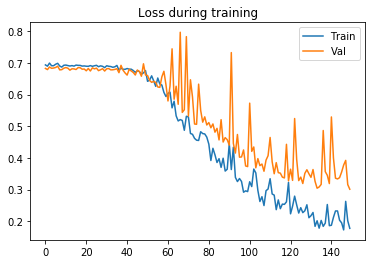

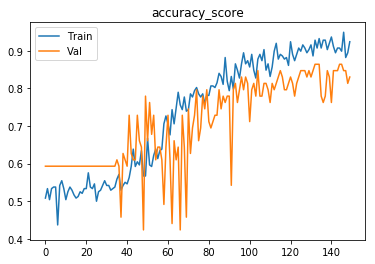

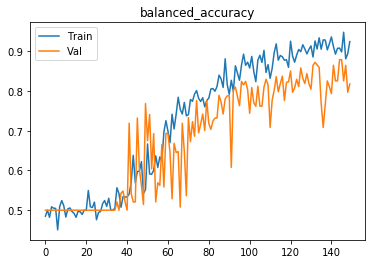

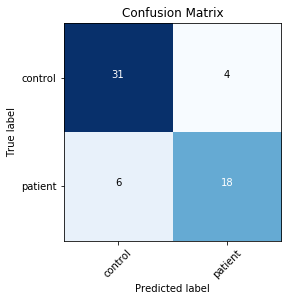

###### Starting inner fold 2
{'model': 'ModelBPIF', 'batch_size': 12, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 301895
[0,    10] loss: 0.69460
Time elapsed: 0h:0m:26s
train accuracy_score: 52.10 %
train balanced_accuracy: 48.82 %
val accuracy_score: 59.32 %
val balanced_accuracy: 50.00 %
Val loss: 0.688482
[1,    10] loss: 0.69222
Time elapsed: 0h:1m:5s
train accuracy_score: 53.36 %
train balanced_accuracy: 50.00 %
val accuracy_score: 59.32 %
val balanced_accuracy: 50.00 %
Val loss: 0.684794
[2,    10] loss: 0.69064
Time elapsed: 0h:1m:45s
train accuracy_score: 53.36 %
train balanced_accuracy: 50.00 %
val accuracy_score: 59.32 %
val balanced_accuracy: 50.00 %
Val loss: 0.684047
[3,    10] loss: 0.69527
Time elapsed: 0h:2m:27s
train accuracy_score: 53.36 %
train balanced_accuracy: 50.00 %
val accuracy_score: 59.32 %
val balanced_accuracy: 50.00 %
Val loss: 0.681080
[4,    10] loss: 0.68717
Time elapsed: 0h:3m:7s
train accuracy_score: 53.36 %
train balanced_accuracy: 50.0

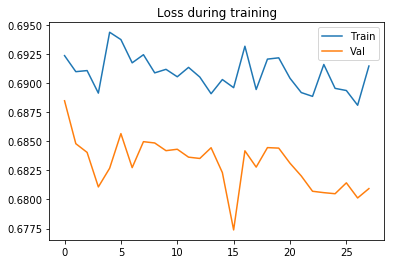

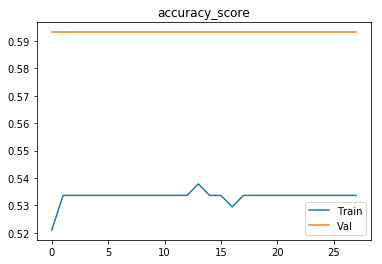

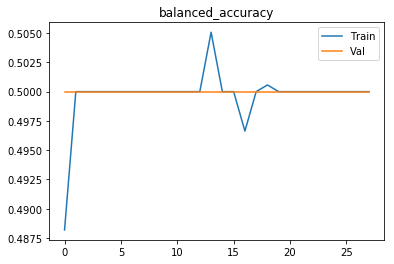

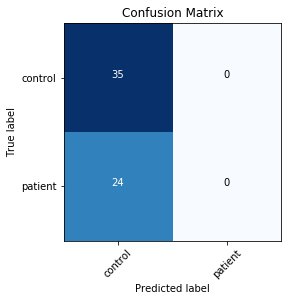

###### Starting inner fold 3
{'model': 'ModelBPIF', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 301895
[0,    10] loss: 0.69541
Time elapsed: 0h:0m:27s
train accuracy_score: 53.36 %
train balanced_accuracy: 50.00 %
val accuracy_score: 59.32 %
val balanced_accuracy: 50.00 %
Val loss: 0.682558
[1,    10] loss: 0.69108
Time elapsed: 0h:1m:7s
train accuracy_score: 53.36 %
train balanced_accuracy: 50.00 %
val accuracy_score: 59.32 %
val balanced_accuracy: 50.00 %
Val loss: 0.684680
[2,    10] loss: 0.68181
Time elapsed: 0h:1m:47s
train accuracy_score: 53.36 %
train balanced_accuracy: 50.00 %
val accuracy_score: 59.32 %
val balanced_accuracy: 50.00 %
Val loss: 0.683887
[3,    10] loss: 0.69581
Time elapsed: 0h:2m:27s
train accuracy_score: 51.68 %
train balanced_accuracy: 48.43 %
val accuracy_score: 59.32 %
val balanced_accuracy: 50.00 %
Val loss: 0.686359
[4,    10] loss: 0.68841
Time elapsed: 0h:3m:7s
train accuracy_score: 53.36 %
train balanced_accuracy: 50.

val accuracy_score: 64.41 %
val balanced_accuracy: 56.25 %
Val loss: 0.630615
[43,    10] loss: 0.57895
Time elapsed: 0h:29m:9s
train accuracy_score: 70.17 %
train balanced_accuracy: 69.66 %
val accuracy_score: 66.10 %
val balanced_accuracy: 58.33 %
Val loss: 0.642027
[44,    10] loss: 0.57936
Time elapsed: 0h:29m:49s
train accuracy_score: 66.81 %
train balanced_accuracy: 66.51 %
val accuracy_score: 62.71 %
val balanced_accuracy: 55.48 %
Val loss: 0.616650
[45,    10] loss: 0.58749
Time elapsed: 0h:30m:29s
train accuracy_score: 70.17 %
train balanced_accuracy: 69.83 %
val accuracy_score: 61.02 %
val balanced_accuracy: 56.01 %
Val loss: 0.609437
[46,    10] loss: 0.52266
Time elapsed: 0h:31m:8s
train accuracy_score: 69.75 %
train balanced_accuracy: 69.38 %
val accuracy_score: 66.10 %
val balanced_accuracy: 60.95 %
Val loss: 0.599508
[47,    10] loss: 0.53776
Time elapsed: 0h:31m:48s
train accuracy_score: 71.43 %
train balanced_accuracy: 70.84 %
val accuracy_score: 59.32 %
val balanced_a

val accuracy_score: 69.49 %
val balanced_accuracy: 71.01 %
Val loss: 0.551384
[86,    10] loss: 0.39855
Time elapsed: 0h:57m:40s
train accuracy_score: 84.87 %
train balanced_accuracy: 84.86 %
val accuracy_score: 76.27 %
val balanced_accuracy: 75.42 %
Val loss: 0.523689
[87,    10] loss: 0.35809
Time elapsed: 0h:58m:21s
train accuracy_score: 83.61 %
train balanced_accuracy: 83.40 %
val accuracy_score: 74.58 %
val balanced_accuracy: 73.99 %
Val loss: 0.488537
[88,    10] loss: 0.38217
Time elapsed: 0h:59m:1s
train accuracy_score: 82.35 %
train balanced_accuracy: 82.33 %
val accuracy_score: 79.66 %
val balanced_accuracy: 78.93 %
Val loss: 0.463374
[89,    10] loss: 0.45522
Time elapsed: 0h:59m:41s
train accuracy_score: 81.51 %
train balanced_accuracy: 81.54 %
val accuracy_score: 62.71 %
val balanced_accuracy: 66.61 %
Val loss: 0.607615
[90,    10] loss: 0.53070
Time elapsed: 1h:0m:21s
train accuracy_score: 80.25 %
train balanced_accuracy: 80.25 %
val accuracy_score: 76.27 %
val balanced_a

val accuracy_score: 76.27 %
val balanced_accuracy: 70.83 %
Val loss: 0.654461
[129,    10] loss: 0.26237
Time elapsed: 1h:26m:30s
train accuracy_score: 88.66 %
train balanced_accuracy: 88.52 %
val accuracy_score: 81.36 %
val balanced_accuracy: 82.32 %
Val loss: 0.380437
[130,    10] loss: 0.20882
Time elapsed: 1h:27m:10s
train accuracy_score: 90.34 %
train balanced_accuracy: 90.26 %
val accuracy_score: 81.36 %
val balanced_accuracy: 77.74 %
Val loss: 0.477441
[131,    10] loss: 0.19005
Time elapsed: 1h:27m:51s
train accuracy_score: 91.18 %
train balanced_accuracy: 90.94 %
val accuracy_score: 76.27 %
val balanced_accuracy: 75.42 %
Val loss: 0.382745
[132,    10] loss: 0.26595
Time elapsed: 1h:28m:31s
train accuracy_score: 89.92 %
train balanced_accuracy: 90.04 %
val accuracy_score: 81.36 %
val balanced_accuracy: 79.70 %
Val loss: 0.368660
[133,    10] loss: 0.17797
Time elapsed: 1h:29m:11s
train accuracy_score: 94.12 %
train balanced_accuracy: 94.03 %
val accuracy_score: 79.66 %
val bal

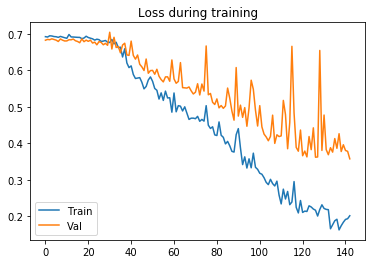

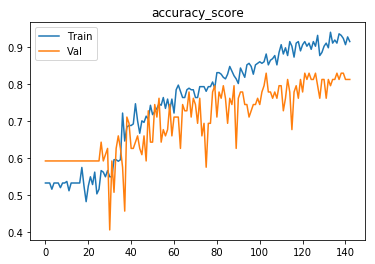

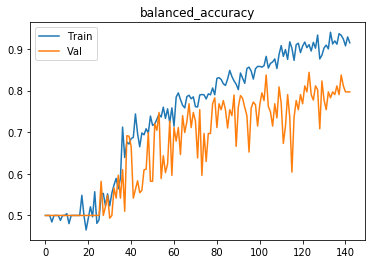

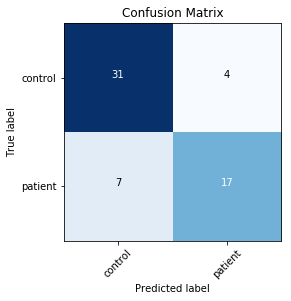

###### Starting inner fold 4
{'model': 'ModelBPIF', 'batch_size': 12, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 301895
[0,    10] loss: 0.69154
Time elapsed: 0h:0m:26s
train accuracy_score: 53.36 %
train balanced_accuracy: 50.00 %
val accuracy_score: 59.32 %
val balanced_accuracy: 50.00 %
Val loss: 0.681130
[1,    10] loss: 0.69975
Time elapsed: 0h:1m:6s
train accuracy_score: 50.84 %
train balanced_accuracy: 48.77 %
val accuracy_score: 59.32 %
val balanced_accuracy: 50.00 %
Val loss: 0.688535
[2,    10] loss: 0.69803
Time elapsed: 0h:1m:46s
train accuracy_score: 52.52 %
train balanced_accuracy: 49.21 %
val accuracy_score: 59.32 %
val balanced_accuracy: 50.00 %
Val loss: 0.683194
[3,    10] loss: 0.68713
Time elapsed: 0h:2m:27s
train accuracy_score: 53.36 %
train balanced_accuracy: 50.00 %
val accuracy_score: 59.32 %
val balanced_accuracy: 50.00 %
Val loss: 0.681658
[4,    10] loss: 0.69487
Time elapsed: 0h:3m:7s
train accuracy_score: 53.36 %
train balanced_accuracy: 50.

val accuracy_score: 57.63 %
val balanced_accuracy: 63.63 %
Val loss: 0.638519
[43,    10] loss: 0.57523
Time elapsed: 0h:29m:9s
train accuracy_score: 70.17 %
train balanced_accuracy: 69.78 %
val accuracy_score: 74.58 %
val balanced_accuracy: 73.33 %
Val loss: 0.588418
[44,    10] loss: 0.58793
Time elapsed: 0h:29m:48s
train accuracy_score: 71.01 %
train balanced_accuracy: 70.62 %
val accuracy_score: 71.19 %
val balanced_accuracy: 66.55 %
Val loss: 0.563335
[45,    10] loss: 0.57418
Time elapsed: 0h:30m:28s
train accuracy_score: 70.17 %
train balanced_accuracy: 69.32 %
val accuracy_score: 69.49 %
val balanced_accuracy: 71.67 %
Val loss: 0.575487
[46,    10] loss: 0.54390
Time elapsed: 0h:31m:9s
train accuracy_score: 69.33 %
train balanced_accuracy: 69.05 %
val accuracy_score: 45.76 %
val balanced_accuracy: 52.98 %
Val loss: 0.717944
[47,    10] loss: 0.65580
Time elapsed: 0h:31m:49s
train accuracy_score: 63.87 %
train balanced_accuracy: 63.59 %
val accuracy_score: 71.19 %
val balanced_a

val accuracy_score: 71.19 %
val balanced_accuracy: 64.58 %
Val loss: 0.589047
[86,    10] loss: 0.36403
Time elapsed: 0h:57m:58s
train accuracy_score: 84.45 %
train balanced_accuracy: 84.24 %
val accuracy_score: 71.19 %
val balanced_accuracy: 65.24 %
Val loss: 0.488788
[87,    10] loss: 0.49774
Time elapsed: 0h:58m:38s
train accuracy_score: 82.77 %
train balanced_accuracy: 82.38 %
val accuracy_score: 76.27 %
val balanced_accuracy: 74.76 %
Val loss: 0.480623
[88,    10] loss: 0.40090
Time elapsed: 0h:59m:18s
train accuracy_score: 79.41 %
train balanced_accuracy: 79.35 %
val accuracy_score: 67.80 %
val balanced_accuracy: 70.89 %
Val loss: 0.586376
[89,    10] loss: 0.34611
Time elapsed: 0h:59m:58s
train accuracy_score: 83.61 %
train balanced_accuracy: 83.34 %
val accuracy_score: 74.58 %
val balanced_accuracy: 70.71 %
Val loss: 0.442975
[90,    10] loss: 0.38342
Time elapsed: 1h:0m:38s
train accuracy_score: 83.19 %
train balanced_accuracy: 82.78 %
val accuracy_score: 76.27 %
val balanced_

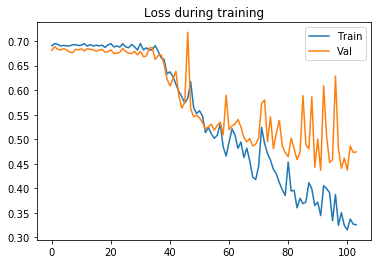

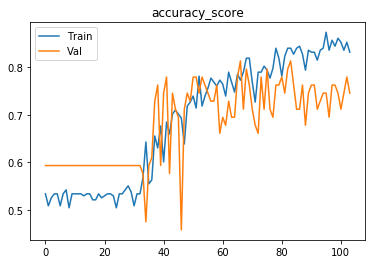

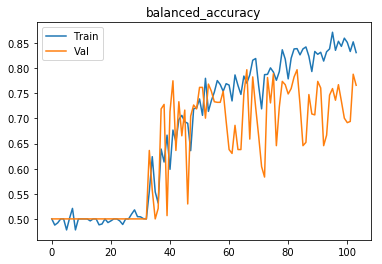

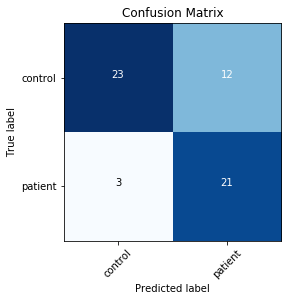

Finished outer fold.
{'final_acc': 0.8178571428571428, 'best_acc': 0.8791666666666667, 'final_iter': 150, 'best_iter': 146, 'params': {'model': 'ModelAPIF', 'batch_size': 12, 'patience': 16, 'lr': 5e-05}, 'inner_fold_idx': 1}
###### Starting outer fold 8
238
59
Shuffled the data..
###### Starting inner fold 0
{'model': 'ModelAPIF', 'batch_size': 6, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 1348665
[0,    10] loss: 0.69648
[0,    20] loss: 0.68558
[0,    30] loss: 0.72679
Time elapsed: 0h:0m:26s
train accuracy_score: 48.32 %
train balanced_accuracy: 47.64 %
val accuracy_score: 35.59 %
val balanced_accuracy: 50.00 %
Val loss: 0.717355
[1,    10] loss: 0.69106
[1,    20] loss: 0.70480
[1,    30] loss: 0.69690
Time elapsed: 0h:1m:5s
train accuracy_score: 45.80 %
train balanced_accuracy: 45.44 %
val accuracy_score: 64.41 %
val balanced_accuracy: 50.00 %
Val loss: 0.682250
[2,    10] loss: 0.68825
[2,    20] loss: 0.70106
[2,    30] loss: 0.71011
Time elapsed: 0h:1m:44s
train

[32,    20] loss: 0.62026
[32,    30] loss: 0.66133
Time elapsed: 0h:21m:25s
train accuracy_score: 63.45 %
train balanced_accuracy: 63.29 %
val accuracy_score: 71.19 %
val balanced_accuracy: 59.52 %
Val loss: 0.576923
[33,    10] loss: 0.63306
[33,    20] loss: 0.59582
[33,    30] loss: 0.54601
Time elapsed: 0h:22m:5s
train accuracy_score: 69.33 %
train balanced_accuracy: 69.22 %
val accuracy_score: 88.14 %
val balanced_accuracy: 85.46 %
Val loss: 0.541102
[34,    10] loss: 0.56405
[34,    20] loss: 0.63961
[34,    30] loss: 0.52597
Time elapsed: 0h:22m:45s
train accuracy_score: 69.75 %
train balanced_accuracy: 69.69 %
val accuracy_score: 81.36 %
val balanced_accuracy: 73.81 %
Val loss: 0.508673
[35,    10] loss: 0.57400
[35,    20] loss: 0.56768
[35,    30] loss: 0.51200
Time elapsed: 0h:23m:24s
train accuracy_score: 72.69 %
train balanced_accuracy: 72.38 %
val accuracy_score: 37.29 %
val balanced_accuracy: 51.32 %
Val loss: 0.905404
[36,    10] loss: 0.59063
[36,    20] loss: 0.55023

[66,    10] loss: 0.20527
[66,    20] loss: 0.20918
[66,    30] loss: 0.28858
Time elapsed: 0h:43m:53s
train accuracy_score: 91.60 %
train balanced_accuracy: 91.62 %
val accuracy_score: 91.53 %
val balanced_accuracy: 88.10 %
Val loss: 0.236858
[67,    10] loss: 0.15175
[67,    20] loss: 0.13339
[67,    30] loss: 0.16935
Time elapsed: 0h:44m:33s
train accuracy_score: 94.12 %
train balanced_accuracy: 94.11 %
val accuracy_score: 88.14 %
val balanced_accuracy: 89.72 %
Val loss: 0.231960
[68,    10] loss: 0.22616
[68,    20] loss: 0.07666
[68,    30] loss: 0.05313
Time elapsed: 0h:45m:13s
train accuracy_score: 96.22 %
train balanced_accuracy: 96.19 %
val accuracy_score: 89.83 %
val balanced_accuracy: 86.78 %
Val loss: 0.190406
[69,    10] loss: 0.09552
[69,    20] loss: 0.13430
[69,    30] loss: 0.23978
Time elapsed: 0h:45m:53s
train accuracy_score: 94.12 %
train balanced_accuracy: 94.11 %
val accuracy_score: 74.58 %
val balanced_accuracy: 80.26 %
Val loss: 0.712033
[70,    10] loss: 0.3098

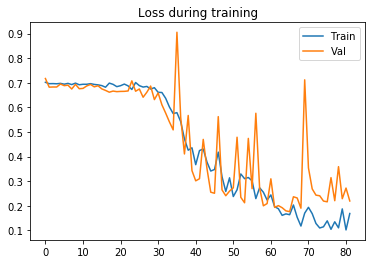

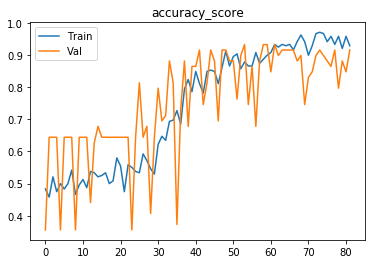

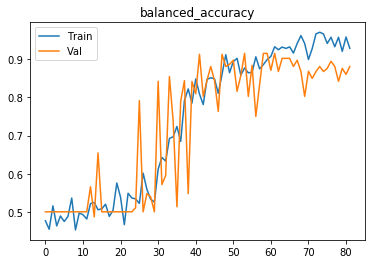

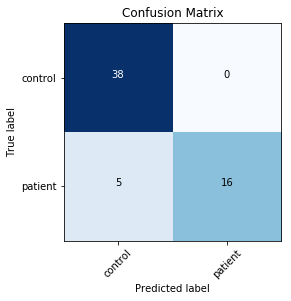

###### Starting inner fold 1
{'model': 'ModelAPIF', 'batch_size': 12, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 1348665
[0,    10] loss: 0.69468
Time elapsed: 0h:0m:27s
train accuracy_score: 51.26 %
train balanced_accuracy: 51.03 %
val accuracy_score: 64.41 %
val balanced_accuracy: 50.00 %
Val loss: 0.670871
[1,    10] loss: 0.69269
Time elapsed: 0h:1m:6s
train accuracy_score: 50.00 %
train balanced_accuracy: 48.23 %
val accuracy_score: 64.41 %
val balanced_accuracy: 50.00 %
Val loss: 0.688964
[2,    10] loss: 0.69639
Time elapsed: 0h:1m:47s
train accuracy_score: 50.42 %
train balanced_accuracy: 50.79 %
val accuracy_score: 64.41 %
val balanced_accuracy: 50.00 %
Val loss: 0.684929
[3,    10] loss: 0.69730
Time elapsed: 0h:2m:28s
train accuracy_score: 50.00 %
train balanced_accuracy: 48.02 %
val accuracy_score: 64.41 %
val balanced_accuracy: 50.00 %
Val loss: 0.676248
[4,    10] loss: 0.69744
Time elapsed: 0h:3m:9s
train accuracy_score: 49.58 %
train balanced_accuracy: 47.

Time elapsed: 0h:28m:46s
train accuracy_score: 54.62 %
train balanced_accuracy: 55.00 %
val accuracy_score: 69.49 %
val balanced_accuracy: 60.34 %
Val loss: 0.611524
[43,    10] loss: 0.64678
Time elapsed: 0h:29m:26s
train accuracy_score: 60.92 %
train balanced_accuracy: 60.52 %
val accuracy_score: 71.19 %
val balanced_accuracy: 74.44 %
Val loss: 0.642330
[44,    10] loss: 0.66431
Time elapsed: 0h:30m:7s
train accuracy_score: 63.03 %
train balanced_accuracy: 62.68 %
val accuracy_score: 71.19 %
val balanced_accuracy: 61.65 %
Val loss: 0.595776
[45,    10] loss: 0.64776
Time elapsed: 0h:30m:47s
train accuracy_score: 63.87 %
train balanced_accuracy: 63.20 %
val accuracy_score: 62.71 %
val balanced_accuracy: 71.05 %
Val loss: 0.659900
[46,    10] loss: 0.63272
Time elapsed: 0h:31m:28s
train accuracy_score: 64.29 %
train balanced_accuracy: 64.45 %
val accuracy_score: 69.49 %
val balanced_accuracy: 60.34 %
Val loss: 0.570359
[47,    10] loss: 0.63168
Time elapsed: 0h:32m:8s
train accuracy_sc

[85,    10] loss: 0.45366
Time elapsed: 0h:57m:42s
train accuracy_score: 80.25 %
train balanced_accuracy: 80.02 %
val accuracy_score: 88.14 %
val balanced_accuracy: 88.66 %
Val loss: 0.382700
[86,    10] loss: 0.40814
Time elapsed: 0h:58m:22s
train accuracy_score: 83.61 %
train balanced_accuracy: 83.46 %
val accuracy_score: 79.66 %
val balanced_accuracy: 73.56 %
Val loss: 0.347170
[87,    10] loss: 0.41739
Time elapsed: 0h:59m:3s
train accuracy_score: 80.67 %
train balanced_accuracy: 80.64 %
val accuracy_score: 83.05 %
val balanced_accuracy: 79.39 %
Val loss: 0.353423
[88,    10] loss: 0.46837
Time elapsed: 0h:59m:44s
train accuracy_score: 78.99 %
train balanced_accuracy: 79.03 %
val accuracy_score: 76.27 %
val balanced_accuracy: 81.58 %
Val loss: 0.512101
[89,    10] loss: 0.38147
Time elapsed: 1h:0m:25s
train accuracy_score: 85.29 %
train balanced_accuracy: 85.22 %
val accuracy_score: 86.44 %
val balanced_accuracy: 87.34 %
Val loss: 0.356908
[90,    10] loss: 0.37127
Time elapsed: 1h

[128,    10] loss: 0.20893
Time elapsed: 1h:26m:43s
train accuracy_score: 93.70 %
train balanced_accuracy: 93.67 %
val accuracy_score: 89.83 %
val balanced_accuracy: 91.04 %
Val loss: 0.245616
[129,    10] loss: 0.24119
Time elapsed: 1h:27m:24s
train accuracy_score: 90.76 %
train balanced_accuracy: 90.88 %
val accuracy_score: 84.75 %
val balanced_accuracy: 82.83 %
Val loss: 0.237830
[130,    10] loss: 0.21131
Time elapsed: 1h:28m:4s
train accuracy_score: 93.70 %
train balanced_accuracy: 93.70 %
val accuracy_score: 84.75 %
val balanced_accuracy: 80.70 %
Val loss: 0.241528
[131,    10] loss: 0.20641
Time elapsed: 1h:28m:43s
train accuracy_score: 91.60 %
train balanced_accuracy: 91.55 %
val accuracy_score: 89.83 %
val balanced_accuracy: 91.04 %
Val loss: 0.241056
[132,    10] loss: 0.22721
Time elapsed: 1h:29m:24s
train accuracy_score: 91.60 %
train balanced_accuracy: 91.58 %
val accuracy_score: 88.14 %
val balanced_accuracy: 83.33 %
Val loss: 0.239924
[133,    10] loss: 0.15100
Time elap

val accuracy_score: 84.75 %
val balanced_accuracy: 88.16 %
Val loss: 0.279398
[171,    10] loss: 0.21924
Time elapsed: 1h:55m:48s
train accuracy_score: 91.18 %
train balanced_accuracy: 91.18 %
val accuracy_score: 83.05 %
val balanced_accuracy: 77.26 %
Val loss: 0.267162
[172,    10] loss: 0.14933
Time elapsed: 1h:56m:27s
train accuracy_score: 92.86 %
train balanced_accuracy: 92.83 %
val accuracy_score: 91.53 %
val balanced_accuracy: 90.23 %
Val loss: 0.183081
[173,    10] loss: 0.12253
Time elapsed: 1h:57m:9s
train accuracy_score: 92.86 %
train balanced_accuracy: 92.86 %
val accuracy_score: 91.53 %
val balanced_accuracy: 92.36 %
Val loss: 0.186180
[174,    10] loss: 0.15911
Time elapsed: 1h:57m:50s
train accuracy_score: 95.38 %
train balanced_accuracy: 95.42 %
val accuracy_score: 93.22 %
val balanced_accuracy: 93.67 %
Val loss: 0.198984
[175,    10] loss: 0.10501
Time elapsed: 1h:58m:30s
train accuracy_score: 96.22 %
train balanced_accuracy: 96.19 %
val accuracy_score: 93.22 %
val bala

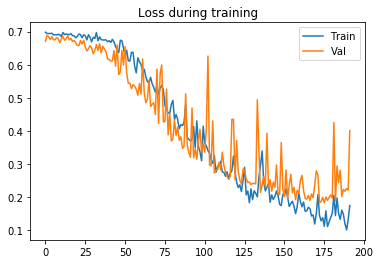

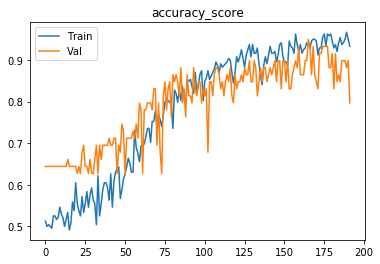

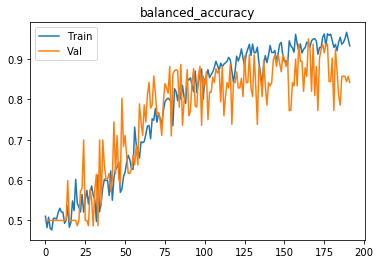

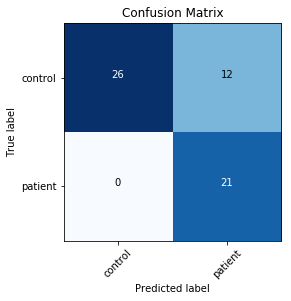

###### Starting inner fold 2
{'model': 'ModelBPIF', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 301895
[0,    10] loss: 0.69785
[0,    20] loss: 0.68854
[0,    30] loss: 0.69702
[0,    40] loss: 0.71449
[0,    50] loss: 0.69025
Time elapsed: 0h:0m:25s
train accuracy_score: 49.58 %
train balanced_accuracy: 49.63 %
val accuracy_score: 64.41 %
val balanced_accuracy: 50.00 %
Val loss: 0.678258
[1,    10] loss: 0.67807
[1,    20] loss: 0.71314
[1,    30] loss: 0.69492
[1,    40] loss: 0.69391
[1,    50] loss: 0.68373
Time elapsed: 0h:1m:4s
train accuracy_score: 52.10 %
train balanced_accuracy: 50.00 %
val accuracy_score: 64.41 %
val balanced_accuracy: 50.00 %
Val loss: 0.679915
[2,    10] loss: 0.70216
[2,    20] loss: 0.69208
[2,    30] loss: 0.69937
[2,    40] loss: 0.68744
[2,    50] loss: 0.69093
Time elapsed: 0h:1m:42s
train accuracy_score: 51.68 %
train balanced_accuracy: 49.60 %
val accuracy_score: 64.41 %
val balanced_accuracy: 50.00 %
Val loss: 0.68234

val accuracy_score: 64.41 %
val balanced_accuracy: 50.00 %
Val loss: 0.677075
[28,    10] loss: 0.67421
[28,    20] loss: 0.67872
[28,    30] loss: 0.73155
[28,    40] loss: 0.66564
[28,    50] loss: 0.71713
Time elapsed: 0h:18m:34s
train accuracy_score: 52.52 %
train balanced_accuracy: 50.44 %
val accuracy_score: 64.41 %
val balanced_accuracy: 50.00 %
Val loss: 0.676451
[29,    10] loss: 0.69431
[29,    20] loss: 0.69354
[29,    30] loss: 0.68234
[29,    40] loss: 0.68483
[29,    50] loss: 0.68543
Time elapsed: 0h:19m:13s
train accuracy_score: 55.88 %
train balanced_accuracy: 54.69 %
val accuracy_score: 64.41 %
val balanced_accuracy: 50.00 %
Val loss: 0.674820
[30,    10] loss: 0.67749
[30,    20] loss: 0.67579
[30,    30] loss: 0.68587
[30,    40] loss: 0.68654
[30,    50] loss: 0.68080
Time elapsed: 0h:19m:52s
train accuracy_score: 55.04 %
train balanced_accuracy: 53.25 %
val accuracy_score: 69.49 %
val balanced_accuracy: 61.40 %
Val loss: 0.677778
[31,    10] loss: 0.66865
[31,    

Time elapsed: 0h:36m:5s
train accuracy_score: 80.67 %
train balanced_accuracy: 80.64 %
val accuracy_score: 83.05 %
val balanced_accuracy: 84.71 %
Val loss: 0.451423
[56,    10] loss: 0.40885
[56,    20] loss: 0.34438
[56,    30] loss: 0.45110
[56,    40] loss: 0.41251
[56,    50] loss: 0.41709
Time elapsed: 0h:36m:44s
train accuracy_score: 83.61 %
train balanced_accuracy: 83.64 %
val accuracy_score: 81.36 %
val balanced_accuracy: 77.01 %
Val loss: 0.404548
[57,    10] loss: 0.36707
[57,    20] loss: 0.50945
[57,    30] loss: 0.37626
[57,    40] loss: 0.41118
[57,    50] loss: 0.35783
Time elapsed: 0h:37m:24s
train accuracy_score: 84.03 %
train balanced_accuracy: 84.01 %
val accuracy_score: 77.97 %
val balanced_accuracy: 80.76 %
Val loss: 0.491331
[58,    10] loss: 0.40590
[58,    20] loss: 0.27246
[58,    30] loss: 0.24426
[58,    40] loss: 0.34199
[58,    50] loss: 0.24490
Time elapsed: 0h:38m:3s
train accuracy_score: 84.45 %
train balanced_accuracy: 84.44 %
val accuracy_score: 83.05 

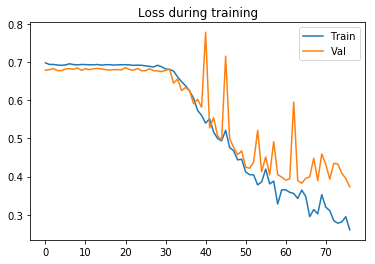

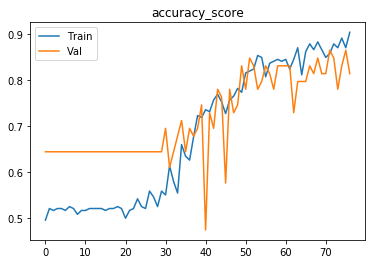

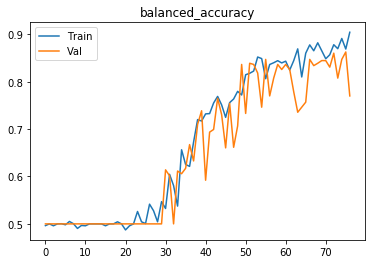

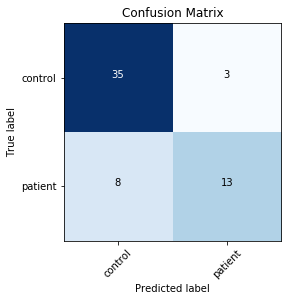

###### Starting inner fold 3
{'model': 'ModelBPIF', 'batch_size': 12, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 301895
[0,    10] loss: 0.69662
Time elapsed: 0h:0m:26s
train accuracy_score: 44.54 %
train balanced_accuracy: 44.86 %
val accuracy_score: 64.41 %
val balanced_accuracy: 50.00 %
Val loss: 0.689430
[1,    10] loss: 0.69370
Time elapsed: 0h:1m:6s
train accuracy_score: 49.16 %
train balanced_accuracy: 48.27 %
val accuracy_score: 64.41 %
val balanced_accuracy: 50.00 %
Val loss: 0.689076
[2,    10] loss: 0.68882
Time elapsed: 0h:1m:46s
train accuracy_score: 51.26 %
train balanced_accuracy: 49.26 %
val accuracy_score: 64.41 %
val balanced_accuracy: 50.00 %
Val loss: 0.679813
[3,    10] loss: 0.69095
Time elapsed: 0h:2m:26s
train accuracy_score: 52.10 %
train balanced_accuracy: 50.00 %
val accuracy_score: 64.41 %
val balanced_accuracy: 50.00 %
Val loss: 0.681126
[4,    10] loss: 0.69036
Time elapsed: 0h:3m:6s
train accuracy_score: 52.10 %
train balanced_accuracy: 50.0

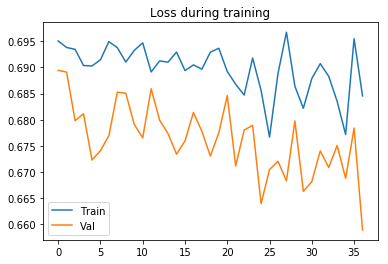

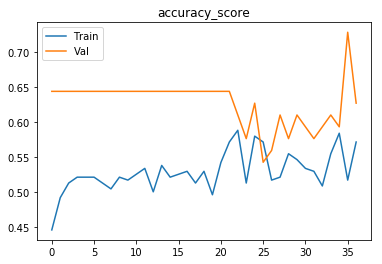

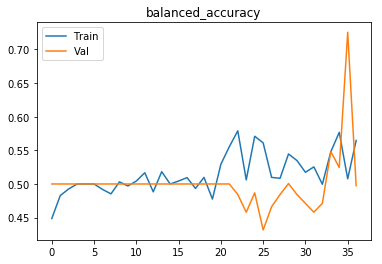

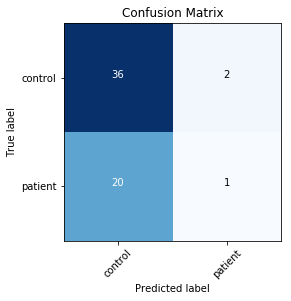

###### Starting inner fold 4
{'model': 'ModelAPIF', 'batch_size': 6, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 1348665
[0,    10] loss: 0.69535
[0,    20] loss: 0.70388
[0,    30] loss: 0.68835
Time elapsed: 0h:0m:26s
train accuracy_score: 49.58 %
train balanced_accuracy: 49.35 %
val accuracy_score: 64.41 %
val balanced_accuracy: 50.00 %
Val loss: 0.670917
[1,    10] loss: 0.69553
[1,    20] loss: 0.70023
[1,    30] loss: 0.69966
Time elapsed: 0h:1m:5s
train accuracy_score: 52.10 %
train balanced_accuracy: 50.18 %
val accuracy_score: 64.41 %
val balanced_accuracy: 50.00 %
Val loss: 0.687374
[2,    10] loss: 0.69247
[2,    20] loss: 0.68445
[2,    30] loss: 0.68494
Time elapsed: 0h:1m:45s
train accuracy_score: 50.00 %
train balanced_accuracy: 49.43 %
val accuracy_score: 64.41 %
val balanced_accuracy: 50.00 %
Val loss: 0.677199
[3,    10] loss: 0.70043
[3,    20] loss: 0.70258
[3,    30] loss: 0.68500
Time elapsed: 0h:2m:24s
train accuracy_score: 49.58 %
train balanced_acc

Time elapsed: 0h:22m:12s
train accuracy_score: 52.52 %
train balanced_accuracy: 51.11 %
val accuracy_score: 35.59 %
val balanced_accuracy: 50.00 %
Val loss: 0.713920
[34,    10] loss: 0.70330
[34,    20] loss: 0.67698
[34,    30] loss: 0.69484
Time elapsed: 0h:22m:50s
train accuracy_score: 53.36 %
train balanced_accuracy: 52.52 %
val accuracy_score: 64.41 %
val balanced_accuracy: 50.00 %
Val loss: 0.665787
[35,    10] loss: 0.68658
[35,    20] loss: 0.68723
[35,    30] loss: 0.68240
Time elapsed: 0h:23m:29s
train accuracy_score: 58.40 %
train balanced_accuracy: 57.25 %
val accuracy_score: 64.41 %
val balanced_accuracy: 50.00 %
Val loss: 0.660636
[36,    10] loss: 0.66026
[36,    20] loss: 0.66686
[36,    30] loss: 0.68916
Time elapsed: 0h:24m:9s
train accuracy_score: 52.94 %
train balanced_accuracy: 50.91 %
val accuracy_score: 72.88 %
val balanced_accuracy: 68.30 %
Val loss: 0.676316
[37,    10] loss: 0.69545
[37,    20] loss: 0.68084
[37,    30] loss: 0.68603
Time elapsed: 0h:24m:49s


[67,    10] loss: 0.23902
[67,    20] loss: 0.26251
[67,    30] loss: 0.26484
Time elapsed: 0h:44m:9s
train accuracy_score: 88.66 %
train balanced_accuracy: 88.65 %
val accuracy_score: 83.05 %
val balanced_accuracy: 76.19 %
Val loss: 0.373911
[68,    10] loss: 0.24569
[68,    20] loss: 0.24194
[68,    30] loss: 0.25481
Time elapsed: 0h:44m:47s
train accuracy_score: 88.66 %
train balanced_accuracy: 88.62 %
val accuracy_score: 89.83 %
val balanced_accuracy: 87.84 %
Val loss: 0.280403
[69,    10] loss: 0.20656
[69,    20] loss: 0.13335
[69,    30] loss: 0.17606
Time elapsed: 0h:45m:25s
train accuracy_score: 93.28 %
train balanced_accuracy: 93.27 %
val accuracy_score: 89.83 %
val balanced_accuracy: 87.84 %
Val loss: 0.283897
[70,    10] loss: 0.13988
[70,    20] loss: 0.13075
[70,    30] loss: 0.18414
Time elapsed: 0h:46m:3s
train accuracy_score: 93.70 %
train balanced_accuracy: 93.67 %
val accuracy_score: 89.83 %
val balanced_accuracy: 87.84 %
Val loss: 0.281031
[71,    10] loss: 0.16947


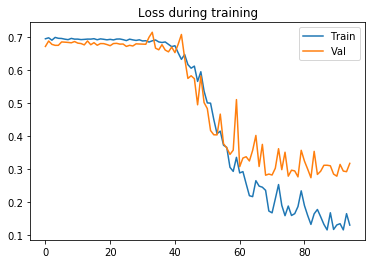

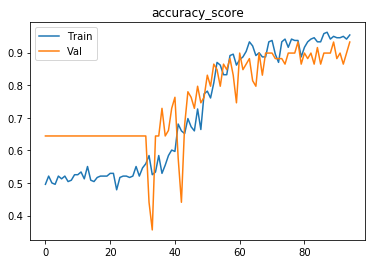

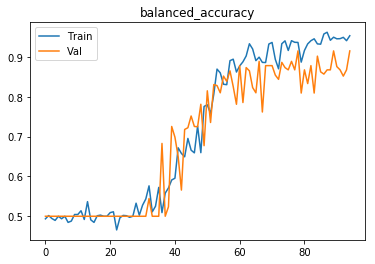

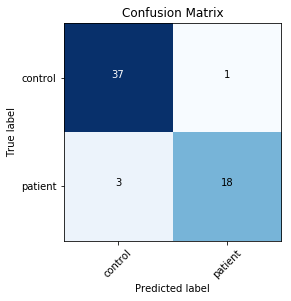

Finished outer fold.
{'final_acc': 0.8809523809523809, 'best_acc': 0.9154135338345865, 'final_iter': 82, 'best_iter': 62, 'params': {'model': 'ModelAPIF', 'batch_size': 6, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 0}
###### Starting outer fold 9
238
59
Shuffled the data..
###### Starting inner fold 0
{'model': 'ModelAPIF', 'batch_size': 12, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 1348665
[0,    10] loss: 0.69809
Time elapsed: 0h:0m:26s
train accuracy_score: 48.32 %
train balanced_accuracy: 49.70 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.687108
[1,    10] loss: 0.69494
Time elapsed: 0h:1m:5s
train accuracy_score: 52.52 %
train balanced_accuracy: 49.65 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.688259
[2,    10] loss: 0.68259
Time elapsed: 0h:1m:43s
train accuracy_score: 52.94 %
train balanced_accuracy: 50.50 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.684809
[3,    10] loss:

[41,    10] loss: 0.65724
Time elapsed: 0h:26m:47s
train accuracy_score: 64.71 %
train balanced_accuracy: 63.54 %
val accuracy_score: 59.32 %
val balanced_accuracy: 60.37 %
Val loss: 0.675161
[42,    10] loss: 0.65674
Time elapsed: 0h:27m:25s
train accuracy_score: 60.08 %
train balanced_accuracy: 59.47 %
val accuracy_score: 59.32 %
val balanced_accuracy: 61.19 %
Val loss: 0.673665
[43,    10] loss: 0.64795
Time elapsed: 0h:28m:2s
train accuracy_score: 64.71 %
train balanced_accuracy: 63.94 %
val accuracy_score: 64.41 %
val balanced_accuracy: 64.92 %
Val loss: 0.664963
[44,    10] loss: 0.63647
Time elapsed: 0h:28m:41s
train accuracy_score: 63.87 %
train balanced_accuracy: 63.69 %
val accuracy_score: 55.93 %
val balanced_accuracy: 53.67 %
Val loss: 0.673847
[45,    10] loss: 0.64091
Time elapsed: 0h:29m:19s
train accuracy_score: 63.03 %
train balanced_accuracy: 62.50 %
val accuracy_score: 62.71 %
val balanced_accuracy: 59.73 %
Val loss: 0.651264
[46,    10] loss: 0.62737
Time elapsed: 0

[84,    10] loss: 0.49734
Time elapsed: 0h:54m:19s
train accuracy_score: 80.25 %
train balanced_accuracy: 80.51 %
val accuracy_score: 71.19 %
val balanced_accuracy: 70.16 %
Val loss: 0.533710
[85,    10] loss: 0.45129
Time elapsed: 0h:54m:59s
train accuracy_score: 81.93 %
train balanced_accuracy: 81.75 %
val accuracy_score: 72.88 %
val balanced_accuracy: 71.27 %
Val loss: 0.539032
[86,    10] loss: 0.44551
Time elapsed: 0h:55m:38s
train accuracy_score: 84.45 %
train balanced_accuracy: 84.52 %
val accuracy_score: 72.88 %
val balanced_accuracy: 74.53 %
Val loss: 0.568000
[87,    10] loss: 0.42651
Time elapsed: 0h:56m:17s
train accuracy_score: 82.35 %
train balanced_accuracy: 82.24 %
val accuracy_score: 67.80 %
val balanced_accuracy: 66.32 %
Val loss: 0.501257
[88,    10] loss: 0.40270
Time elapsed: 0h:56m:57s
train accuracy_score: 81.93 %
train balanced_accuracy: 81.70 %
val accuracy_score: 71.19 %
val balanced_accuracy: 70.16 %
Val loss: 0.491185
[89,    10] loss: 0.37230
Time elapsed: 

[127,    10] loss: 0.30486
Time elapsed: 1h:22m:4s
train accuracy_score: 88.24 %
train balanced_accuracy: 88.34 %
val accuracy_score: 77.97 %
val balanced_accuracy: 75.41 %
Val loss: 0.401011
[128,    10] loss: 0.24012
Time elapsed: 1h:22m:43s
train accuracy_score: 89.08 %
train balanced_accuracy: 88.99 %
val accuracy_score: 77.97 %
val balanced_accuracy: 75.82 %
Val loss: 0.362881
[129,    10] loss: 0.24648
Time elapsed: 1h:23m:21s
train accuracy_score: 89.50 %
train balanced_accuracy: 89.38 %
val accuracy_score: 79.66 %
val balanced_accuracy: 76.92 %
Val loss: 0.435522
[130,    10] loss: 0.31110
Time elapsed: 1h:23m:59s
train accuracy_score: 87.39 %
train balanced_accuracy: 87.30 %
val accuracy_score: 81.36 %
val balanced_accuracy: 82.93 %
Val loss: 0.346536
[131,    10] loss: 0.30954
Time elapsed: 1h:24m:36s
train accuracy_score: 87.82 %
train balanced_accuracy: 87.85 %
val accuracy_score: 81.36 %
val balanced_accuracy: 80.48 %
Val loss: 0.331982
[132,    10] loss: 0.33402
Time elap

val accuracy_score: 88.14 %
val balanced_accuracy: 87.76 %
Val loss: 0.278173
[170,    10] loss: 0.18341
Time elapsed: 1h:49m:40s
train accuracy_score: 90.76 %
train balanced_accuracy: 90.82 %
val accuracy_score: 84.75 %
val balanced_accuracy: 83.51 %
Val loss: 0.301788
[171,    10] loss: 0.17623
Time elapsed: 1h:50m:19s
train accuracy_score: 89.92 %
train balanced_accuracy: 89.83 %
val accuracy_score: 89.83 %
val balanced_accuracy: 90.09 %
Val loss: 0.282583
[172,    10] loss: 0.20297
Time elapsed: 1h:50m:58s
train accuracy_score: 92.44 %
train balanced_accuracy: 92.46 %
val accuracy_score: 81.36 %
val balanced_accuracy: 80.07 %
Val loss: 0.328478
[173,    10] loss: 0.18363
Time elapsed: 1h:51m:38s
train accuracy_score: 92.02 %
train balanced_accuracy: 92.01 %
val accuracy_score: 77.97 %
val balanced_accuracy: 75.41 %
Val loss: 0.506613
[174,    10] loss: 0.20085
Time elapsed: 1h:52m:16s
train accuracy_score: 90.34 %
train balanced_accuracy: 90.33 %
val accuracy_score: 84.75 %
val bal

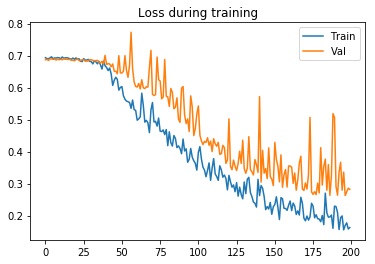

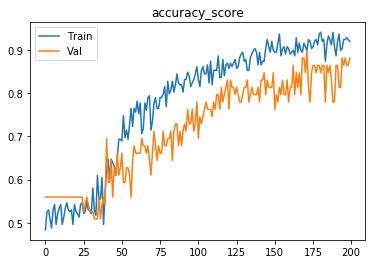

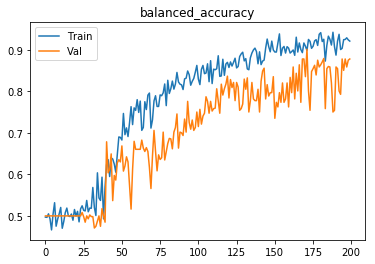

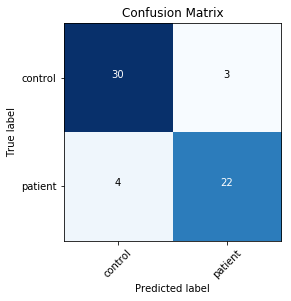

###### Starting inner fold 1
{'model': 'ModelAPIF', 'batch_size': 6, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 1348665
[0,    10] loss: 0.70179
[0,    20] loss: 0.69618
[0,    30] loss: 0.69110
Time elapsed: 0h:0m:25s
train accuracy_score: 50.42 %
train balanced_accuracy: 49.21 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.686163
[1,    10] loss: 0.69020
[1,    20] loss: 0.69763
[1,    30] loss: 0.69619
Time elapsed: 0h:1m:3s
train accuracy_score: 52.94 %
train balanced_accuracy: 50.25 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.688074
[2,    10] loss: 0.68726
[2,    20] loss: 0.68492
[2,    30] loss: 0.69102
Time elapsed: 0h:1m:41s
train accuracy_score: 55.46 %
train balanced_accuracy: 53.17 %
val accuracy_score: 55.93 %
val balanced_accuracy: 60.20 %
Val loss: 0.693089
[3,    10] loss: 0.69898
[3,    20] loss: 0.68122
[3,    30] loss: 0.69665
Time elapsed: 0h:2m:18s
train accuracy_score: 52.94 %
train balanced_ac

Time elapsed: 0h:21m:9s
train accuracy_score: 76.47 %
train balanced_accuracy: 76.19 %
val accuracy_score: 74.58 %
val balanced_accuracy: 74.42 %
Val loss: 0.539599
[34,    10] loss: 0.49024
[34,    20] loss: 0.49664
[34,    30] loss: 0.51127
Time elapsed: 0h:21m:48s
train accuracy_score: 75.63 %
train balanced_accuracy: 75.35 %
val accuracy_score: 74.58 %
val balanced_accuracy: 73.19 %
Val loss: 0.498679
[35,    10] loss: 0.45777
[35,    20] loss: 0.43689
[35,    30] loss: 0.47374
Time elapsed: 0h:22m:26s
train accuracy_score: 81.09 %
train balanced_accuracy: 80.90 %
val accuracy_score: 77.97 %
val balanced_accuracy: 75.82 %
Val loss: 0.472616
[36,    10] loss: 0.42260
[36,    20] loss: 0.39220
[36,    30] loss: 0.64269
Time elapsed: 0h:23m:3s
train accuracy_score: 75.63 %
train balanced_accuracy: 75.60 %
val accuracy_score: 81.36 %
val balanced_accuracy: 80.89 %
Val loss: 0.467081
[37,    10] loss: 0.32505
[37,    20] loss: 0.36437
[37,    30] loss: 0.40365
Time elapsed: 0h:23m:41s
t

[67,    10] loss: 0.17833
[67,    20] loss: 0.06296
[67,    30] loss: 0.04688
Time elapsed: 0h:42m:30s
train accuracy_score: 96.22 %
train balanced_accuracy: 96.28 %
val accuracy_score: 88.14 %
val balanced_accuracy: 88.99 %
Val loss: 0.337066
[68,    10] loss: 0.16612
[68,    20] loss: 0.12172
[68,    30] loss: 0.09193
Time elapsed: 0h:43m:8s
train accuracy_score: 94.96 %
train balanced_accuracy: 94.99 %
val accuracy_score: 84.75 %
val balanced_accuracy: 85.96 %
Val loss: 0.438507
[69,    10] loss: 0.13383
[69,    20] loss: 0.14516
[69,    30] loss: 0.07543
Time elapsed: 0h:43m:45s
train accuracy_score: 96.22 %
train balanced_accuracy: 96.28 %
val accuracy_score: 86.44 %
val balanced_accuracy: 86.66 %
Val loss: 0.331959
[70,    10] loss: 0.08266
[70,    20] loss: 0.07396
[70,    30] loss: 0.22016
Time elapsed: 0h:44m:23s
train accuracy_score: 94.54 %
train balanced_accuracy: 94.59 %
val accuracy_score: 86.44 %
val balanced_accuracy: 86.25 %
Val loss: 0.335918
[71,    10] loss: 0.12912

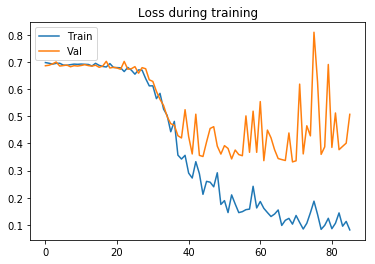

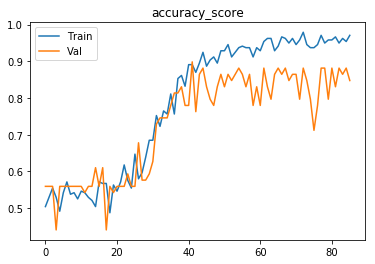

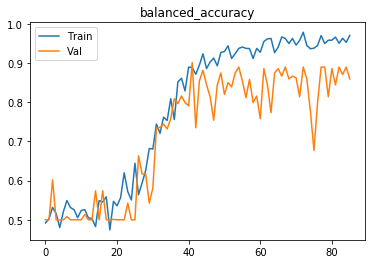

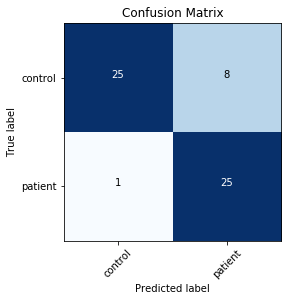

###### Starting inner fold 2
{'model': 'ModelBPIF', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 301895
[0,    10] loss: 0.69226
Time elapsed: 0h:0m:26s
train accuracy_score: 52.94 %
train balanced_accuracy: 50.00 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.688682
[1,    10] loss: 0.68533
Time elapsed: 0h:1m:6s
train accuracy_score: 52.94 %
train balanced_accuracy: 50.00 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.686466
[2,    10] loss: 0.69270
Time elapsed: 0h:1m:45s
train accuracy_score: 50.42 %
train balanced_accuracy: 48.12 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.691991
[3,    10] loss: 0.69462
Time elapsed: 0h:2m:23s
train accuracy_score: 52.10 %
train balanced_accuracy: 49.55 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.688159
[4,    10] loss: 0.69384
Time elapsed: 0h:3m:1s
train accuracy_score: 52.94 %
train balanced_accuracy: 50.

Time elapsed: 0h:27m:29s
train accuracy_score: 75.63 %
train balanced_accuracy: 75.15 %
val accuracy_score: 64.41 %
val balanced_accuracy: 63.29 %
Val loss: 0.647238
[43,    10] loss: 0.58804
Time elapsed: 0h:28m:7s
train accuracy_score: 71.85 %
train balanced_accuracy: 71.78 %
val accuracy_score: 64.41 %
val balanced_accuracy: 62.06 %
Val loss: 0.647405
[44,    10] loss: 0.55610
Time elapsed: 0h:28m:47s
train accuracy_score: 73.11 %
train balanced_accuracy: 72.52 %
val accuracy_score: 62.71 %
val balanced_accuracy: 64.63 %
Val loss: 0.662684
[45,    10] loss: 0.53397
Time elapsed: 0h:29m:25s
train accuracy_score: 74.37 %
train balanced_accuracy: 74.26 %
val accuracy_score: 67.80 %
val balanced_accuracy: 68.36 %
Val loss: 0.647012
[46,    10] loss: 0.54002
Time elapsed: 0h:30m:4s
train accuracy_score: 70.17 %
train balanced_accuracy: 70.29 %
val accuracy_score: 66.10 %
val balanced_accuracy: 63.99 %
Val loss: 0.617220
[47,    10] loss: 0.57521
Time elapsed: 0h:30m:43s
train accuracy_sc

[85,    10] loss: 0.30558
Time elapsed: 0h:55m:12s
train accuracy_score: 88.66 %
train balanced_accuracy: 88.69 %
val accuracy_score: 69.49 %
val balanced_accuracy: 69.46 %
Val loss: 0.445641
[86,    10] loss: 0.28784
Time elapsed: 0h:55m:50s
train accuracy_score: 86.55 %
train balanced_accuracy: 86.41 %
val accuracy_score: 72.88 %
val balanced_accuracy: 74.13 %
Val loss: 0.494735
[87,    10] loss: 0.29325
Time elapsed: 0h:56m:28s
train accuracy_score: 87.82 %
train balanced_accuracy: 87.90 %
val accuracy_score: 72.88 %
val balanced_accuracy: 72.90 %
Val loss: 0.441152
[88,    10] loss: 0.27628
Time elapsed: 0h:57m:6s
train accuracy_score: 89.92 %
train balanced_accuracy: 89.88 %
val accuracy_score: 71.19 %
val balanced_accuracy: 72.61 %
Val loss: 0.496863
[89,    10] loss: 0.32293
Time elapsed: 0h:57m:46s
train accuracy_score: 86.97 %
train balanced_accuracy: 86.95 %
val accuracy_score: 72.88 %
val balanced_accuracy: 73.72 %
Val loss: 0.440260
[90,    10] loss: 0.28433
Time elapsed: 0

[128,    10] loss: 0.22100
Time elapsed: 1h:22m:43s
train accuracy_score: 93.28 %
train balanced_accuracy: 93.35 %
val accuracy_score: 74.58 %
val balanced_accuracy: 74.01 %
Val loss: 0.350509
[129,    10] loss: 0.20662
Time elapsed: 1h:23m:22s
train accuracy_score: 92.02 %
train balanced_accuracy: 91.91 %
val accuracy_score: 79.66 %
val balanced_accuracy: 78.55 %
Val loss: 0.369884
[130,    10] loss: 0.19679
Time elapsed: 1h:24m:1s
train accuracy_score: 90.76 %
train balanced_accuracy: 90.72 %
val accuracy_score: 77.97 %
val balanced_accuracy: 78.26 %
Val loss: 0.335341
[131,    10] loss: 0.21417
Time elapsed: 1h:24m:40s
train accuracy_score: 89.08 %
train balanced_accuracy: 89.04 %
val accuracy_score: 77.97 %
val balanced_accuracy: 79.08 %
Val loss: 0.393107
[132,    10] loss: 0.20079
Time elapsed: 1h:25m:19s
train accuracy_score: 89.50 %
train balanced_accuracy: 89.53 %
val accuracy_score: 83.05 %
val balanced_accuracy: 82.81 %
Val loss: 0.338912
[133,    10] loss: 0.17249
Time elap

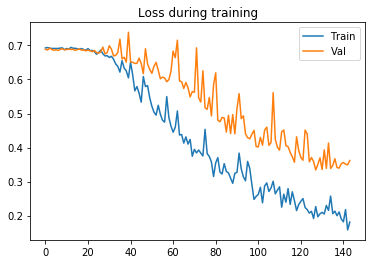

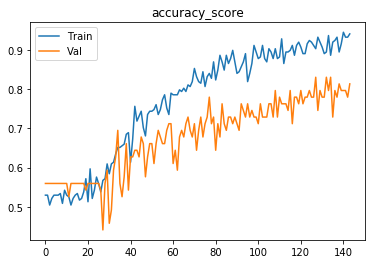

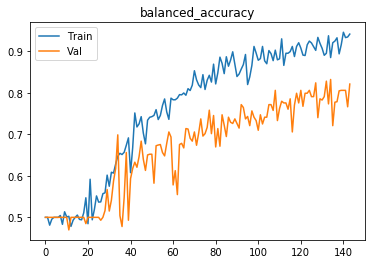

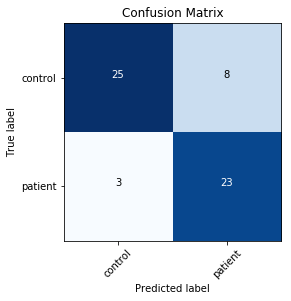

###### Starting inner fold 3
{'model': 'ModelBPIF', 'batch_size': 6, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 301895
[0,    10] loss: 0.69338
[0,    20] loss: 0.69164
[0,    30] loss: 0.69963
Time elapsed: 0h:0m:24s
train accuracy_score: 48.74 %
train balanced_accuracy: 50.15 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.688760
[1,    10] loss: 0.69260
[1,    20] loss: 0.68722
[1,    30] loss: 0.70818
Time elapsed: 0h:1m:2s
train accuracy_score: 53.36 %
train balanced_accuracy: 50.45 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.688242
[2,    10] loss: 0.69631
[2,    20] loss: 0.68812
[2,    30] loss: 0.68973
Time elapsed: 0h:1m:38s
train accuracy_score: 51.68 %
train balanced_accuracy: 49.21 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.685202
[3,    10] loss: 0.68662
[3,    20] loss: 0.68914
[3,    30] loss: 0.70320
Time elapsed: 0h:2m:16s
train accuracy_score: 52.52 %
train balanced_acc

Time elapsed: 0h:21m:6s
train accuracy_score: 72.69 %
train balanced_accuracy: 72.47 %
val accuracy_score: 62.71 %
val balanced_accuracy: 60.14 %
Val loss: 0.631938
[34,    10] loss: 0.45511
[34,    20] loss: 0.65113
[34,    30] loss: 0.50254
Time elapsed: 0h:21m:43s
train accuracy_score: 73.53 %
train balanced_accuracy: 73.76 %
val accuracy_score: 61.02 %
val balanced_accuracy: 58.22 %
Val loss: 0.659063
[35,    10] loss: 0.46343
[35,    20] loss: 0.59830
[35,    30] loss: 0.64862
Time elapsed: 0h:22m:21s
train accuracy_score: 77.31 %
train balanced_accuracy: 77.23 %
val accuracy_score: 64.41 %
val balanced_accuracy: 63.69 %
Val loss: 0.656154
[36,    10] loss: 0.55944
[36,    20] loss: 0.50970
[36,    30] loss: 0.54911
Time elapsed: 0h:22m:59s
train accuracy_score: 73.11 %
train balanced_accuracy: 73.21 %
val accuracy_score: 61.02 %
val balanced_accuracy: 58.62 %
Val loss: 0.666502
[37,    10] loss: 0.59765
[37,    20] loss: 0.48015
[37,    30] loss: 0.47642
Time elapsed: 0h:23m:37s


[67,    10] loss: 0.38124
[67,    20] loss: 0.32789
[67,    30] loss: 0.37727
Time elapsed: 0h:42m:30s
train accuracy_score: 84.87 %
train balanced_accuracy: 84.87 %
val accuracy_score: 71.19 %
val balanced_accuracy: 70.16 %
Val loss: 0.546398
[68,    10] loss: 0.55543
[68,    20] loss: 0.44159
[68,    30] loss: 0.43288
Time elapsed: 0h:43m:7s
train accuracy_score: 77.73 %
train balanced_accuracy: 77.48 %
val accuracy_score: 72.88 %
val balanced_accuracy: 72.90 %
Val loss: 0.544271
[69,    10] loss: 0.38434
[69,    20] loss: 0.44700
[69,    30] loss: 0.32358
Time elapsed: 0h:43m:44s
train accuracy_score: 81.09 %
train balanced_accuracy: 81.00 %
val accuracy_score: 74.58 %
val balanced_accuracy: 72.79 %
Val loss: 0.583503
[70,    10] loss: 0.35188
[70,    20] loss: 0.36264
[70,    30] loss: 0.34449
Time elapsed: 0h:44m:22s
train accuracy_score: 84.87 %
train balanced_accuracy: 84.87 %
val accuracy_score: 71.19 %
val balanced_accuracy: 71.39 %
Val loss: 0.529188
[71,    10] loss: 0.29371

val accuracy_score: 74.58 %
val balanced_accuracy: 73.19 %
Val loss: 0.464531
[101,    10] loss: 0.14090
[101,    20] loss: 0.21694
[101,    30] loss: 0.16110
Time elapsed: 1h:3m:42s
train accuracy_score: 92.02 %
train balanced_accuracy: 92.16 %
val accuracy_score: 74.58 %
val balanced_accuracy: 74.01 %
Val loss: 0.435500
[102,    10] loss: 0.19035
[102,    20] loss: 0.26796
[102,    30] loss: 0.31842
Time elapsed: 1h:4m:19s
train accuracy_score: 91.60 %
train balanced_accuracy: 91.67 %
val accuracy_score: 77.97 %
val balanced_accuracy: 78.26 %
Val loss: 0.433530
[103,    10] loss: 0.28158
[103,    20] loss: 0.21303
[103,    30] loss: 0.16664
Time elapsed: 1h:4m:56s
train accuracy_score: 90.34 %
train balanced_accuracy: 90.43 %
val accuracy_score: 76.27 %
val balanced_accuracy: 73.48 %
Val loss: 0.535536
[104,    10] loss: 0.23689
[104,    20] loss: 0.38323
[104,    30] loss: 0.19411
Time elapsed: 1h:5m:34s
train accuracy_score: 89.50 %
train balanced_accuracy: 89.34 %
val accuracy_sco

[134,    10] loss: 0.16258
[134,    20] loss: 0.23330
[134,    30] loss: 0.17045
Time elapsed: 1h:24m:25s
train accuracy_score: 92.02 %
train balanced_accuracy: 92.06 %
val accuracy_score: 83.05 %
val balanced_accuracy: 83.62 %
Val loss: 0.392289
[135,    10] loss: 0.11178
[135,    20] loss: 0.13776
[135,    30] loss: 0.08219
Time elapsed: 1h:25m:3s
train accuracy_score: 97.06 %
train balanced_accuracy: 97.07 %
val accuracy_score: 79.66 %
val balanced_accuracy: 79.37 %
Val loss: 0.390936
[136,    10] loss: 0.10140
[136,    20] loss: 0.16248
[136,    30] loss: 0.22323
Time elapsed: 1h:25m:41s
train accuracy_score: 94.12 %
train balanced_accuracy: 94.10 %
val accuracy_score: 77.97 %
val balanced_accuracy: 76.22 %
Val loss: 0.430801
[137,    10] loss: 0.10613
[137,    20] loss: 0.18004
[137,    30] loss: 0.12039
Time elapsed: 1h:26m:19s
train accuracy_score: 92.02 %
train balanced_accuracy: 92.06 %
val accuracy_score: 77.97 %
val balanced_accuracy: 76.63 %
Val loss: 0.380909
[138,    10] 

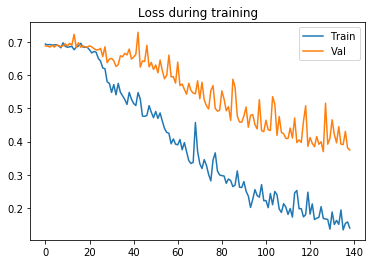

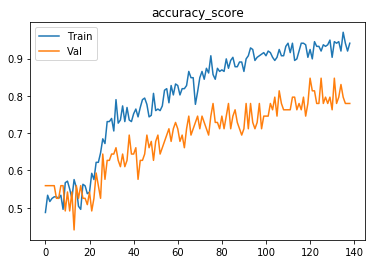

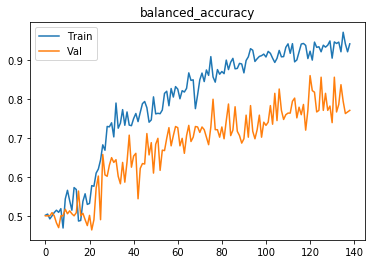

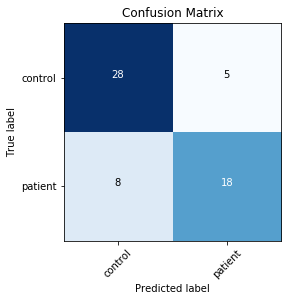

###### Starting inner fold 4
{'model': 'ModelBPIF', 'batch_size': 12, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 301895
[0,    10] loss: 0.69941
Time elapsed: 0h:0m:26s
train accuracy_score: 47.90 %
train balanced_accuracy: 50.64 %
val accuracy_score: 44.07 %
val balanced_accuracy: 50.00 %
Val loss: 0.694214
[1,    10] loss: 0.69490
Time elapsed: 0h:1m:3s
train accuracy_score: 47.48 %
train balanced_accuracy: 46.88 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.82 %
Val loss: 0.692007
[2,    10] loss: 0.68809
Time elapsed: 0h:1m:41s
train accuracy_score: 51.68 %
train balanced_accuracy: 48.91 %
val accuracy_score: 55.93 %
val balanced_accuracy: 50.00 %
Val loss: 0.687694
[3,    10] loss: 0.69389
Time elapsed: 0h:2m:19s
train accuracy_score: 53.78 %
train balanced_accuracy: 51.09 %
val accuracy_score: 54.24 %
val balanced_accuracy: 48.48 %
Val loss: 0.690777
[4,    10] loss: 0.69038
Time elapsed: 0h:2m:57s
train accuracy_score: 55.88 %
train balanced_accuracy: 53.

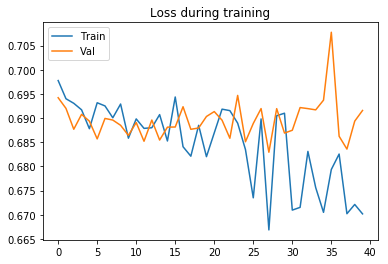

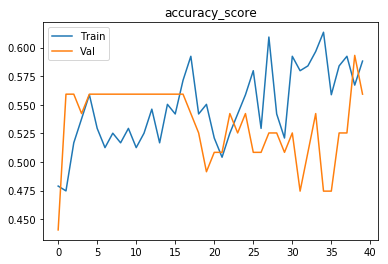

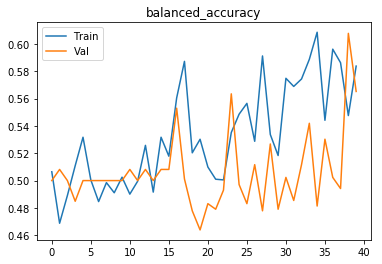

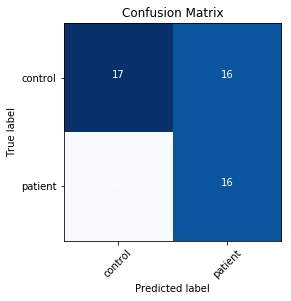

Finished outer fold.
{'final_acc': 0.8776223776223776, 'best_acc': 0.9009324009324009, 'final_iter': 200, 'best_iter': 172, 'params': {'model': 'ModelAPIF', 'batch_size': 12, 'patience': 12, 'lr': 5e-05}, 'inner_fold_idx': 0}
################################
################################
All accuracies: [0.837962962962963, 0.8721064814814814, 0.5, 0.7199074074074074, 0.832175925925926, 0.9264705882352942, 0.8970588235294117, 0.9117647058823528, 0.9505882352941176, 0.9558823529411764, 0.8735431235431236, 0.8776223776223776, 0.7884615384615384, 0.8886946386946387, 0.8898601398601399, 0.9032258064516129, 0.9193548387096775, 0.898041474654378, 0.5, 0.8819124423963134, 0.7737268518518519, 0.46122685185185186, 0.8605324074074074, 0.8333333333333333, 0.8547453703703703, 0.9158986175115207, 0.8410138248847927, 0.9498847926267282, 0.8963133640552995, 0.88536866359447, 0.8982758620689655, 0.799425287356322, 0.8287356321839081, 0.5, 0.799425287356322, 0.8220238095238094, 0.8178571428571428, 0.

In [19]:
fold_metric, models = run(net=None, data=df,
                  k_folds=-1,
                  callbacks=None,
                  shape=-1,
                  masked=False,
                  metrics=metrics,
                  num_epochs=num_epochs,
                  retain_metric=retain_metric,
                  augmentations=augmentations,
                  b=None
                 )

print(np.mean(fold_metric))
print(np.std(fold_metric))

In [20]:
5/0

ZeroDivisionError: division by zero

In [7]:
training_res = [{'final_acc': 0.837962962962963, 'best_acc': 0.8506944444444444, 'final_iter': 110, 'best_iter': 107, 'params': {'model': 'ModelAPIF', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 0}, {'final_acc': 0.9505882352941176, 'best_acc': 0.9505882352941176, 'final_iter': 112, 'best_iter': 112, 'params': {'model': 'ModelBPIF', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 3}, {'final_acc': 0.8898601398601399, 'best_acc': 0.9656177156177157, 'final_iter': 89, 'best_iter': 77, 'params': {'model': 'ModelBPIF', 'batch_size': 4, 'patience': 12, 'lr': 0.0001}, 'inner_fold_idx': 4}, {'final_acc': 0.9032258064516129, 'best_acc': 0.9660138248847927, 'final_iter': 52, 'best_iter': 37, 'params': {'model': 'ModelAPIF', 'batch_size': 4, 'patience': 12, 'lr': 0.0001}, 'inner_fold_idx': 0}, {'final_acc': 0.8605324074074074, 'best_acc': 0.879050925925926, 'final_iter': 122, 'best_iter': 106, 'params': {'model': 'ModelBPIF', 'batch_size': 4, 'patience': 16, 'lr': 5e-05}, 'inner_fold_idx': 2}, {'final_acc': 0.9158986175115207, 'best_acc': 0.9337557603686636, 'final_iter': 164, 'best_iter': 148, 'params': {'model': 'ModelAPIF', 'batch_size': 12, 'patience': 16, 'lr': 5e-05}, 'inner_fold_idx': 0}, {'final_acc': 0.8982758620689655, 'best_acc': 0.8982758620689655, 'final_iter': 65, 'best_iter': 65, 'params': {'model': 'ModelAPIF', 'batch_size': 4, 'patience': 16, 'lr': 5e-05}, 'inner_fold_idx': 0}, {'final_acc': 0.8178571428571428, 'best_acc': 0.8791666666666667, 'final_iter': 150, 'best_iter': 146, 'params': {'model': 'ModelAPIF', 'batch_size': 12, 'patience': 16, 'lr': 5e-05}, 'inner_fold_idx': 1}, {'final_acc': 0.8809523809523809, 'best_acc': 0.9154135338345865, 'final_iter': 82, 'best_iter': 62, 'params': {'model': 'ModelAPIF', 'batch_size': 6, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 0}, {'final_acc': 0.8776223776223776, 'best_acc': 0.9009324009324009, 'final_iter': 200, 'best_iter': 172, 'params': {'model': 'ModelAPIF', 'batch_size': 12, 'patience': 12, 'lr': 5e-05}, 'inner_fold_idx': 0}]

In [8]:
len(training_res)

10

In [9]:
res_df = pd.DataFrame(training_res)

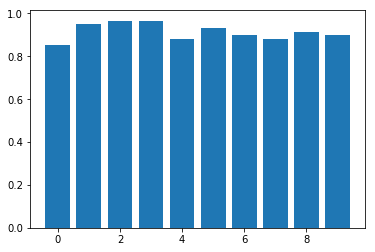

0.9139509370038279
0.8832775932988628


In [10]:
plt.bar(np.arange(len(res_df["best_acc"])), res_df["best_acc"])
plt.show()
print(np.mean(res_df["best_acc"]))
print(np.mean(res_df["final_acc"]))

In [11]:
print(np.mean(res_df["final_iter"]))

114.6


In [12]:
print(res_df["final_iter"])

0    110
1    112
2     89
3     52
4    122
5    164
6     65
7    150
8     82
9    200
Name: final_iter, dtype: int64


# Start inference

In [26]:
from collections import OrderedDict

In [27]:
metrics = []

random_states = np.arange(20, 30) # important to use the same values as during training

for outer_fold, r in enumerate(random_states):
    print("Outer fold {}".format(outer_fold))

    all_scores = []
    all_preds = []
    all_labels = []
    
    train_res = training_res[outer_fold]
    model_dir = os.path.join(output_dir,"outer_{}_inner_{}_cv_fold_{}_BEST_ITERATION.h5".format(outer_fold, train_res["inner_fold_idx"], outer_fold * 5 + train_res["inner_fold_idx"]))
    model_name = train_res["params"]["model"]
    net = pick_model(model_name)
    state_dict = torch.load(model_dir, map_location='cpu')
    new_state_dict = OrderedDict()
    for param in state_dict.items():
        new_state_dict.update([(param[0].replace("module.", ""), param[1])])
    
    net.load_state_dict(new_state_dict)
    net = net.cuda(gpu)
    net.eval()
    
    # load data
    # separate new test set each run
    no_test_df = df.sample(frac=0.8, random_state=r) # split according 
    test_df = df[~df["PTID"].isin(no_test_df["PTID"])]

    if zero_one_normalize:
        intensity = IntensityRescale()
        ukb_data_test = UKBGDataset(test_df, transform=transforms.Compose([intensity, ToTensor()]), mask=mask)
    else:
        ukb_data_test = UKBGDataset(test_df, transform=transforms.Compose([ToTensor()]), mask=mask)
        
    test_loader = DataLoader(
            ukb_data_test, batch_size=1, num_workers=1, shuffle=False
    )
    with torch.no_grad():
        for sample in test_loader:
            img = sample["image"]
            label = sample["label"]
            img = img.to(torch.device("cuda:" + str(gpu)))
            
            output = net.forward(img)
            score = torch.sigmoid(output)
            pred = score >= 0.5
            
            all_scores.append(score.cpu().numpy().item())
            all_preds.append(pred.cpu().numpy().item())
            all_labels.append(label.numpy().item())
    
    balanced_acc = balanced_accuracy(all_labels, all_preds)
    roc_score = roc_auc_score(all_labels, all_scores)
    sens = sensitivity(all_labels, all_preds)
    spec = specificity(all_labels, all_preds)
    print("Bal. accuracy {:.3f} %".format(balanced_acc*100))
    print("ROC AUC Score {:.3f} %".format(roc_score*100))
    print("Sensitivity {:.3f} %".format(sens*100))
    print("Specificity {:.3f} %".format(spec*100))
    metrics.append([balanced_acc, roc_score, sens, spec])
# reset network to training mode6
net.train()
print("######## Final results ########")
metrics_df = pd.DataFrame(metrics, columns=["Bal Acc", "ROC AUC", "Sensitivity", "Specificity"])
print(metrics_df)
print("Balanced accuracy mean {:.3f} % ({:.2f})".format(np.mean(metrics_df["Bal Acc"])*100, np.std(metrics_df["Bal Acc"])*100))
print("ROC AUC mean {:.3f} % ({:.2f})".format(np.mean(metrics_df["ROC AUC"])*100, np.std(metrics_df["ROC AUC"])*100))
print("Sensitivity mean {:.3f} % ({:.2f})".format(np.mean(metrics_df["Sensitivity"])*100, np.std(metrics_df["Sensitivity"])*100))
print("Specificity mean {:.3f} % ({:.2f})".format(np.mean(metrics_df["Specificity"])*100, np.std(metrics_df["Specificity"])*100))

Outer fold 0
Bal. accuracy 93.607 %
ROC AUC Score 95.565 %
Sensitivity 96.970 %
Specificity 90.244 %
Outer fold 1
Bal. accuracy 90.733 %
ROC AUC Score 96.484 %
Sensitivity 94.286 %
Specificity 87.179 %
Outer fold 2
Bal. accuracy 88.988 %
ROC AUC Score 94.568 %
Sensitivity 90.476 %
Specificity 87.500 %
Outer fold 3
Bal. accuracy 80.820 %
ROC AUC Score 89.357 %
Sensitivity 90.909 %
Specificity 70.732 %
Outer fold 4
Bal. accuracy 80.147 %
ROC AUC Score 90.662 %
Sensitivity 85.294 %
Specificity 75.000 %
Outer fold 5
Bal. accuracy 83.182 %
ROC AUC Score 94.091 %
Sensitivity 86.364 %
Specificity 80.000 %
Outer fold 6
Bal. accuracy 83.796 %
ROC AUC Score 90.585 %
Sensitivity 83.871 %
Specificity 83.721 %
Outer fold 7
Bal. accuracy 84.559 %
ROC AUC Score 96.618 %
Sensitivity 94.118 %
Specificity 75.000 %
Outer fold 8
Bal. accuracy 89.779 %
ROC AUC Score 93.971 %
Sensitivity 97.059 %
Specificity 82.500 %
Outer fold 9
Bal. accuracy 90.698 %
ROC AUC Score 98.050 %
Sensitivity 100.000 %
Specificit